# Nuevo topic model

In [1]:
import os
import pymongo
import re
import random
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import spacy
from spacy.lang.en import English
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords


import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

import pickle

import pyLDAvis
import pyLDAvis.gensim

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['https', 'co', "amp", "lt", "gt"])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#conexion mongo
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["twitter-memoria"]

coleccion_completa = mydb["nuevos_tweets"]
bd_hilos = mydb["nuevos_hilos"]

In [3]:
string = '\n'

hilos = bd_hilos.find({})
tweets = coleccion_completa.find({})

threads1 = {}
kthreads1 = {}
hilo_Tthreads = {}
hilos_ref = []
        
all_hilos = {}
for hilo in hilos:
    all_tweets = []
    n_hilo = hilo["hilo"]
    tweets = coleccion_completa.find({"hilo":n_hilo})
    for tweet in tweets:
        tweet_aux = {}
        tweet_aux["hilo"] = n_hilo
        tweet_aux["posicion"] = tweet["pos_hilo"]
        tweet_aux["texto"] = tweet["text"]
        all_tweets.append(tweet_aux)    
    all_tweets_sorted = sorted(all_tweets, key = lambda i: i['posicion'])
    nombre = n_hilo
    all_hilos[nombre] = all_tweets_sorted

string = '\n'
for hilo in all_hilos:
    tweets = all_hilos[hilo]
    lista_tweets = []
    for tweet in tweets:
        lista_tweets.append(tweet["texto"])
    threads1[hilo] = lista_tweets
    kthreads1[hilo] = string.join(lista_tweets)
    
Tthreads1 = list(kthreads1.values())        

hilos_hash = Tthreads1


In [4]:

hilos_hash = [re.sub(r"@\S+", "", sent) for sent in hilos_hash]

hilos_hash = [re.sub(r"http\S+", "", sent) for sent in hilos_hash]

hilos_hash = [re.sub(r"#\S+", "", sent) for sent in hilos_hash]

hilos_hash = [" ".join(sent.split()) for sent in hilos_hash]



In [5]:
data = hilos_hash
data[1]

'What a weird coincidence that a group of accounts, starting with Ali, decided to tweet the exact same thing (verbatim) about Kamala Harris within minutes of each other tonight. Watch for this narrative about Kamala Harris to get folded into the astroturfed movement. That’s where this is headed. Efforts to attack Kamala Harris’ race have been around for a while, but a huge volume of tweets pushing this manufactured narrative appeared tonight right after Kamala pointed out that she was the only Black woman on stage.'

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    
data_words = list(sent_to_words(data))

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [8]:
# See trigram example
#for datito in data_words:
#    print(trigram_mod[bigram_mod[datito]])

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [11]:
for datlem in data_lemmatized:
    print(datlem)

['new', 'former', 'president', 'jimmy', 'carter', 'say', 'full', 'investigation', 'would', 'show', 'trump', 'actually', 'win', 'election', 'put', 'office', 'russian', 'interfere', 'mean', 'illegitimate', 'president', 'base', 'say', 'retract', 'conference', 'human_right', 'moderate', 'historian', 'jon', 'meacham', 'former', 'president', 'jimmy', 'carter', 'say', 'day', 'send', 'terrible', 'signal', 'border', 'policy', 'disgrace', 'united_state', 'hope', 'soon', 'end', 'maybe', 'election', 'former', 'vice_president', 'walter', 'mondale', 'president', 'trump', 'get', 'something', 'deep', 'detestable', 'cite', 'rhetoric', 'harshness', 'divisiveness', 'add', 'doctor', 'tell', 'think', 'recognize', 'symptom', 'psychological', 'problem', 'panel']
['weird', 'coincidence', 'group', 'account', 'start', 'decide', 'tweet', 'exact', 'thing', 'verbatim', 'kamala', 'harris', 'minute', 'tonight', 'watch', 'narrative', 'harris', 'get', 'fold', 'astroturfed', 'movement', 'head', 'effort', 'attack', 'har

['read', 'scad', 'research', 'devoted', 'whole', 'chapter', 'book', 'donald_trump', 'become', 'president', 'white', 'working', 'class', 'economic', 'anxiety', 'become', 'president', 'racializ', 'demographic', 'anxiety', 'channel', 'immigration', 'fin', 'moderate', 'democrat', 'say', 'win', 'trump', 'voter', 'talk', 'nice', 'lay', 'trump', 'include', 'protect', 'impeachment', 'offer', 'job', 'job', 'job', 'operate', 'current', 'political', 'reality', 'lot', 'people', 'thread', 'say', 'russia', 'read', 'book', 'man', 'sell', 'america', 'malcolmnance', 'book', 'muell', 'report', 'russia', 'ira', 'inject', 'racial', 'hate', 'fear', 'white', 'american', 'social_media', 'feed', 'anti', 'clinton', 'drek', 'feed', 'russian', 'gru', 'steal', 'dnc', 'email', 'wikileak', 'distribute', 'strategic', 'point', 'sow', 'anti', 'clinton', 'loathing', 'bernie_sander', 'voter', 'russiagate', 'racializ', 'anxiety', 'stoke', 'manipulate', 'russian', 'troll', 'operative']
['peele', 'groundbreak', 'make', 'ho

['read', 'unroll', 'thread', 'never', 'ask', 'anything', 'ask', 'important', 'notice', 'regard', 'comment', 'discuss', 'whatev', 'subject', 'matter', 'point', 'time', 'ignorant', 'anon', 'pop', 'fake', 'guy', 'unroll', 'post', 'clown', 'show', 'go', 'work', 'want', 'look', 'bunch', 'stupid', 'hatefull', 'racist', 'criminal', 'idiot', 'first', 'time', 'viewer', 'total', 'opposite', 'truth', 'cyber', 'warfare', 'psychological', 'spiritual', 'war', 'people', 'sick', 'want', 'truth', 'truth', 'throw', 'everything', 'bit', 'bit', 'world', 'awake', 'document', 'collect', 'post', 'legal', 'public', 'release', 'court', 'doc', 'declassify', 'paper', 'ect', 'people', 'twisted', 'bow', 'lucifer', 'fact', 'ring', 'circle', 'picture', 'outter', 'rd', 'ring', 'phase', 'worker', 'bee', 'runner', 'collector', 'organizer', 'ring', 'phase', 'foundation', 'destroyer', 'illgal', 'lawyer', 'banks', 'credit', 'union', 'sap', 'ses', 'progress', 'buy', 'sell', 'hammer', 'sickle', 'ring', 'phase', 'circle', 'n

['new', 'week', 'syria', 'decision', 'national_security', 'adviser', 'instruct', 'senior', 'official', 'meet', 'directly', 'coalition', 'partner', 'assure', 'stay', 'syria', 'iran', 'syria', 'source', 'tell', 'cnn', 'syria', 'withdrawal', 'complete', 'reversal', 'do', 'deliberation', 'consideration', 'risk', 'ally', 'partner', 'shock', 'totally', 'bewilder', 'syrian', 'democratic', 'force', 'believe', 'happen', 'senior', 'administration', 'official', 'familiar', 'tell', 'decision', 'come', 'critical', 'time', 'fight', 'isis', 'military', 'partner', 'tora', 'bora', 'situation', 'syria', 'isis', 'corner', 'reason', 'believe', 'isis', 'leader', 'baghdadi', 'senior', 'cmdrs', 'could', 'trap', 'little', 'pocket', 'base', 'part', 'vigorous', 'defense', 'contradict', 'president', 'trump', 'senior', 'admin', 'official', 'warn', 'russia', 'love', 'refer', 'withdrawal', 'continue', 'send', 'message', 'partner', 'american', 'friend', 'abandon', 'broadly', 'official', 'say', 'national_security', '

['rare', 'case', 'see', 'trump', 'formulate', 'lie', 'real', 'time', 'prepare', 'speech', 'ms', 'event', 'last_week', 'accurately', 'say', 'ms', 'reportedly', 'call', 'kill', 'cop', 'long', 'island', 'area', 'start', 'say', 'stop', 'mid', 'sentence', 'trump', 'say', 'last', 'month', 'ms', 'reportedly', 'call', 'member', 'long', 'island', 'essentially', 'grow', 'finish', 'sentence', 'instead', 'talk', 'bit', 'grow', 'nearby', 'return', 'sentence', 'ms', 'cop', 'time', 'instead', 'say', 'text', 'ms', 'reportedly', 'call', 'cop', 'killing', 'say', 'ms', 'actualy', 'kill', 'cop', 'happen', 'full', 'excerpt', 'fix', 'typo', 'president', 'invent', 'cop', 'kill', 'get', 'coverage', 'twitter', 'far', 'tell', 'internet', 'trump', 'make', 'claim', 'similar', 'least', 'couple', 'time', 'long', 'list', 'thing', 'say', 'seem', 'obviously', 'make', 'call', 'false', 'proof']
['trump', 'presser', 'look', 'dishevel', 'disorganized', 'leave', 'arm', 'movement', 'torso', 'jerk', 'severe', 'voice', 'weak'

['remember', 'receive', 'rolex', 'watch', 'wife', 'chinese', 'billionaire', 'stu', 'suppose', 'return', 'watch', 'say', 'value', 'evidence', 'ever', 'may', 'find', 'well', 'day', 'stu', 'update', 'pecuniary', 'interest', 'register', 'say', 'return', 'officially', 'still', 'funny', 'thing', 'reading', 'paper', 'table', 'qld', 'parliament', 'spud', 'former', 'ipswich', 'mayor', 'paul', 'pisasale', 'asian', 'prostitute', 'visa', 'notice', 'something', 'interesting', 'paul', 'pisasale', 'pigeon', 'pair', 'gold', 'rolex', 'watch', 'wonder', 'get', 'stu', 'paul', 'pisasale', 'well', 'know', 'qld', 'quite', 'small', 'place', 'really', 'everybody', 'know', 'everybody', 'pisasale', 'mistress', 'end', 'stu', 'channy', 'watch', 'payback', 'dodgy', 'deal', 'think', 'realm', 'possibility', 'stu', 'pisasale', 'amberley', 'know', 'thing', 'stu', 'return', 'watch', 'definitive', 'proof', 'stu', 'update', 'pecuniary', 'interest', 'require', 'paul', 'pisasale', 'get', 'watch']
['confirm', 'kathy', 'head

['man', 'wait', 'hear', 'george', 'bush', 'former', 'comms', 'director', 'chief', 'political', 'correspondent', 'news', 'wait', 'sorry', 'would', 'bill_clinton', 'bill_clinton', 'former', 'comms', 'director', 'chief', 'political', 'correspondent', 'news', 'probably', 'outlier', 'mean', 'still', 'believe', 'bolton', 'brother', 'president', 'cbs', 'news', 'sorry', 'ben', 'rhod', 'brother', 'president', 'cbs', 'news', 'former', 'time', 'bureau', 'chief', 'become', 'mouthpiece', 'bush', 'probably', 'show', 'strong', 'bias', 'huh', 'ahhh', 'jay', 'carney', 'obama', 'second', 'press', 'secretary', 'give', 'morning', 'show', 'someone', 'work', 'bush', 'administration', 'still', 'get', 'come', 'excuse', 'sciutto', 'work', 'obama_administration', 'killer', 'fact', 'mike', 'pence', 'brother', 'get', 'primetime', 'show', 'get', 'goodness', 'gracious', 'foot', 'mouth', 'chris', 'cuomo', 'think', 'brother', 'democratic', 'new_york', 'governor', 'andrew', 'cuomo', 'bush', 'donor', 'anchor', 'cbs', '

['collective', 'beloved', 'friend', 'earth', 'remind', 'sacred', 'appointment', 'moment', 'connectedness', 'high', 'realm', 'awaken', 'complete', 'clarity', 'oneness', 'state', 'true', 'identity', 'simultaneously', 'may', 'wonder', 'feeling', 'lose', 'come', 'breathe', 'live', 'density', 'experience', 'multiplicity', 'encounter', 'memory', 'perceive', 'past', 'projection', 'future', 'moment', 'longer', 'seeker', 'moment', 'nothing', 'seek', 'feel', 'awareness', 'hold', 'answer', 'possible', 'question', 'permeate', 'breathe', 'arrive', 'state', 'everything', 'possible', 'may', 'find', 'self', 'impose', 'predicament', 'lesson', 'need', 'master', 'move', 'breathe', 'lose', 'truth', 'accelerate', 'know', 'flash', 'feel', 'arrive', 'bliss', 'glorious', 'place', 'high', 'state', 'consciousness', 'always', 'wait', 'call', 'home', 'master', 'always', 'breathe', 'come', 'merge', 'divide', 'expand', 'love', 'power', 'light', 'remind', 'sacred', 'divinity', 'remain', 'close', 'rise', 'collective'

['thread', 'story', 'father', 'holocaust', 'refugee', 'escape', 'vienna', 'parent', 'scrap', 'enough', 'money', 'together', 'get', 'america', 'sister', 'israel', 'afford', 'leave', 'dad', 'carry', 'letter', 'grandparent', 'relative', 'send', 'stay', 'america', 'beg', 'financial', 'help', 'order', 'leave', 'vienna', 'little', 'could', 'speak', 'try', 'convince', 'relative', 'something', 'unable', 'convince', 'believe', 'bad', 'situation', 'help', 'never', 'find', 'happen', 'parent', 'many', 'year', 'later', 'deport', 'minsk', 'shot', 'fault', 'helpless', 'anything', 'rest', 'life', 'father', 'carry', 'pain', 'guilt', 'young', 'teenager', 'able', 'save', 'parent', 'child', 'carry', 'burden', 'carry', 'father', 'pain', 'parent', 'grandparent', 'rest', 'evil', 'antisemitism', 'run', 'rampant', 'keep', 'tell', 'people', 'keep', 'speak', 'start', 'listen', 'silence', 'never', 'face', 'evil']
['thread', 'giuliani', 'make', 'absurd', 'statement', 'let', 'get', 'bottom', 'spoiler', 'idea', 'flo

['hoard', 'wealth', 'poverty', 'super', 'rich', 'suck', 'money', 'cost', 'live', 'continue', 'rise', 'many', 'american', 'price', 'existence', 'unemployment', 'rate', 'go', 'corporate', 'profit', 'go', 'wage', 'go', 'many', 'american', 'work', 'job', 'still', 'barely', 'scrap', 'well', 'educate', 'healthy', 'populace', 'necessary', 'success', 'america', 'social', 'program', 'lift', 'child', 'poverty', 'instead', 'add', 'bank', 'account', 'wealthy', 'could', 'invest', 'infrastructure', 'could', 'invest', 'future', 'workforce', 'high', 'tide', 'lift', 'boat', 'allow', 'rich', 'use', 'loophole', 'instead', 'pay', 'tax', 'allow', 'pharmaceutical', 'company', 'charge', 'allow', 'corporation', 'build', 'ivory', 'tower', 'desolate', 'valley', 'create', 'high', 'minimum', 'wage', 'raise', 'unemployment', 'rate', 'partially', 'people', 'longer', 'work', 'multiple', 'job', 'get', 'state', 'rent', 'alone', 'money', 'earn', 'month', 'education', 'make', 'difference', 'university', 'need', 'plumber

['quick', 'thread', 'strongly', 'support', 'ellis', 'act', 'reform', 'compensate', 'tenant', 'much', 'good', 'today', 'displace', 'build', 'high', 'density', 'housing', 'new', 'housing', 'hold', 'minimum', 'standard', 'affordability', 'otherwise', 'redevelop', 'goal', 'ellis', 'act', 'reform', 'stop', 'redevelopment', 'discourage', 'difference', 'exist', 'bldgs', 'future', 'project', 'great', 'replace', 'duplex', 'unit', 'include', 'affordable', 'awesome', 'replace', 'unit', 'much', 'important', 'note', 'use', 'excuse', 'demonizing', 'developer', 'build', 'something', 'desperately', 'need', 'housing', 'even', 'market', 'rate', 'housing', 'almost', 'always', 'accompany', 'affordable', 'unit', 'nowadays', 'cost', 'city', 'nothing', 'need', 'reform', 'ellis', 'make', 'high', 'displacement', 'development', 'less', 'feasible', 'need', 'complementary', 'reform', 'make', 'low', 'displacement', 'development', 'easy', 'need', 'upzon', 'single', 'family', 'neighborhood', 'high', 'quality', 'tran

['thread', 'nicu', 'nurse', 'serve', 'bereavement', 'team', 'special', 'team', 'nurse', 'tough', 'enough', 'help', 'new', 'parent', 'go', 'bad', 'day', 'live', 'parent', 'baby', 'fight', 'hard', 'tiny', 'little', 'life', 'go', 'make', 'parent', 'baby', 'bear', 'mom', 'body', 'keep', 'alive', 'would', 'die', 'rather', 'quickly', 'small', 'body', 'fail', 'job', 'parent', 'step', 'give', 'support', 'good', 'make', 'memory', 'precious', 'baby', 'could', 'help', 'easy', 'impending', 'overwhelming', 'grief', 'heroic', 'measure', 'fail', 'baby', 'brain', 'work', 'lung', 'heart', 'bear', 'know', 'end', 'encourage', 'parent', 'present', 'final', 'moment', 'place', 'baby', 'skin', 'skin', 'mom', 'place', 'blanket', 'lower', 'light', 'quiet', 'room', 'much', 'little', 'family', 'parent', 'want', 'room', 'sing', 'song', 'pray', 'hug', 'sway', 'cry', 'cry', 'throat', 'burn', 'family', 'endure', 'unthinkable', 'moment', 'family', 'take', 'picture', 'even', 'one', 'traumatize', 'think', 'ever', 'want

['think', 'loud', 'particle', 'photon', 'humanity', 'possible', 'connection', 'david', 'wilcock', 'hijack', 'control', 'mass', 'possible', 'plan', 'dominate', 'humanity', 'possible', 'connection', 'find', 'word', 'code', 'similarity', 'fascinating', 'next', 'mad', 'hunt', 'find', 'clearly', 'dark', 'power', 'seem', 'desperately', 'look', 'gene', 'must', 'important', 'scam', 'mtdna', 'haplogroup', 'project', 'fascinated', 'fact', 'gene', 'find', 'dead', 'christian', 'burial', 'site', 'almost', 'identical', 'name', 'meaning', 'call', 'messenger', 'deadstar', 'military', 'plan', 'use', 'anti', 'religion', 'vaccine', 'elimination', 'false', 'front', 'disguise', 'control', 'radical', 'religious', 'idiology', 'middle_east', 'video', 'link', 'anyhow', 'thread', 'make', 'digital', 'record', 'connection', 'bless', 'unroll']
['exclusive', 'anti', 'money_launder', 'specialist', 'detect', 'look', 'suspicious', 'activity', 'kushner', 'account', 'recommend', 'alert', 'government', 'bank', 'manager',

['end', 'green', 'new', 'deal', 'resolution', 'accompany', 'fact', 'sheet', 'laugh', 'hard', 'nearly', 'cry', 'bunch', 'goper', 'plot', 'forge', 'fake', 'democratic', 'bill', 'show', 'bonker', 'party', 'could', 'do', 'good', 'job', 'beautiful', 'see', 'bailey', 'look', 'sheer', 'number', 'turbine', 'solar', 'panel', 'facility', 'necessary', 'renewable', 'electricity', 'bit', 'wud', 'need', 'square', 'km', 'big', 'california', 'also', 'note', 'govt', 'pay', 'private', 'sector', 'also', 'aoc', 'would', 'put', 'charge', 'station', 'everywhere', 'upgrade', 'tear', 'building', 'country', 'home', 'business', 'install', 'high', 'speed', 'rail', 'state', 'upgrade', 'infrastructure', 'maybe', 'd', 'allow', 'permit', 'reform', 'lol', 'lol', 'lol', 'somehow', 'government', 'run', 'healthcare', 'family', 'sustainable', 'wage', 'pay', 'leave', 'affordable', 'housing', 'also', 'require', 'clean', 'economy', 'would', 'love', 'understand', 'logic', 'imagine', 'wage', 'need', 'pay', 'dollar', 'kilowatt

['go', 'tell', 'chief', 'thing', 'learn', 'many', 'month', 'research', 'forthcoming', 'book', 'proof', 'conspiracy', 'jared_kushner', 'great', 'domestic', 'danger', 'america', 'many', 'former', 'government', 'official', 'know', 'fact', 'say', 'true', 'whatev', 'think', 'dick', 'cheney', 'president', 'george', 'bush', 'take', 'make', 'time', 'sinister', 'make', 'bush', 'time', 'sociopathic', 'devout', 'criminal', 'make', 'cheney', 'stupid', 'venal', 'entirely', 'dismissive', 'rule', 'law', 'get', 'kushner', 'trump', 'kushner', 'go', 'get', 'devastating', 'war', 'iran', 'jar', 'singlehandedly', 'jar', 'make', 'money', 'say', 'jar', 'richly', 'deserve', 'prison', 'rest', 'life', 'manafort', 'manafort', 'richly', 'deserve', 'bad', 'wonder', 'today', 'ever', 'special_counsel', 'robert_mueller', 'speak', 'man', 'rex', 'tillerson', 'tillerson', 'present', 'danger', 'corrupt', 'detente', 'trump', 'putin', 'think', 'know', 'exactly', 'dangerous', 'jared_kushner', 'believe', 'anything', 'hear', 

['lie', 'conduct', 'legal', 'give', 'position', 'talk', 'ambassador', 'sergey', 'kislyak', 'illegal', 'extent', 'guilty', 'plea', 'nothing', 'nothing', 'less', 'course', 'guilty', 'plea', 'give', 'medium', 'erection', 'last', 'hour', 'conversation', 'occur', 'transition', 'nothing', 'collusion', 'campaign', 'leap', 'faith', 'require', 'suppose', 'automatically', 'implicate', 'trump', 'facilitate', 'msm', 'give', 'fact', 'giant', 'middle', 'finger', 'base', 'logic', 'podesta', 'brother', 'escapade', 'automatically', 'implicate', 'hillary', 'unfortunately', 'arouse', 'msm', 'vigor', 'guilty', 'charge', 'abhorrent', 'leave', 'lean', 'medium', 'proponent', 'course', 'anyone', 'connect', 'trump', 'guilt', 'establish', 'association', 'osmosis', 'clap', 'begin', 'glowing', 'review', 'write', 'play', 'produce', 'extreme', 'opposite', 'guilty', 'charge', 'individual', 'illegal', 'fire', 'illegal', 'weapon', 'kill', 'innocent', 'citizen', 'guilty', 'verdict', 'consider', 'appropriate', 'form', '

['patriot', 'anon', 'digital', 'soldier', 'day', 'must', 'stand', 'together', 'fight', 'force', 'evil', 'enslavement', 'home', 'yet', 'well', 'brother', 'sister', 'ww', 'many', 'man', 'woman', 'spend', 'entire', 'adult', 'life', 'risk', 'everything', 'put', 'factual', 'information', 'internet', 'public', 'inception', 'digital', 'soldier', 'discover', 'time', 'history', 'know', 'would', 'need', 'day', 'many', 'pay', 'ultimate', 'price', 'effort', 'service', 'member', 'civilian', 'alike', 'time', 'history', 'digital', 'soldier', 'movement', 'ne', 'learn', 'work', 'together', 'lift', 'barrier', 'disagreement', 'information', 'discover', 'nasty', 'petty', 'emotional', 'game', 'tribal', 'fued', 'partly', 'find', 'mess', 'place', 'person', 'phd', 'always', 'equal', 'intelligence', 'show', 'hard', 'work', 'dedication', 'devotion', 'high', 'learning', 'faith', 'knowledge', 'use', 'education', 'wisdom', 'experience', 'make', 'worthless', 'piece', 'paper', 'people', 'world', 'something', 'offer'

['president', 'let', 'chinese', 'madam', 'sell', 'access', 'mar_lago', 'chinese', 'business', 'people', 'friend', 'get', 'service', 'business', 'start', 'expose', 'country', 'massive', 'blackmail', 'risk', 'surely', 'ic', 'fbi', 'aware', 'alarm', 'go', 'allow', 'progress', 'deep', 'investigation', 'relationship', 'deep', 'compromise', 'may', 'run', 'seem', 'fun', 'story', 'sleaze', 'bag', 'president', 'story', 'foreign', 'actor', 'perhaps', 'domestic', 'actor', 'gain', 'leverage', 'president', 'consider', 'moment', 'steele_dossier', 'contain', 'speculation', 'president', 'family', 'give', 'access', 'chinese', 'woman', 'run', 'str', 'sex', 'spa', 'florida', 'rich', 'powerful', 'friend', 'president', 'get', 'sexual', 'service', 'would', 'less', 'shocking', 'disturbing', 'story', 'golden', 'shower', 'russian', 'hooker', 'fact', 'give', 'continue', 'long', 'trump', 'become', 'president', 'would', 'worse', 'add', 'fact', 'chinese', 'president', 'suppose', 'come', 'summit', 'trump', 'mar_lag

['something', 'often', 'hear', 'diverse', 'creator', 'write', 'book', 'kid', 'little', 'never', 'see', 'book', 'want', 'make', 'sure', 'child', 'chance', 'see', 'book', 'sound', 'familiar', 'inspiration', 'noble', 'excited', 'work', 'produce', 'day', 'writer', 'marginalize', 'community', 'challenge', 'tumultous', 'exciting', 'time', 'world', 'child', 'book', 'hear', 'something', 'certainly', 'relate', 'book', 'feature', 'asian', 'asian', 'american', 'character', 'grow', 'early', 'important', 'people', 'work', 'creator', 'battle', 'condition', 'time', 'less', 'woke', 'today', 'overcome', 'obstacle', 'publish', 'book', 'time', 'must', 'seem', 'void', 'marketing', 'wndb', 'social_media', 'community', 'bear', 'tell', 'audience', 'write', 'book', 'never', 'see', 'book', 'believe', 'book', 'creator', 'deserve', 'acknowledge', 'fault', 'creator', 'book', 'better', 'know', 'book', 'get', 'close', 'support', 'culture', 'large', 'say', 'never', 'see', 'book', 'actually', 'participate', 'erasure'

['thread', 'shul', 'tonight', 'tomorrow', 'first', 'time', 'age', 'spring', 'step', 'clear', 'corbyn', 'era', 'come', 'close', 'may', 'still', 'take', 'couple', 'year', 'racist', 'cult', 'blow', 'party', 'membership', 'number', 'collapse', 'many', 'remain', 'vote', 'party', 'probably', 'core', 'group', 'stick', 'antisemitism', 'ensure', 'die', 'many', 'million', 'decent', 'leave', 'lean', 'voter', 'build', 'something', 'new', 'exist', 'party', 'eg', 'lib', 'dem', 'create', 'something', 'else', 'know', 'something', 'rotten', 'corbyn', 'labour', 'understandably', 'want', 'associate', 'cult', 'become', 'extreme', 'unbalanced', 'maybe', 'know', 'future', 'book', 'write', 'finger', 'point', 'new', 'left', 'medium', 'primarily', 'responsible', 'scapegoat', 'lie', 'jew', 'other', 'jew', 'aaron', 'write', 'phd', 'bastani', 'teenage', 'racist', 'scribbler', 'chapter', 'write', 'possibly', 'whole', 'book', 'rightly', 'persona', 'non', 'grata', 'longer', 'invite', 'bbc', 'sky', 'studio', 'stick',

['architect', 'live', 'building', 'simon', 'lutgemeyer', 'research', 'fate', 'jews', 'resident', 'owner', 'holocaust', 'deport', 'murder', 'driven', 'exile', 'plaque', 'instal', 'former', 'resident', 'name', 'silent', 'doorbell', 'commemoration', 'fat', 'german', 'hebrew', 'code', 'bottom', 'lead', 'story', 'plaque', 'inaugurate', 'may', 'people', 'turn', 'include', 'survivor', 'descendant', 'interested', 'berliner', 'peter', 'gossel', 'wayland', 'mass', 'live', 'building', 'mother', 'charlotte', 'send', 'brother', 'werner', 'school', 'france', 'would', 'never', 'see', 'peter', 'gossel', 'thought', 'return', 'berlin', 'year', 'see', 'top', 'thread', 'website', 'tell', 'individual', 'story', 'wormhole', 'may', 'find', 'difficult', 'emerge', 'meanwhile', 'berliner', 'find', 'exhibition', 'vor', 'ort', 'til', 'kathe', 'niederkirchner', 'straße', 'original', 'top', 'thread', 'germany', 'culture', 'holocaust', 'remembrance', 'evolve', 'century', 'last', 'survivor', 'leave', 'today', 'go', '

['week', 'work', 'part', 'team', 'lawyer', 'doctor', 'monitor', 'condition', 'border', 'facility', 'include', 'clint', 'find', 'leave', 'devastated', 'child', 'spend', 'hour', 'short', 'term', 'border', 'jail', 'law', 'limit', 'detention', 'typical', 'circumstance', 'hour', 'many', 'child', 'interview', 'clint', 'week', 'border_patrol', 'claim', 'high', 'number', 'border', 'arrival', 'cause', 'delay', 'wait', 'space', 'open', 'somewhat', 'child', 'friendly', 'detention', 'center', 'shelter', 'run', 'office', 'refugee', 'resettlement', 'health', 'human', 'service', 'base', 'interview', 'official', 'seem', 'make', 'effort', 'release', 'child', 'caregiver', 'many', 'parent', 'rather', 'hold', 'week', 'overcrowded', 'cell', 'sometimes', 'sleep', 'hard', 'floor', 'nearly', 'child', 'speak', 'hold', 'communication', 'desperate', 'parent', 'meanwhile', 'public', 'health', 'emergency', 'brewing', 'deny', 'access', 'speak', 'child', 'quarantine', 'special', 'cell', 'flu', 'several', 'infant', '

['drink', 'get', 'home', 'work', 'today', 'hold', 'hand', 'year_old', 'addict', 'mother', 'left', 'earth', 'hopefully', 'find', 'peace', 'side', 'spend', 'hour', 'try', 'locate', 'family', 'locate', 'wish', 'call', 'jane', 'brother', 'keep', 'ask', 'car', 'idea', 'mother', 'tell', 'afford', 'bury', 'claim', 'body', 'regardless', 'assurance', 'responsible', 'bedside', 'nurse', 'side', 'die', 'nurse', 'yrs', 'room', 'hold', 'hand', 'die', 'room', 'take', 'call', 'still', 'responsible', 'half', 'hospital', 'bedside', 'nurse', 'month', 'green', 'unfortunately', 'pissed', 'pissed', 'addiction', 'pissed', 'circumstance', 'create', 'family', 'dynamic', 'share', 'blood', 'keep', 'think', 'fuck', 'border', 'heroin', 'come', 'pissed', 'strong', 'pissed', 'whole', 'situation', 'new_nurse', 'say', 'want', 'clean', 'point', 'vomit', 'probably', 'point', 'someone', 'try', 'nasally', 'intubate', 'unsuccessfully', 'cause', 'nose', 'bleed', 'covered', 'blood', 'vomit', 'multiple', 'iv', 'line', 'tube',

['parent', 'grow', 'poor', 'third', 'world', 'country', 'term', 'get', 'lucky', 'fate', 'handing', 'brain', 'become', 'doctor', 'cherry', 'pick', 'migrant', 'fill', 'skill', 'shortage', 'genuine', 'thought', 'kiwi_way', 'outside', 'cliche', 'self', 'criticism', 'point', 'right', 'attitude', 'pervade', 'kiwi', 'society', 'deserve', 'analysis', 'attitude', 'bear', 'small', 'close', 'knit', 'high', 'trust', 'country', 'kiwi_way', 'set', 'thing', 'kind', 'half', 'ass', 'way', 'plan', 'thing', 'fairly', 'poorly', 'work', 'assumption', 'people', 'good', 'community', 'help', 'muddle', 'realise', 'fuck', 'think', 'kiwi_way', 'egalitarianism', 'even', 'let', 'country', 'slide', 'high', 'inequality', 'metric', 'oecd', 'think', 'kiwi_way', 'clean', 'green', 'simply', 'high', 'land', 'population', 'ratio', 'love', 'outdoors', 'even_though', 'environment', 'badly', 'manage', 'much', 'poo', 'waterway', 'swim', 'think', 'super', 'practical', 'cope', 'hardly', 'resource', 'infrastructure', 'wire', 'pl

['rule', 'live', 'stop', 'serve', 'idea', 'people', 'desire', 'require', 'less', 'could', 'make', 'less', 'life', 'grow', 'small', 'allow', 'hypocrisy', 'action', 'belief', 'alignment', 'hypocrite', 'truthful', 'make', 'strong', 'follow', 'believe', 'make', 'fragile', 'weak', 'suffer', 'consequence', 'weakness', 'relationship', 'serve', 'person', 'relationship', 'sided', 'exploitive', 'enslave', 'make', 'honorable', 'get', 'environment', 'order', 'surround', 'always', 'affect', 'create', 'take', 'control', 'reactive', 'brave', 'fearful', 'intuition', 'always', 'guide', 'clearly', 'responsible', 'action', 'consequenc', 'action', 'consequenc', 'consequence', 'conscientious', 'phenomenon', 'everything', 'matter', 'way', 'can', 'not', 'imagine', 'knowledge', 'powerful', 'real', 'applied', 'application', 'prove', 'ground', 'accuracy', 'belief', 'believe', 'know', 'applied', 'knowledge', 'always', 'cultivate', 'everything', 'fault', 'live', 'accord', 'never', 'mercy', 'unable', 'take', 'acti

['trump', 'lie', 'expose', 'look', 'back', 'horrifying', 'event', 'see', 'completely', 'different', 'context', 'trump', 'meeting', 'putin', 'subsequent', 'treasonous', 'declaration', 'support', 'putin', 'intelligence_agencie', 'know', 'fact', 'time', 'meeting', 'putin', 'kompromat', 'compromise', 'information', 'trump', 'trump', 'know', 'putin', 'know', 'info', 'trump', 'aggressively', 'repeatedly', 'lie', 'american', 'people', 'business', 'interest', 'moscow', 'utter', 'single', 'sentence', 'mr', 'president', 'enjoy', 'negotiation', 'trump', 'tower_moscow', 'putin', 'power', 'plunge', 'trump', 'scandal', 'fox_new', 'propagandist', 'would', 'defend', 'fact', 'magnitude', 'importance', 'trump', 'lie', 'miss', 'torrent', 'other', 'first', 'time', 'knowledge', 'foreign', 'power', 'engage', 'assault', 'america', 'compromise', 'president', 'united_state', 'make', 'bad', 'trump', 'insist', 'unprecedented', 'discussion', 'completely', 'alone', 'man', 'room', 'know', 'trump', 'lie', 'man', 'ro

['position', 'cnn', 'wrong', 'end', 'marc', 'lamont', 'hill', 'contributorship', 'anti', 'semitism', 'perfectly', 'legitimate', 'defensible', 'position', 'tend', 'take', 'controversy', 'much', 'include', 'anti', 'israel', 'figure', 'disagree', 'time', 'explain', 'reason', 'first', 'nature', 'job', 'mlh', 'idk', 'exec', 'construction', 'company', 'something', 'fire', 'view', 'would', 'insane', 'cruel', 'case', 'indeed', 'danger', 'lose', 'day', 'job', 'cnn', 'gig', 'network', 'bring', 'occasionally', 'opine', 'current', 'affair', 'view', 'current', 'affair', 'riddle', 'overt', 'bigotry', 'also', 'think', 'fox', 'right', 'banish', 'guest', 'make', 'anti', 'semitic', 'comment', 'soro', 'reason', 'bring', 'guy', 'back', 'air', 'none', 'view', 'fox', 'bring', 'bigoted', 'pundit', 'unremarkable', 'principle', 'apply', 'consider', 'censorious', 'even_though', 'mlh', 'far', 'prestigious', 'influential', 'place', 'politic', 'culture', 'fox', 'guy', 'even', 'remember', 'suspect', 'reason', 'hypo

['dear', 'whoever', 'listen', 'tired', 'tired', 'hearing', 'talk', 'crime', 'almost', 'nothing', 'tired', 'twitter', 'platitude', 'lack', 'substance', 'heart', 'plan', 'tired', 'hearing', 'thing', 'news', 'night', 'wake', 'next', 'day', 'new', 'insanity', 'hear', 'utter', 'hollow', 'refrain', 'tired', 'blue', 'wave', 'leave', 'merely', 'puddle', 'shoe', 'quickly', 'blend', 'shadow', 'treachery', 'traitorous', 'leadership', 'democracy', 'tired', 'pundit', 'expert', 'repeat', 'know', 'learn', 'day', 'pass', 'history', 'action', 'recourse', 'fear', 'tired', 'try', 'explain', 'daughter', 'matter', 'hard', 'rage', 'die', 'light', 'do', 'enough', 'ensure', 'court', 'fair', 'grow', 'adulthood', 'inherit', 'mess', 'create', 'tired', 'hearing', 'believe', 'find', 'year', 'later', 'realize', 'lie', 'hurt', 'actually', 'care', 'want', 'take', 'back', 'vote', 'tired', 'marching', 'protest', 'petition', 'sign', 'hearing', 'report', 'rot', 'evidence', 'anything', 'productive', 'tired', 'whimpering',

['sarah', 'huckabee', 'sander', 'upset', 'silence', 'leave', 'sam', 'bee', 'call', 'ivanka', 'feckless', 'cunt', 'swann', 'social_media', 'hugging', 'son', 'news', 'child', 'rip', 'parent', 'ice', 'silent', 'language', 'ability', 'inflict', 'harm', 'depend', 'power', 'wield', 'wield', 'individual', 'ie', 'bee', 'ivanka', 'roseanne', 'jarrett', 'power', 'power', 'entity', 'idea', 'individual', 'represent', 'bee', 'go', 'ivanka', 'support', 'administration', 'grievous', 'harm', 'body', 'family', 'live', 'human_being', 'act', 'behalf', 'less', 'powerful', 'people', 'immigrant', 'rip', 'child', 'grotesquely', 'powerful', 'abusive', 'word', 'cunt', 'feminist', 'reason', 'think', 'term', 'female', 'anatomy', 'potent', 'pejorative', 'use', 'context', 'reinforce', 'replicate', 'crude', 'harm', 'use', 'inflict', 'historically', 'ie', 'patriarchal', 'diminishment', 'vilification', 'woman', 'fact', 'bee', 'use', 'critique', 'woman', 'precisely', 'woman', 'act', 'behalf', 'patriarchy', 'systematic

['short', 'thread', 'incoming', 'topic', 'time', 'everything', 'foot', 'view', 'strategy', 'shutdown', 'timing', 'shutdown', 'relation', 'storm', 'nothing', 'short', 'brilliant', 'd', 'exactly', 'gop', 'shutdown', 'expose', 'everyone', 'leave', 'shutdown', 'pol', 'medium', 'pundit', 'hypocrite', 'easy', 'campaign', 'add', 'cut', 'midterm', 'push', 'fact', 'd', 'choose', 'die', 'daca', 'hill', 'need', 'make', 'easy', 'gop', 'paint', 'care', 'illegal', 'immigrant', 'citizenship', 'actual', 'american', 'citizenship', 'talk', 'point', 'bludgeon', 'leave', 'shutdown', 'happen', 'first', 'set', 'landscape', 'perfectly', 'bury', 'leave', 'much', 'scandal', 'busy', 'dig', 'collapse', 'house', 'card', 'deal', 'front', 'assault', 'come', 'midterm', 'supposedly', 'bring', 'end', 'muell', 'probe', 'end', 'russian', 'collusion', 'story', 'also', 'bring', 'huge', 'name', 'leave', 'include', 'possibly', 'note', 'single', 'talking', 'point', 'campaign', 'strategy', 'leave', 'get', 'ready', 'use', 'mid

['soooooo', 'approximately', 'years_ago', 'release', 'vividly', 'remember', 'read', 'high_school', 'choice', 'independent', 'novel', 'require', 'write', 'essay', 'come', 'back', 'quite', 'clearly', 'watch', 'show', 'adaptation', 'frustratingly', 'real', 'fallible', 'find', 'character', 'feel', 'capture', 'quality', 'dynamic', 'early', 'part', 'relationship', 'quite', 'well', 'never', 'live', 'together', 'barely', 'share', 'space', 'week', 'time', 'live', 'different', 'continent', 'roger', 'yet', 'learn', 'brianna', 'push', 'away', 'really', 'want', 'people', 'stay', 'argument', 'credit', 'learn', 'furthermore', 'bree', 'terrible', 'communicator', 'yet', 'learn', 'roger', 'always', 'follow', 'word', 'commitment', 'grow', 'child', 'remember', 'parent', 'actively', 'communicate', 'certain', 'thing', 'role', 'model', 'navigate', 'minefield', 'communication', 'part', 'novel', 'great', 'read', 'character', 'inner', 'monologue', 'understand', 'point', 'view', 'even', 'make', 'gaaahh', 'ongoin

['seriously', 'want', 'someone', 'explain', 'difference', 'alyssa', 'milano', 'meghan', 'mccain', 'use', 'similar', 'white', 'feminist', 'tatic', 'gaslight', 'black', 'woman', 'poc', 'activist', 'dangerous', 'group', 'people', 'quick', 'thread', 'history', 'american', 'history', 'specific', 'struggle', 'woman', 'different', 'white', 'woman', 'black', 'woman', 'often', 'white', 'woman', 'use', 'white_supremacist', 'tactic', 'stomp', 'black', 'poc', 'voice', 'white', 'woman', 'tear', 'legit', 'get', 'black', 'people', 'kill', 'link', 'article', 'thus', 'thread', 'watch', 'tactic', 'language', 'milano', 'use', 'past', 'hrs', 'show', 'dangerous', 'white', 'woman', 'listen', 'black', 'brown', 'woman', 'many', 'black', 'brown', 'poc', 'woman', 'scholar', 'write', 'gaslight', 'white_supremacist', 'tatic', 'use', 'opt', 'silence', 'whole', 'syllabus', 'course', 'dedicate', 'article', 'feminism', 'intersectional', 'activism', 'wrong', 'handle', 'honest', 'critique', 'get', 'activism', 'feed', '

['story', 'signing', 'state', 'pass', 'heartbeat', 'bill', 'rightly', 'get', 'lot', 'attention', 'many', 'way', 'get', 'wrong', 'kind', 'attention', 'point', 'major', 'flaw', 'abortion', 'cover', 'edward', 'strong', 'pro', 'life', 'expand', 'medicaid', 'increase', 'education', 'funding', 'institute', 'criminal', 'justice', 'reform', 'dem', 'vote', 'heartbeat', 'bill', 'several', 'people', 'color', 'mirror', 'local', 'trend', 'national', 'medium', 'know', 'instead', 'allow', 'racial', 'ideological', 'diversity', 'challenge', 'give', 'abortion', 'narrative', 'reply', 'stereotype', 'jackson', 'say', 'party', 'preference', 'match', 'deeply', 'hold', 'religious', 'belief', 'dismissiveness', 'drip', 'word', 'deeply', 'hold', 'religious', 'belief', 'put', 'box', 'get', 'marginalize', 'discourse', 'magisterial', 'figure', 'linda', 'greenhouse', 'even', 'argue', 'establishment', 'clause', 'prohibit', 'basis', 'law', 'methodology', 'employ', 'course', 'view', 'question', 'objectionable', 'say', 

['collective', 'friend', 'earth', 'address', 'love', 'humanity', 'moment', 'perceive', 'chaos', 'view', 'peace', 'hope', 'life', 'truth', 'many', 'able', 'believe', 'planet', 'lie', 'million', 'year', 'expect', 'understand', 'lived', 'breathe', 'listen', 'know', 'awaken', 'truth', 'must', 'ignore', 'poison', 'find', 'nourishment', 'beloved_one', 'need', 'ne', 'solve', 'anything', 'deed', 'must', 'worry', 'even', 'concern', 'darkest', 'moment', 'government', 'planet', 'full', 'being', 'light', 'see', 'unseen', 'focus', 'truth', 'well', 'allow', 'story', 'play', 'know', 'enter', 'role', 'player', 'know', 'agree', 'high', 'point', 'dream', 'remind', 'would', 'choose', 'high', 'purpose', 'sacred', 'choice', 'explore', 'learn', 'play', 'replay', 'rol', 'perfection', 'experience', 'nothing', 'new', 'wear', 'different', 'body', 'form', 'use', 'new', 'name', 'speak', 'long', 'know', 'true', 'identity', 'awaken', 'join', 'collective', 'ever', 'expand', 'explore', 'galaxy', 'infinity', 'moment',

['thread', 'people', 'often', 'ask', 'respond', 'current', 'crisis', 'people', 'eager', 'take', 'action', 'positive', 'people', 'make', 'difference', 'thread', 'occasionally', 'small', 'number', 'folk', 'possibly', 'russian', 'bot', 'post', 'response', 'discourage', 'fellow', 'citizen', 'take', 'constructive', 'action', 'say', 'useless', 'call', 'activity', 'snivel', 'people', 'demoralizer', 'thread', 'demoralizer', 'idea', 'action', 'orient', 'people', 'write', 'congress', 'better', 'still', 'call', 'representative', 'office', 'help', 'friend', 'relative', 'neighbor', 'register', 'vote', 'help', 'someone_else', 'register', 'make', 'plan', 'drive', 'someone', 'need', 'help', 'get', 'poll', 'donate', 'group', 'thing', 'crisis', 'recommend', 'would', 'happy', 'supply', 'link', 'many', 'good', 'group', 'maybe', 'even', 'make', 'plan', 'skip', 'starbuck', 'coffee', 'week', 'make', 'tiny', 'recur', 'monthly', 'donation', 'bit', 'help', 'donate', 'candidate', 'especially', 'never', 'do', 'am

['list', 'current', 'investigation', 'trump', 'house', 'representative', 'leadership', 'follow', 'currently', 'active', 'oversight', 'administration', 'family', 'seperation', 'policy', 'committee', 'demand', 'investigation', 'death', 'detain', 'child', 'request', 'briefing', 'condition', 'cbp', 'facility', 'hopefully', 'also', 'hear', 'ground', 'help', 'immigrant', 'also', 'investigate', 'appointment', 'involvement', 'muell', 'investigation', 'conversation', 'trump', 'involvement', 'world', 'patent', 'marketing', 'also', 'investigate', 'doj', 'action', 'voter', 'purge', 'voter', 'would', 'census', 'case', 'lift', 'sanction', 'russian', 'oligarch', 'deripaska', 'recently', 'disclose', 'member', 'britain', 'house', 'lord', 'greg', 'barker', 'receive', 'bonus', 'role', 'negotiate', 'removal', 'sanction', 'deripaska', 'trump', 'declaration', 'national', 'emergency', 'investigation', 'town', 'halt', 'construction', 'border', 'wall', 'private', 'land', 'get', 'proper', 'permit', 'federal', '

['news', 'longer', 'work', 'full', 'time', 'bitcoin', 'cryptocurrency', 'industry', 'take', 'role', 'number', 'people', 'ask', 'seem', 'surprised', 'thought', 'lie', 'rationale', 'case', 'interest', 'other', 'year', 'converge', 'call', 'coin', 'maximalism', 'minimalism', 'blockchain', 'develop', 'solve', 'specific', 'problem', 'massive', 'sacrifice', 'problem', 'ensure', 'ledger', 'entry', 'double', 'spend', 'central', 'party', 'create', 'central', 'party', 'use', 'blockchain', 'believe', 'ledger', 'entry', 'value', 'use', 'ledger', 'entry', 'money', 'value', 'mass', 'belief', 'believe', 'converge', 'case', 'bitcoin', 'beat', 'last', 'august', 'leave', 'goal', 'start', 'business', 'assist', 'adoption', 'bitcoin', 'way', 'help', 'help', 'adoption', 'develop', 'world', 'cover', 'view', 'article', 'quickly', 'work', 'go', 'able', 'build', 'bitcoin', 'adoption', 'develop', 'world', 'never', 'know', 'enough', 'additionally', 'fundamentally', 'build', 'legitimate', 'business', 'also', 'decen

['fun', 'year', 'go', 'watch', 'get', 'hash', 'prosecution', 'unfold', 'bank', 'record', 'reveal', 'actually', 'pay', 'subcontractor', 'fbi', 'run', 'section', 'query', 'unmask', 'name', 'trump', 'team', 'member', 'raw', 'sigint', 'provide', 'fbi', 'god', 'fun', 'go', 'goddamn', 'story', 'practically', 'go', 'write', 'want', 'start', 'bottom', 'page', 'fbi', 'let', 'subcontractor', 'access', 'raw', 'sigint', 'subcontractor', 'use', 'make', 'section', 'unmask', 'query', 'april', 'nsa', 'head', 'mike', 'roger', 'notice', 'unusually', 'high', 'sec', 'query', 'unmask', 'name', 'citizen', 'make', 'fbi', 'investigate', 'discover', 'much', 'horror', 'come', 'fbi', 'subcontractor', 'unmasked', 'name', 'trump', 'campaign', 'team', 'roger', 'take', 'action', 'demand', 'complete', 'review', 'sec', 'query', 'something', 'shut', 'entire', 'process', 'subsequent', 'april', 'recall', 'hastily', 'call', 'press_conference', 'march', 'devin', 'nune', 'state', 'show', 'unmasked', 'name', 'trump', 'transi

['see', 'cnn', 'newsweek', 'new_york', 'time', 'decent', 'reporting', 'trump', 'puff', 'piece', 'donnie', 'donald_trump', 'privilege', 'mentally', 'deficient', 'petty', 'conman', 'shitlord', 'bear', 'inherit', 'ton', 'cash', 'brain', 'walk', 'psycho', 'gun', 'license', 'photo', 'father', 'spend', 'formative', 'year', 'punch', 'teacher', 'diligently', 'foster', 'constellation', 'horrible', 'psychological', 'disorder', 'early', 'bitch', 'vietnam', 'leg', 'rot', 'become', 'full', 'time', 'pervert', 'thieve', 'racist', 'slum', 'lord', 'tutelage', 'mooch', 'dad', 'make', 'formal', 'commitment', 'ruin', 'life', 'model', 'ivana', 'zelnickoya', 'winklmayr', 'marry', 'couple', 'ruin', 'live', 'child', 'create', 'time', 'lovebird', 'smash', 'string', 'pointless', 'clone', 'donnie', 'sniff', 'gambling', 'business', 'get', 'land', 'atlantic', 'city', 'promptly', 'build', 'mob', 'casino', 'street', 'run', 'ground', 'moulder', 'dusty', 'golden', 'block', 'cheese', 'tragic', 'monument', 'gre', 'epic'

['president', 'plunge', 'sea', 'aboutism', 'pull', 'fox_new', 'talk', 'head', 'let', 'recall', 'actually', 'crime', 'commit', 'serious', 'crime', 'computer', 'hack', 'less', 'burglary', 'steal', 'digital', 'rather', 'physical', 'property', 'crime', 'watergate', 'way', 'back', 'summer', 'everybody', 'know', 'committed', 'crime', 'russian', 'military_intelligence', 'claim', 'maybe', 'job', 'float', 'bad', 'faith', 'untruthful', 'people', 'everybody', 'know', 'trump', 'campaign', 'much', 'include', 'donald_trump', 'accept', 'famous', 'trump', 'tower_meeting', 'hop', 'receive', 'proceed', 'crime', 'disappointed', 'hope', 'hop', 'proceed', 'crime', 'begin', 'post', 'wikileak', 'site', 'summer', 'devastatingly', 'less', 'hour', 'report', 'access', 'hollywood', 'tape', 'october', 'everybody', 'understand', 'putin', 'acting', 'help', 'trump', 'none', 'bear', 'resemblance', 'oppo', 'research', 'information', 'obtain', 'lawfully', 'ask', 'question', 'read', 'archive', 'crime', 'less', 'criminal'

['fbi', 'asst', 'director', 'michael', 'mcgarrity', 'repeatedly', 'explain', 'ocasio', 'cortez', 'domestic', 'terrorist', 'charge', 'domestic_terrorism', 'domestic', 'terrorist', 'statute', 'exist', 'aoc', 'lawmaker', 'understand', 'mean', 'thread', 'aoc', 'suggest', 'terrorist', 'orlando', 'nightclub', 'san', 'bernardino', 'attack', 'discriminate', 'muslim', 'think', 'charge', 'domestic_terrorism', 'mcgarrity', 'explain', 'domestic_terrorism', 'statute', 'orlando', 'attacker', 'call', 'police', 'tell', 'soldier', 'isis', 'bernardino', 'attacker', 'post', 'message', 'facebook', 'declare', 'allegiance', 'isis', 'isis', 'foreign', 'terrorist', 'organization', 'ocasio', 'cortez', 'understand', 'mcgarrity', 'later', 'explain', 'rep', 'chip', 'roy', 'fbi', 'use', 'multiple', 'statute', 'go', 'domestic', 'terrorist', 'range', 'weapon', 'mass', 'destruction', 'charge', 'gun', 'drug', 'charge', 'rep', 'chip', 'roy', 'later', 'explain', 'deal', 'domestic_terrorism', 'difficult', 'constitutional

['controversial', 'software', 'opinion', 'sleep', 'quality', 'stress', 'level', 'matter', 'far', 'far', 'language', 'use', 'practice', 'follow', 'nothing', 'else', 'come', 'close', 'type', 'system', 'tdd', 'formal', 'method', 'anything', 'allow', 'explain', 'name', 'anything', 'technical', 'improve', 'software', 'guarantee', 'empirical', 'result', 'mix', 'may', 'evangelist', 'actual', 'rigorous', 'research', 'trial', 'case', 'study', 'ethnography', 'see', 'good', 'weak', 'signal', 'likely', 'inconclusive', 'take', 'choice', 'language', 'large', 'github', 'scale', 'study', 'see', 'evidence', 'reduce', 'defect', 'much', 'tdd', 'result', 'mix', 'may', 'trade', 'effort', 'defect', 'maybe', 'reduce', 'defect', 'clean', 'code', 'help', 'bit', 'add', 'feature', 'may', 'make', 'debug', 'hard', 'design', 'contract', 'good', 'luck', 'find', 'empirical', 'study', 'code', 'review', 'actually', 'really', 'effective', 'may', 'argue', 'study', 'flaw', 'much', 'variation', 'effect', 'appear', 'differe

['trump', 'recent', 'tweet', 'pretty', 'clearly', 'sign', 'precipitous', 'decline', 'office', 'literally', 'write', 'book', 'unfiltered', 'outsider', 'president', 'seem', 'time', 'first', 'ever', 'tweet', 'storm', 'little', 'trump', 'behavior', 'office', 'even', 'slightly', 'surprising', 'take', 'power', 'corruption', 'mismanagement', 'erratic', 'hire', 'fire', 'constant', 'random', 'outburst', 'temper', 'narcissistic', 'boasting', 'barely', 'cod', 'racism', 'always', 'big', 'change', 'steady', 'erosion', 'buffer', 'people', 'appreciate', 'protect', 'bad', 'trait', 'mcmaster', 'even', 'tillerson', 'push', 'kelly', 'marginalize', 'trump', 'awful', 'make', 'even', 'someone', 'session', 'look', 'kind', 'good', 'worsen', 'situation', 'trump', 'rightly', 'terrify', 'investigation', 'business', 'practice', 'whatev', 'russia', 'clear', 'trump', 'organization', 'front', 'fairly', 'inept', 'white_collar', 'crime', 'particularly', 'money_launder', 'new', 'yorker', 'piece', 'lay', 'clearly', 'obv

['principal', 'conclusion', 'attorney_general', 'barr', 'deliberately', 'misrepresent', 'mueller', 'report', 'president', 'trump', 'engage', 'impeachable', 'conduct', 'partisanship', 'erode', 'system', 'check', 'balance', 'member', 'congress', 'read', 'report', 'offer', 'conclusion', 'read', 'mueller', 'redact', 'report', 'carefully', 'completely', 'read', 'watch', 'pertinent', 'statement', 'testimony', 'discuss', 'matter', 'staff', 'thoroughly', 'review', 'material', 'provide', 'analysis', 'compare', 'barr', 'principal', 'conclusion', 'congressional', 'testimony', 'statement', 'muell', 'report', 'clear', 'barr', 'intend', 'mislead', 'public', 'special_counsel', 'robert_mueller', 'analysis', 'finding', 'barr', 'significant', 'often', 'subtle', 'frequently', 'take', 'form', 'sleight', 'hand', 'qualification', 'logical', 'fallacy', 'hop', 'people', 'notice', 'constitution', 'president', 'shall', 'remove', 'office', 'impeachment', 'conviction', 'treason', 'bribery', 'high', 'crime', 'misd

['bank', 'recruit', 'handful', 'goldman', 'sachs', 'trader', 'lead', 'push', 'commercial', 'real_estate', 'justin', 'kennedy', 'son', 'justice', 'anthony', 'kennedy', 'mike', 'offit', 'mike', 'lender', 'fire', 'everything', 'trump', 'touch', 'next', 'year', 'commercial', 'real_estate', 'group', 'kennedy', 'justice', 'kennedy', 'son', 'senior', 'role', 'keep', 'lending', 'trump', 'deutsche_bank', 'team', 'lead', 'richard', 'byrne', 'former', 'casino', 'industry', 'analyst', 'know', 'mr', 'trump', 'hire', 'sell', 'bond', 'behalf', 'trump', 'hotel', 'casino', 'resort', 'call', 'roadshow', 'seem', 'go', 'well', 'stop', 'trump', 'greet', 'large', 'audience', 'fund', 'manager', 'executive', 'low', 'level', 'employee', 'problem', 'willing', 'entrust', 'money', 'trump', 'request', 'audience', 'bank', 'bond', 'salesman', 'trump', 'give', 'pep', 'talk', 'fella', 'know', 'easy', 'thing', 'sell', 'get', 'do', 'guest', 'mar_lago', 'sorry', 'sale', 'team', 'manage', 'sell', 'hundred', 'million', 'wo

['thread', 'immigration', 'judge', 'paul', 'wickham', 'schmidt', 'spit', 'hot', 'dysfunction', 'mendacity', 'migrant', 'counsel', 'seriously', 'everyone', 'stream', 'site', 'tweet', 'judge', 'schmidt', 'retire', 'offer', 'step', 'program', 'fix', 'deportation', 'railroad', 'universal', 'representation', 'system', 'shoot', 'unrepped', 'immigrant', 'barrel', 'pocket', 'due', 'process', 'resist', 'overt', 'anti', 'asylum', 'bias', 'discourage', 'rep', 'deter', 'fide', 'applicant', 'state', 'psg', 'clearly', 'record', 'outset', 'bia', 'screw', 'appeal', 'ensure', 'psgs', 'meet', 'criterion', 'avoid', 'woman', 'guatemala', 'gay', 'man', 'hondura', 'abandon', 'gradualism', 'get', 'govt', 'buy', 'jeff_session', 'clearly', 'show', 'matter', 'work', 'argue', 'politic', 'accurately', 'gang', 'northern', 'triangle', 'operate', 'government', 'sal', 'gang', 'reportedly', 'large', 'employer', 'country', 'use', 'political', 'opinion', 'rely', 'mealy', 'mouth', 'compromise', 'country', 'report', 'docu

['cyber', 'command', 'block', 'yevgeny', 'prigozhin', 'russian', 'troll', 'farm', 'access', 'internet', 'several', 'day', 'hacker', 'part', 'concord_management', 'also', 'include', 'wagner_group', 'kill', 'reporter', 'spy', 'peaceful', 'prigozhin', 'russian', 'organized_crime', 'boss', 'begin', 'pimp', 'thief', 'graduate', 'run', 'gambling', 'racket', 'putin', 'st', 'petersburg', 'call', 'putin', 'chef', 'concord_management', 'catering', 'contract', 'russian', 'ministry', 'defense', 'say', 'prigozhin', 'pimp', 'mean', 'convict', 'traffic', 'year_old', 'girl', 'say', 'thief', 'mean', 'beat', 'woman', 'steal', 'coat', 'shoe', 'earring', 'wagner_group', 'provide', 'protection', 'sudan', 'dictator', 'bashir', 'special_counsel', 'robert_mueller', 'indict', 'prigozhin', 'concord_management', 'company', 'front', 'russian', 'organized_crime', 'use', 'hacker', 'troll', 'help', 'elect', 'trump', 'also', 'deal', 'kompromat', 'blackmail', 'concord_management', 'umbrella', 'organization', 'russian'

['see', 'thread', 'take', 'hear', 'jwr', 'perspective', 'jwr', 'confirm', 'direct', 'pm', 'government', 'enter', 'dpa', 'agreement', 'jwr', 'confirm', 'nothing', 'illegal', 'occur', 'fact', 'contradict', 'jwr', 'narrative', 'lead', 'prosecutor', 'recommend', 'use', 'dpa', 'tool', 'director', 'prosecution', 'overturn', 'decision', 'jwr', 'confirm', 'prosecution', 'jwr', 'document', 'legal', 'analysis', 'support', 'rejection', 'dpa', 'jwr', 'contention', 'due', 'diligence', 'exercise', 'document', 'give', 'public', 'interest', 'importance', 'high', 'profile', 'case', 'associate', 'risk', 'jwr', 'appear', 'treat', 'case', 'routine', 'manner', 'snc', 'lavalin', 'nd', 'large', 'engineering', 'firm', 'world', 'employee', 'billlion', 'world', 'revenue', 'would', 'offer', 'dpa', 'eye', 'country', 'france', 'australia', 'snc', 'lavalin', 'request', 'judicial', 'review', 'decision', 'negotiate', 'dpa', 'appear', 'jwr', 'prefer', 'prosecution', 'dpas', 'principle', 'suggestion', 'bring', 'externa

['dear', 'try', 'understand', 'wto', 'deal', 'scenario', 'nhs', 'contingency', 'plan', 'deal', 'stop', 'people', 'die', 'thread', 'firstly', 'attempt', 'understand', 'wto', 'rule', 'happen', 'leave', 'deal', 'wait', 'nhs', 'long', 'brexit', 'govt', 'mate', 'jeremy', 'poor', 'shape', 'enough', 'staff', 'short', 'total', 'nurse', 'doctor', 'enough', 'funding', 'demand', 'continue', 'rise', 'year', 'nh', 'alarm', 'blink', 'red', 'bad', 'wait', 'time', 'record', 'long', 'ever', 'operation', 'wait', 'record', 'bad', 'ever', 'cancer', 'referral', 'wait', 'record', 'gp', 'number', 'fall', 'nursing', 'number', 'fall', 'deficit', 'est', 'surplus', 'inconvenient', 'stake', 'human', 'life', 'nursing', 'number', 'patient', 'vital', 'survive', 'illness', 'death', 'due', 'nhs', 'cut', 'feel', 'insane', 'say', 'background', 'healthcare', 'money', 'really', 'matter', 'gran', 'christma', 'matter', 'deal', 'firstly', 'may', 'propose', 'nhs', 'funding', 'boost', 'link', 'brexit', 'dividend', 'dividend', 

['thing', 'keep', 'awake', 'other', 'keep', 'edge', 'yesterday', 'talk', 'empathy', 'shock', 'alterity', 'crack', 'today', 'daughter', 'birthday', 'never', 'mention', 'name', 'location', 'social_media', 'scar', 'death', 'someone', 'touch', 'change', 'much', 'past', 'year', 'tell', 'roger', 'remember', 'see', 'many', 'copy', 'kurd', 'saddam', 'hussein', 'attack', 'little', 'dead', 'body', 'copy', 'baby', 'shock', 'see', 'harder', 'deal', 'real', 'child', 'extreme', 'poverty', 'slum', 'hold', 'many', 'mother', 'yet', 'later', 'stop', 'bathroom', 'drink', 'way', 'see', 'sister', 'live', 'blacksburg', 'visit', 'scholar', 'road', 'cross', 'apalachian', 'stop', 'place', 'dozen', 'man', 'wear', 'hat', 'woman', 'flowery', 'dress', 'turn', 'white', 'head', 'look', 'brown', 'child', 'alarm', 'reaction', 'kick', 'instantly', 'mother', 'kill', 'protect', 'baby', 'bear', 'threaten', 'physician', 'try', 'get', 'accept', 'common', 'maternity', 'baby', 'room', 'agreement', 'common', 'room', 'program',

['reason', 'hope', 'suggest', 'want', 'return', 'tuesday', 'court', 'hearing', 'trump', 'lawyer', 'argue', 'congress', 'can', 'not', 'issue', 'subpoena', 'investigate', 'presidential', 'violation', 'law', 'judge', 'mehta', 'plainly', 'inarguably', 'disagree', 'position', 'recount', 'observation', 'judge', 'mehta', 'make', 'crystal', 'clear', 'proper', 'indeed', 'necessary', 'congress', 'investigate', 'presidential', 'violation', 'statut', 'presidential', 'violation', 'constitution', 'judge', 'specifically', 'mention', 'emolument', 'clause', 'presidential', 'conflict', 'interest', 'judge', 'reference', 'president', 'financial', 'interest', 'legislation', 'support', 'action', 'take', 'office', 'indeed', 'obvious', 'judge', 'mehta', 'would', 'rule', 'trump', 'position', 'favor', 'house', 'oversight', 'committe', 'position', 'end', 'hearing', 'trump', 'lawyer', 'say', 'much', 'ask', 'judge', 'stay', 'delay', 'order', 'take', 'effect', 'trump', 'lawyer', 'could', 'appeal', 'ruling', 'expect

['perverse', 'reality', 'american', 'politic', 'southern', 'strategy', 'black', 'voter', 'union', 'group', 'planned', 'parenthood', 'keep', 'get', 'lumped', 'establishment', 'system', 'certain', 'part', 'leave', 'southern', 'strategy', 'move', 'lot', 'white', 'people', 'especially', 'white', 'man', 'gop', 'direct', 'result', 'white', 'flight', 'take', 'decade', 'democratic_party', 'establishment', 'black', 'woman', 'power', 'never', 'influence', 'probably', 'greatest', 'visible', 'primary', 'base', 'get', 'vote', 'meaning', 'primary', 'reliable', 'democratic', 'voter', 'huge', 'part', 'democratic', 'establishment', 'probably', 'good', 'time', 'point', 'establishment', 'lot', 'establishment', 'different', 'amount', 'type', 'power', 'trump', 'great', 'example', 'spend', 'life', 'political', 'establishment', 'always', 'rich', 'bigot', 'sexist', 'white', 'guy', 'country', 'old', 'powerful', 'establishment', 'anti', 'establishment', 'could', 'run', 'lot', 'thing', 'white', 'male', 'supremac

['crescendo', 'furious', 'gaslighting', 'follow', 'barr', 'propaganda', 'summary', 'suggest', 'plan', 'place', 'exploit', 'gap', 'submission', 'report', 'public', 'revelation', 'delegitimize', 'muell', 'actual', 'finding', 'ongoing', 'investigation', 'trump', 'crony', 'incoherently', 'claim', 'report', 'exonerate', 'investigation', 'ethically', 'compromise', 'politically', 'bias', 'nothing', 'come', 'take', 'seriously', 'make', 'public', 'obviously', 'trump', 'weird', 'trick', 'shameless', 'public', 'anyone', 'align', 'interest', 'see', 'goat', 'evil', 'art', 'make', 'industrial', 'scale', 'white_collar', 'theft', 'idiot', 'medium', 'still', 'capable', 'understanding', 'opt', 'trump', 'reality', 'bend', 'propaganda', 'machine', 'continue', 'get', 'play', 'burgle', 'stradivarius', 'barr', 'cover', 'gambit', 'mean', 'muell', 'certainly', 'call', 'testify', 'oath', 'house', 'get', 'full', 'blitz', 'mischaracterize', 'finding', 'lock', 'medium', 'public', 'favorable', 'narrative', 'nowhere

['thread', 'german', 'welt', 'sonntag', 'report', 'accord', 'intelligence', 'obtain', 'western', 'intelligence', 'service', 'blatantly', 'escalate', 'ballistic', 'missile', 'test', 'observer', 'believe', 'jcpoa', 'violation', 'thank', 'nothing', 'obama', 'iran', 'missile', 'test', 'medium_range', 'ballistic', 'missile', 'consider', 'violation', 'nuclear', 'deal', 'sign', 'iran', 'iran', 'conduct', 'least', 'medium_range', 'ballistic', 'missile', 'test', 'iran', 'also', 'carry', 'least', 'short', 'range', 'ballistic', 'cruise', 'missile', 'test', 'alone', 'tehran', 'ballistic', 'missile', 'activity', 'raise', 'int', 'concern', 'medium_range', 'ballistic', 'activity', 'especially', 'worrisome', 'middle_east', 'country', 'iran', 'test', 'least', 'variant', 'shahab', 'medium_range', 'missile', 'begin', 'year', 'least', 'launch', 'variant', 'qiam', 'cruise', 'missile', 'least', 'test', 'launch', 'khorramshahr', 'medium_range', 'missile', 'file', 'photo', 'least', 'test', 'involve', 'zolfagh

['couple', 'reflection', 'opinion', 'piece', 'today', 'particularly', 'give', 'point', 'reject', 'view', 'deal', 'wto', 'default', 'brexit', 'could', 'lead', 'damaging', 'delay', 'border', 'indeed', 'believe', 'deal', 'could', 'damaging', 'term', 'border', 'delay', 'accept', 'debate', 'would', 'reality', 'calamitous', 'blockage', 'border', 'deal', 'scenario', 'argument', 'put', 'crudely', 'wto', 'rule', 'can', 'not', 'erect', 'unreasonable', 'barrier', 'border', 'check', 'good', 'tbt', 'ground', 'safeguard', 'plant', 'animal', 'human', 'health', 'argument', 'go', 'would', 'discriminatory', 'know', 'good', 'would', 'still', 'compliant', 'could', 'possibly', 'time', 'divergence', 'standard', 'day', 'immediately', 'follow', 'brexit', 'would', 'justify', 'check', 'fair', 'point', 'far', 'go', 'however', 'smooth', 'border', 'wto', 'default', 'scenario', 'make', 'assumption', 'think', 'undermine', 'completely', 'ridley', 'argument', 'firstly', 'give', 'wto', 'rule', 'force', 'supremacy', 'si

['agree', 'sometimes', 'abc', 'reporter', 'unconsciously', 'let', 'bias', 'show', 'left_w', 'bias', 'accord', 'quantitative', 'research', 'right_wing', 'bias', 'framing', 'news', 'use', 'capitalist', 'class', 'view', 'economy', 'capital', 'labour', 'thread', 'article', 'reference', 'ita', 'lay', 'groundwork', 'bring', 'conservative', 'voice', 'word', 'murdoch', 'liberal', 'lobby', 'year', 'look', 'report', 'industrial', 'dispute', 'cfa', 'ufu', 'vic', 'result', 'case', 'also', 'look', 'historical', 'dispute', 'generalisable', 'normal', 'industrial', 'dispute', 'worker', 'employer', 'breakdown', 'medium', 'report', 'percentage', 'narrative', 'red', 'match', 'union', 'labor', 'narrative', 'blue', 'match', 'employer', 'liberal', 'narrative', 'count', 'represent', 'thousand', 'code', 'see', 'abc', 'biased', 'aligning', 'narrative', 'employer', 'certainly', 'bias', 'left', 'right_w', 'narrative', 'dominate', 'medium', 'frame', 'union', 'firefighter', 'member', 'unreasonable', 'thuggish', 'g

['boj', 'poise', 'join', 'fed', 'ecb', 'ease', 'monetary', 'policy', 'nature', 'ease', 'may', 'surprise', 'boj', 'overcome', 'self', 'impose', 'constraint', 'yield', 'curve', 'control', 'regime', 'monstrosity', 'bias', 'policy', 'pro', 'cyclical', 'background', 'ease', 'fairly', 'simple', 'inflation', 'nowhere', 'kuroda', 'goal', 'period', 'time', 'growth', 'go', 'wrong', 'direction', 'likely', 'recession', 'induce', 'consumption', 'tax', 'hike', 'set', 'enact', 'october', 'add', 'concern', 'strengthen', 'jpy', 'uncertain', 'global', 'economy', 'weaken', 'japanese', 'economy', 'jpy', 'pro', 'cyclical', 'tend', 'weak', 'strong', 'economy', 'boost', 'risk', 'appetite', 'overseas', 'capital', 'outflow', 'case', 'ease', 'compelling', 'form', 'take', 'constraint', 'ycc', 'come', 'play', 'madness', 'policy', 'make', 'monetary', 'policy', 'pro', 'cyclical', 'definition', 'mean', 'counter', 'cyclical', 'example', 'japanese', 'growth', 'expectation', 'strong', 'yield', 'biased', 'top', 'end', '

['thread', 'india', 'do', 'past', 'year', 'observation', 'collective', 'thought', 'modi', 'even', 'bear', 'india', 'already', 'war', 'pakistan', 'modi', 'even', 'learn', 'speak', 'india', 'already', 'write', 'fine', 'constitution', 'world', 'modi', 'learn', 'crawl', 'india', 'already', 'host', 'asian', 'game', 'modi', 'play', 'gulli', 'danda', 'india', 'already', 'build', 'bhakhra', 'nangal', 'rihand', 'dam', 'modi', 'learn', 'alphabet', 'probably', 'ka', 'kha', 'india', 'already', 'bhabha', 'nuclear', 'research', 'centre', 'modi', 'learn', 'light', 'laalten', 'tarapore', 'nuclear', 'power', 'plant', 'become', 'functional', 'india', 'modi', 'even', 'know', 'put', 'shirt', 'dozen', 'iit', 'iim', 'hundred', 'university', 'start', 'produce', 'thousand', 'top', 'class', 'professional', 'graduate', 'modi', 'even', 'learnt', 'wipe', 'nose', 'numerous', 'navratna', 'company', 'establish', 'india', 'modi', 'abandon', 'wife', 'mother', 'flee', 'himalayas', 'veracity', 'still', 'doubtful', 'indi

['say', 'fearless', 'firefight', 'medium', 'guardian', 'truth', 'right', 'aggressive', 'suppression', 'investigative', 'journalism', 'time', 'worse', 'overpay', 'news', 'anchor', 'sob', 'trump', 'hurt', 'feeling', 'right', 'collusion', 'bad', 'kind', 'big', 'tech', 'censorship', 'malignant', 'synthesis', 'campus', 'deplatform', 'culture', 'tech', 'company', 'work', 'extensively', 'authoritarian', 'regime', 'especially', 'china', 'grow', 'enamor', 'china', 'demonstration', 'information', 'control', 'give', 'enough', 'power', 'also', 'final', 'operational', 'stage', 'year', 'war', 'launch', 'leave', 'rathergate', 'rise', 'blogger', 'determine', 'neutralize', 'subversive', 'power', 'blogger', 'right', 'ability', 'slip', 'information', 'medium', 'gatekeeper', 'blogger', 'time', 'confident', 'voice', 'could', 'stifle', 'new', 'information', 'age', 'internet', 'open', 'thousand', 'door', 'could', 'never', 'close', 'would', 'ever', 'foolish', 'enough', 'try', 'scam', 'dan', 'rather', 'china',

['accuse', 'fearmonger', 'due', 'concern', 'effect', 'tran', 'activism', 'true', 'tran', 'people', 'research', 'specifically', 'seek', 'reveal', 'difference', 'sex', 'could', 'science', 'society', 'affect', 'abject', 'silliness', 'indeed', 'hundred', 'scientist', 'recently', 'sign', 'letter', 'nature', 'lead', 'science', 'journal', 'world', 'claim', 'science', 'definition', 'reliable', 'test', 'sex', 'possible', 'rabid', 'trump', 'hatred', 'confused', 'people', 'could', 'become', 'unconfused', 'office', 'sure', 'change', 'fact', 'real', 'damage', 'also', 'grow', 'already', 'full', 'letter', 'excellent', 'piece', 'describe', 'part', 'chill', 'effect', 'cause', 'scientist', 'self', 'censor', 'due', 'ideology', 'reasonable', 'people', 'ever', 'quiet', 'basic', 'issue', 'fact', 'cite', 'therein', 'absurdity', 'scientific', 'american', 'recognize', 'biological', 'reality', 'make', 'person', 'transphobic', 'intersex', 'exist', 'even', 'human', 'chimera', 'exist', 'fact', 'put', 'lie', 'binar

['louf', 'modern', 'wedding', 'music', 'libyan', 'music', 'well', 'know', 'even', 'arab', 'talk', 'friend', 'decide', 'make', 'thread', 'favourite', 'classical', 'libyan', 'song', 'old', 'relatively', 'new', 'go', 'first', 'music', 'sidi', 'boumedienne', 'know', 'shadi', 'jabal', 'early', 'part', 'th_century', 'benghazi', 'song', 'wish', 'never', 'see', 'blackness', 'eye', 'boumeddienne', 'song', 'popular', 'old', 'generation', 'benghazi', 'old', 'place', 'memory', 'lose', 'people', 'grow', 'hear', 'father', 'sing', 'nouri', 'kamal', 'tripoli', 'song', 'call', 'yasmeen', 'jasmine', 'flower', 'beautiful', 'mohammed', 'sadeg', 'think', 'also', 'tripoli', 'west', 'song', 'call', 'habiba', 'beloved', 'mum', 'favourite', 'classical', 'libyan', 'music', 'scene', 'male', 'dominate', 'amazing', 'well', 'love', 'woman', 'doubt', 'tunis', 'bayda', 'east', 'libya', 'popular', 'song', 'tagyeb', 'leave', 'fatima', 'ahm', 'think', 'benghazi', 'sing', 'izz', 'elrafagha', 'dearest', 'companion', 'song

['democracy', 'accord', 'barr', 'doj', 'prosecute', 'potus', 'doj', 'investigate', 'investigate', 'potus', 'doj', 'investigate', 'potus', 'political', 'rival', 'congress', 'investigate', 'potus', 'congress', 'request', 'investigative', 'record', 'congress', 'subpoena', 'potus', 'advisor', 'barr_rule', 'cont', 'congress', 'conduct', 'oversight', 'executive_branch', 'permission', 'potus', 'commit', 'obstruction', 'guilty', 'crime', 'investigate', 'even', 'obstruction', 'obscure', 'guilt', 'fact', 'doj', 'routinely', 'bring', 'charge', 'barr_rule', 'cont', 'ignore', 'ethic', 'official', 'whenever', 'disagree', 'presidential', 'advisor', 'waive', 'privilege', 'immunity', 'give', 'testimony', 'criminal', 'investigator', 'even_though', 'investigator', 'could', 'use', 'testimony', 'open', 'court', 'barr_rule', 'cont', 'presidential', 'advisor', 'waive', 'privilege', 'immunity', 'make', 'public', 'statement', 'subject', 'meaning', 'tell', 'entire', 'world', 'president', 'say', 'entitle', 'cong

['mark', 'anniversary', 'war', 'iraq', 'thread', 'war', 'dark', 'moment', 'war', 'great', 'crime', 'last', 'half', 'th_century', 'kill', 'people', 'displace', 'million', 'bring', 'unknowable', 'depth', 'suffer', 'iraqi', 'people', 'give', 'birth', 'isis', 'fuel', 'civil_war', 'iraq', 'fund', 'sectarian', 'death', 'squad', 'bring', 'steele', 'advise', 'back', 'death', 'squad', 'salvador', 'height', 'iraqi', 'civil_war', 'iraqi', 'die', 'month', 'troop', 'iraq', 'fire', 'ten', 'thousand', 'round', 'radioactive', 'deplete', 'uranium', 'often', 'close', 'proximity', 'civilian', 'area', 'heavy', 'metal', 'use', 'bomb', 'cause', 'widespread', 'birth', 'defect', 'iraq', 'siege', 'fallujah', 'involve', 'cut', 'water', 'block', 'food', 'medical', 'supply', 'city', 'week', 'many', 'woman', 'child', 'take', 'chance', 'flee', 'danger', 'man', 'prevent', 'leave', 'order', 'back', 'kill', 'zone', 'due', 'enormous', 'firepower', 'use', 'fallujah', 'city', 'leave', 'toxic', 'legacy', 'study', 'show', 

['appear', 'host', 'corbyn', 'defender', 'descend', 'mention', 'sore', 'afraid', 'use', 'host', 'sing', 'voice', 'ungodly', 'woman', 'thou', 'fool', 'know', 'true', 'reason', 'thou', 'despis', 'saint', 'jeremy', 'say', 'share', 'thy', 'hot', 'take', 'righteous', 'wrath', 'declare', 'thou', 'fear', 'saint', 'jeremy', 'friend', 'poor', 'shall', 'take', 'taxation', 'much', 'even', 'herod', 'thou', 'attack', 'meek', 'honest', 'saviour', 'land', 'reply', 'shall', 'call', 'ye', 'dimwit', 'season', 'goodwill', 'saint', 'jeremy', 'shall', 'tax', 'nay', 'even', 'enter', 'house', 'number', 'tax', 'rate', 'set', 'queen', 'nicola', 'whose', 'kingdom', 'abide', 'pay', 'full', 'portion', 'seek', 'flee', 'monaco', 'hide', 'gold', 'far', 'flung', 'land', 'st', 'jacob', 'patron', 'saint', 'filthy', 'hypocrite', 'speak', 'hypocrite', 'cry', 'host', 'thou', 'dost', 'claim', 'care', 'poor', 'doth', 'rail', 'champion', 'jeremy', 'answer', 'shall', 'poor', 'fare', 'brexit', 'thy', 'saint', 'hath', 'always',

['open', 'door', 'may', 'occasionally', 'need', 'use', 'keyhole', 'unlock', 'threshold', 'small', 'opening', 'open', 'large', 'peter_strzok', 'keyhole', 'fact', 'case', 'timeline', 'fascinating', 'strzok', 'dismissal', 'reveal', 'less', 'day', 'gen_flynn', 'pleaded_guilty', 'remember', 'less', 'hour', 'later', 'however', 'dismissal', 'occur', 'summer', 'repeat', 'dismiss', 'summer', 'hear', 'day', 'flynn', 'plead', 'guilty', 'strzok', 'text', 'pro', 'text_messag', 'lawyer', 'lisa_page', 'work', 'deputy_director', 'andrew_mccabe', 'page', 'strrzok', 'extramarital', 'affair', 'pro', 'lovebird', 'exchange', 'text', 'server', 'russia', 'trump', 'investigation', 'strzok', 'subsequently', 'demote', 'job', 'human', 'resource', 'page', 'leave', 'muell', 'team', 'text_message', 'surface', 'note', 'timeline', 'strozk', 'part', 'fbi', 'interview', 'day', 'comey', 'announce', 'decline', 'recommend', 'hillary', 'prosecution', 'connection', 'use', 'secretary', 'state', 'private', 'email', 'server', 

['rage', 'thread', 'scott', 'morrison', 'bear', 'bogan', 'barker', 'bronte', 'problem', 'abject', 'failure', 'prime_minister', 'desperately', 'mediocre', 'seat', 'warm', 'abject', 'failure', 'none', 'less', 'inexorable', 'government', 'morrison', 'grinning', 'trump', 'clone', 'cap', 'routine', 'problem', 'ratchet', 'ship', 'idiot', 'government', 'fail', 'australian', 'public', 'boundary', 'believability', 'australia', 'defraud', 'deceive', 'delude', 'step', 'government', 'spurious', 'song', 'call', 'cost', 'cut', 'badger', 'single', 'mother', 'pointless', 'parenting', 'session', 'robodebt', 'people', 'suicide', 'cut', 'pension', 'stalk', 'single', 'parent', 'stall', 'wage', 'come', 'suck', 'fuck', 'lucked', 'stand', 'lorded', 'tax', 'maxed', 'pissed', 'federal', 'government', 'minister', 'member', 'government', 'tim', 'wilson', 'indulge', 'orgy', 'incompetence', 'excess', 'vote', 'vote', 'vote', 'stuart', 'robert', 'rid', 'multi', 'millionaire', 'graduate', 'charge', 'money', 'happily'

['university', 'education', 'privilege', 'even', 'developed', 'part', 'world', 'basic', 'education', 'fundamental', 'human', 'right', 'free', 'compulsory', 'primary', 'education', 'right', 'available', 'accessible', 'secondary', 'education', 'right', 'available', 'accessible', 'secondary', 'education', 'include', 'technical', 'vocational', 'education', 'training', 'make', 'progressively', 'free', 'asuu', 'realise', 'scheme', 'play', 'low', 'rung', 'ladder', 'least', 'worry', 'reason', 'mass', 'illiteracy', 'mass', 'development', 'unemployment', 'nigeria', 'simply', 'due', 'skewed', 'focus', 'asuu', 'university', 'subsidize', 'privilege', 'neglect', 'basic', 'right', 'citizenry', 'say', 'earlier', 'tl', 'fg', 'subsidized', 'medical', 'degree', 'numerous', 'graduate', 'federal', 'tertiary', 'university', 'detriment', 'million', 'kid', 'school', 'constantly', 'deny', 'basic', 'right', 'education', 'asuu', 'problem', 'nigeria', 'unfortunately', 'fg', 'go', 'agreement', 'spend', 'whooping',

['go', 'heart', 'venezuela', 'transmission', 'system', 'guarico', 'try', 'find', 'go', 'grid', 'partial', 'blackout', 'unfortunately', 'likely', 'persist', 'sincerely', 'hope', 'wrong', 'venezuela', 'main', 'power', 'distribution', 'hub', 'san_geronimo', 'substation', 'pascua', 'sunday', 'shut', 'thursday', 'cow', 'roam', 'transformer', 'buzz', 'current', 'worker', 'say', 'send', 'home', 'indefinitely', 'friday', 'san_geronimo', 'path', 'high', 'voltage', 'kv', 'supply', 'guri', 'venezuelan', 'population', 'caracas', 'central', 'western', 'venezuela', 'nearby', 'san_geronimo', 'back', 'substation', 'transmit', 'much', 'weak', 'current', 'macagua', 'hydro', 'plant', 'guri', 'caracas', 'santa', 'teresa', 'work', 'last', 'day', 'together', 'limited', 'thermal', 'keep', 'intermittent', 'light', 'caracas', 'corpoelec', 'current', 'former', 'employee', 'power', 'expert', 'say', 'unsustainable', 'kv', 'line', 'weak', 'caracas', 'outgrew', 'capacity', 'already', 'early', 'launch', 'metro', 'po

['black_panth', 'become', 'hollywood', 'bad', 'nightmare', 'article', 'highkey', 'annoying', 'would', 'let', 'least', 'exist', 'try', 'make', 'sound', 'black_panth', 'somehow', 'steal', 'box', 'office', 'clout', 'somehow', 'belong', 'ryan', 'coogler', 'make', 'great', 'movie', 'kick', 'as', 'critical', 'success', 'cater', 'several', 'audience', 'comic', 'goer', 'mcu', 'stan', 'people', 'hella', 'crossover', 'white', 'appeal', 'work', 'marvel', 'do', 'cultivate', 'universe', 'almost', 'decade', 'marvel', 'put', 'bookoo', 'money', 'film', 'promotional', 'tour', 'kendrick', 'lamar', 'tap', 'soundtrack', 'toy', 'everywhere', 'memorabilia', 'everywhere', 'reality', 'tv', 'tie', 'in', 'tie', 'in', 'collaboration', 'denizen', 'black', 'social_media', 'go', 'top', 'marvel', 'always', 'put', 'month', 'february', 'smart', 'folx', 'know', 'nod', 'black', 'history', 'month', 'surface', 'technically', 'put', 'month', 'thor', 'november', 'studio', 'expect', 'smoke', 'pay', 'fucking', 'attention', 'l

['stuff', 'infuriate', 'anonymous', 'troll', 'say', 'fabricate', 'go', 'similar', 'word', 'sentence', 'randomly', 'highlight', 'prove', 'let', 'add', 'ridiculous', 'list', 'really', 'tired', 'coordinate', 'campaign', 'run', 'account', 'transparent', 'vicious', 'many', 'accusation', 'zito', 'basically', 'believe', 'someone', 'say', 'also', 'believe', 'trump', 'address', 'meat', 'accusation', 'zito', 'people', 'predict', 'trump', 'win', 'talk', 'lot', 'people', 'know', 'people', 'interview', 'run', 'local', 'office', 'year', 'prior', 'think', 'fair', 'expectation', 'nothing', 'fair', 'zito', 'give', 'voice', 'people', 'lot', 'folk', 'would', 'rather', 'pretend', 'exist', 'meat', 'accusation', 'woman', 'drive', 'lot', 'stop', 'gas', 'talk', 'people', 'job', 'describe', 'interaction', 'lot', 'folk', 'similar', 'complaint', 'lot', 'vote', 'differently', 'writer', 'describe', 'individual', 'complaint', 'bind', 'sound', 'similar', 'similar', 'write', 'writer', 'news', 'apology', 'asshole', 't

['let', 'talk', 'anti', 'trump', 'political', 'reporter', 'tweet', 'iranian', 'opposition', 'mek', 'say', 'anti', 'trump', 'look', 'use', 'word', 'cult', 'mek', 'phrase', 'use', 'specifically', 'iranian', 'regime', 'promote', 'soft', 'appeasement', 'approach', 'tehran', 'see', 'disastrous', 'policy', 'allow', 'wreak', 'havoc', 'middle_east', 'else', 'use', 'word', 'cult', 'mek', 'course', 'something', 'think', 'may', 'find', 'interesting', 'tie', 'regime', 'explain', 'nyt', 'would', 'resort', 'publish', 'piece', 'iranian', 'opposition', 'mek', 'moving', 'say', 'obama', 'white_house', 'view', 'mek', 'foreign', 'terrorist', 'org', 'history', 'mek', 'blacklist', 'terrorist', 'organization', 'also', 'talk', 'well', 'pay', 'mek', 'supporter', 'bolton', 'rudy', 'giuliani', 'recommend', 'excellent', 'read', 'history', 'mek', 'write', 'mek', 'date', 'far', 'back', 'admit', 'delist', 'good', 'decision', 'dec', 'describe', 'mek', 'terrorist', 'organization', 'huff', 'post', 'piece', 'case', 'kno

['victim', 'insidious', 'campaign', 'psychological', 'warfare', 'relentless', 'battery', 'lie', 'denial', 'contradiction', 'projection', 'perpetrate', 'american', 'people', 'traitor', 'trump', 'seditious', 'collaborator', 'thread', 'objective', 'wear', 'exhaust', 'mental', 'emotional', 'resource', 'doubt', 'memory', 'perception', 'belief', 'reality', 'trump', 'deteriorate', 'lie', 'grow', 'outlandish', 'boast', 'batshit', 'enabler', 'choice', 'go', 'kid', 'pence', 'pompeo', 'mulvaney', 'mcconnell', 'jordan', 'gaetz', 'nune', 'conway', 'huck', 'sander', 'ride', 'pilot', 'dement', 'buffoon', 'wit', 'argument', 'use', 'term', 'concentration_camp', 'immigrant', 'detention', 'center', 'family', 'routinely', 'separate', 'matter', 'trump', 'policy', 'heinous', 'hitler', 'trump', 'guess', 'call', 'gestapo', 'minion', 'separate', 'child', 'parent', 'matter', 'policy', 'child', 'die', 'watch', 'happen', 'right', 'troglodytic', 'booster', 'cheer', 'rainstorm', 'frankly', 'hard', 'time', 'wrap', '

['collective', 'friend', 'belov', 'earth', 'ascend', 'descend', 'infinite', 'consciousness', 'allow', 'aspect', 'receive', 'communication', 'understand', 'know', 'choose', 'breathe', 'within', 'remember', 'know', 'journey', 'true', 'self', 'begin', 'aspect', 'true', 'self', 'consciousness', 'increase', 'power', 'know', 'free', 'gift', 'aspect', 'venture', 'bow', 'sacredness', 'grace', 'gift', 'journey', 'proceed', 'family', 'aya', 'creation', 'elohim', 'emerge', 'forth', 'density', 'vibrational', 'frequency', 'number', 'dimension', 'location', 'earth', 'ego', 'rank', 'everything', 'number', 'family', 'create', 'tone', 'light', 'name', 'form', 'other', 'venture', 'choose', 'place', 'earth', 'call', 'taygeta', 'journey', 'create', 'aspect', 'billion', 'star', 'planet', 'live', 'infinite', 'life', 'many', 'reading', 'pleiad', 'arcturus', 'million', 'origin', 'come', 'sacred', 'moment', 'address', 'multifacet', 'aspect', 'plan', 'dream', 'story', 'feel', 'real', 'arrived', 'purpose', 'lear

['today', 'sit', 'front', 'cafe', 'downtown', 'minding', 'goddamn', 'business', 'people', 'clearly', 'tourist', 'sort', 'walk', 'gesture', 'take', 'headphone', 'say', 'pray', 'ask', 'want', 'pray', 'person', 'answer', 'feel', 'call', 'god', 'walk', 'street', 'let', 'voice', 'tell', 'may', 'broken', 'otherwise', 'need', 'prayer', 'literally', 'use', 'word', 'broken', 'christian', 'opposed', 'prayer', 'people', 'pray', 'specifically', 'do', 'good', 'faith', 'dressed', 'femme', 'hell', 'today', 'gorgeous', 'makeup', 'earring', 'sure', 'hell', 'catch', 'gist', 'folk', 'happen', 'offer', 'prayer', 'thought', 'let', 'ask', 'spokesperson', 'understand', 'may', 'look', 'search', 'broken', 'people', 'pray', 'specifically', 'pick', 'random', 'person', 'street', 'offer', 'prayer', 'look', 'take', 'aback', 'stand', 'pass', 'smile', 'barely', 'conceal', 'annoyance', 'situation', 'ask', 'book', 'matthew', 'say', 'prayer', 'eye', 'go', 'wide', 'guy', 'right', 'start', 'nervously', 'stammer', 'front',

['legit', 'start', 'type', 'thread', 'morning', 'urgent', 'post', 'share', 'give', 'attack', 'great', 'awakening', 'board', 'afternoon', 'attack', 'confirm', 'assessment', 'target', 'fact', 'target', 'question', 'larp', 'debate', 'huge', 'evidence', 'real', 'directly', 'tie', 'many', 'believe', 'correctly', 'speculate', 'military_intelligence', 'possibly', 'least', 'us', 'source', 'recently', 'youtube', 'channel', 'american', 'intelligence', 'medium', 'aim', 'claim', 'larp', 'upset', 'many', 'seem', 'dedicated', 'expose', 'cabal', 'rightfully', 'heavy', 'focus', 'recent', 'push', 'may', 'cause', 'aim', 'target', 'interpret', 'claim', 'aim', 'analysis', 'many', 'factor', 'serve', 'debunk', 'video', 'try', 'debunk', 'legit', 'namely', 'claim', 'say', 'communicate', 'directly', 'absolutely', 'true', 'claim', 'contact', 'directly', 'say', 'would', 'engage', 'comms', 'privately', 'anyone', 'claim', 'could', 'close', 'insider', 'release', 'info', 'would', 'national_security', 'violation', 'w

['worked', 'holocaust', 'memorial', 'museum', 'give', 'tour', 'ten', 'thousand', 'folk', 'introduce', 'thing', 'everyone', 'know', 'holocaust', 'thing', 'know', 'actually', 'visit', 'right', 'thread', 'first', 'jewish', 'people', 'slaughter', 'anti', 'semitic', 'hatred', 'people', 'total', 'systematically', 'murder', 'include', 'person', 'disabiliti', 'roma', 'jehovah', 'witness', 'lgbtq', 'folk', 'group', 'erase', 'image', 'several', 'year', 'popular', 'exhibit', 'call', 'neighbor', 'mean', 'highlight', 'third', 'reich', 'would', 'come', 'complicity', 'civilian', 'ordinary', 'folk', 'neighbor', 'genius', 'neighbor', 'exhibit', 'hold', 'talk', 'doctor', 'lawyer', 'teacher', 'police', 'officer', 'upstand', 'citizen', 'directly', 'sell', 'friend', 'neighbor', 'jewish', 'other', 'specific', 'story', 'brutal', 'story', 'violence', 'betrayal', 'exhibit', 'example', 'real', 'people', 'may', 'worn', 'nazi', 'armband', 'turn', 'jewish', 'folk', 'often', 'unnecessarily', 'participate', 'violenc

['spend', 'last', 'yrs', 'enterprise', 'product', 'venture', 'return', 'india', 'often', 'ask', 'compare', 'hot', 'bed', 'enterprise', 'innovation', 'feel', 'world', 'class', 'enterprise', 'startup', 'come', 'india', 'first', 'market', 'truth', 'unicorn', 'find', 'primary', 'reason', 'internet', 'penetration', 'strong', 'correlation', 'exist', 'internet', 'availability', 'affordability', 'large', 'pool', 'value', 'creation', 'story', 'play', 'china', 'start', 'play', 'india', 'mostly', 'company', 'internet', 'penetration', 'benefit', 'order', 'impact', 'dropbox', 'facetime', 'also', 'box', 'zoom', 'use', 'digital', 'tool', 'build', 'test', 'launch', 'breakneck', 'speed', 'consumerish', 'way', 'brand', 'sell', 'monetize', 'enterprise', 'developer', 'new', 'buyer', 'think', 'few', 'site', 'wide', 'msdn', 'license', 'personal', 'team', 'wide', 'github', 'slack', 'digitalocean', 'account', 'corporate', 'spend', 'disaggregate', 'many', 'top', 'decision', 'turn', 'bottom', 'individual', 'con

['hope', 'check', 'story', 'local', 'suburban', 'district', 'handle', 'black', 'history', 'month', 'project', 'go', 'wrong', 'want', 'provide', 'little', 'background', 'thread', 'pittsford', 'highly', 'rank', 'district', 'new_york', 'state', 'many', 'suburban', 'district', 'mostly', 'white', 'white', 'student', 'white', 'teacher', 'accord', 'late', 'number', 'teacher', 'district', 'white', 'black', 'pittsford', 'teaching', 'staff', 'proportional', 'student', 'body', 'district', 'would', 'need', 'immediately', 'hire', 'black', 'teacher', 'way', 'issue', 'unique', 'pittsford', 'question', 'lack', 'representation', 'impact', 'teaching', 'learning', 'let', 'take', 'look', 'botch', 'black', 'history', 'month', 'project', 'happen', 'pittsford', 'elementary', 'school', 'fifth', 'grade', 'assignment', 'honor', 'black', 'inventor', 'student', 'create', 'poster', 'student', 'create', 'poster', 'teacher', 'hang', 'hallway', 'month', 'february', 'march', 'st', 'jerome', 'jean', 'gille', 'pick', 'y

['thread', 'donald_trump', 'frontotemporal', 'dementia', 'trump', 'physical', 'panic', 'move', 'name', 'ronny', 'jackson', 'medical', 'advisor', 'day', 'beforehand', 'ronny', 'give', 'fantasy', 'physical', 'last', 'yr', 'investigation', 'feel', 'much', 'trump', 'cornered', 'real', 'physical', 'someone', 'trump', 'condition', 'would', 'immediately', 'trigger', 'referral', 'neurological', 'team', 'evaluate', 'symptom', 'deterioration', 'likely', 'white_house', 'doctor', 'sean', 'conley', 'give', 'trump', 'pass', 'condition', 'glow', 'review', 'ronny', 'possible', 'trump', 'want', 'ronny', 'sham', 'exam', 'also', 'possibility', 'trump', 'jam', 'want', 'ronny', 'control', 'result', 'doctor', 'get', 'look', 'ronny', 'may', 'sign', 'trump', 'doctor', 'go', 'play', 'health', 'charade', 'dementia', 'patient', 'initial', 'time', 'period', 'work', 'live', 'normal', 'life', 'trump', 'enabler', 'extend', 'time', 'executive', 'role', 'far', 'rational', 'measure', 'grifter', 'get', 'grift', 'family'

['leave', 'big', 'company', 'job', 'startup', 'rejuvenate', 'career', 'make', 'love', 'work', 'landing', 'startup', 'job', 'require', 'relearn', 'thing', 'especially', 'log', 'year', 'year', 'thing', 'wish', 'know', 'startup', 'probably', 'make', 'less', 'money', 'first', 'join', 'perfect', 'startup', 'early', 'enough', 'equity', 'may', 'someday', 'turn', 'private', 'island', 'foot', 'yacht', 'meantime', 'take', 'home', 'pay', 'likely', 'go', 'bit', 'less', 'call', 'golden', 'handcuff', 'big', 'company', 'give', 'stock', 'grant', 'bonus', 'vest', 'time', 'company', 'need', 'overpay', 'order', 'get', 'stay', 'think', 'metaphor', 'second', 'handcuff', 'people', 'thing', 'love', 'make', 'great', 'living', 'startup', 'course', 'growth', 'stage', 'startup', 'particular', 'pay', 'competitively', 'often', 'fantastic', 'benefit', 'optimize', 'take', 'home', 'cash', 'priority', 'keep', 'job', 'seriously', 'ok', 'startup', 'everyone', 'resume', 'big', 'company', 'long', 'time', 'really', 'need',

['today', 'return', 'home', 'week', 'london', 'custom', 'border', 'protection', 'randomly', 'select', 'even', 'pass', 'passport', 'check', 'threaten', 'intimidation', 'claim', 'break', 'law', 'garbage', 'bad', 'experience', 'ever', 'thread', 'dulle', 'super', 'busy', 'clear', 'passport', 'control', 'head', 'exit', 'cpb', 'sir', 'check', 'passport', 'fine', 'hand', 'passport', 'cpb', 'travel', 'cpb', 'sir', 'randomly', 'select', 'follow', 'follow', 'one', 'select', 'ask', 'question', 'ask', 'cpb', 'handle', 'livestock', 'cpb', 'smuggling', 'fruit', 'vegetable', 'cpb', 'place', 'luggage', 'ray', 'belt', 'pick', 'side', 'complie', 'instruct', 'walk', 'side', 'cpb', 'luggage', 'clear', 'go', 'ok', 'grab', 'thing', 'walk', 'away', 'cpb', 'officer', 'walk', 'cpb', 'problem', 'nothing', 'leave', 'cpb', 'give', 'attitude', 'go', 'cpb', 'need', 'check', 'bag', 'look', 'global', 'entry', 'officer', 'check', 'thing', 'clear', 'issue', 'cpb', 'chocolate', 'cpb', 'buy', 'heathrow', 'receipt', 'cpb'

['go', 'sir', 'major', 'part', 'european', 'elite', 'think', 'probably', 'time', 'tell', 'little', 'story', 'jrm', 'act', 'people', 'think', 'sit', 'comfortably', 'back', 'day', 'start', 'research', 'assistant', 'scottish', 'central', 'office', 'imagine', 'lot', 'story', 'could', 'tell', 'sadly', 'never', 'hear', 'however', 'jrm', 'provoke', 'comment', 'sir', 'tory', 'candidate', 'central', 'fife', 'passage', 'seat', 'help', 'power', 'could', 'follow', 'time', 'honour', 'path', 'many', 'right', 'connection', 'fight', 'unwinnable', 'seat', 'give', 'safe', 'know', 'son', 'lord', 're', 'mogg', 'former', 'time', 'editor', 'central', 'fife', 'seat', 'ideal', 'place', 'show', 'jrm', 'scared', 'take', 'tory', 'message', 'difficult', 'place', 'please', 'say', 'day', 'mentality', 'actually', 'candidate', 'understand', 'area', 'want', 'represent', 'quite', 'refresh', 'side', 'equation', 'see', 'toff', 'turn', 'nanny', 'happen', 'canvass', 'reinforce', 'everything', 'think', 'tory', 'power', 'see

['pretty', 'thick', 'skin', 'come', 'online', 'harassment', 'something', 'really', 'bother', 'start', 'work', 'steven', 'crowder', 'make', 'video', 'video', 'debunk', 'strikethrough', 'single', 'video', 'include', 'repeat', 'overt', 'attack', 'sexual', 'orientation', 'ethnicity', 'sample', 'call', 'anchor', 'baby', 'lispy', 'queer', 'mexican', 'video', 'get', 'million', 'view', 'youtube', 'time', 'one', 'get', 'post', 'wake', 'wall', 'homophobic', 'racist', 'abuse', 'instagram', 'twitter', 'last_year', 'get', 'doxx', 'scared', 'fuck', 'phone', 'bombard', 'hundred', 'text', 'exact', 'time', 'message', 'video', 'make', 'target', 'ridiculous', 'harassment', 'make', 'life', 'sort', 'miserable', 'waste', 'lot', 'time', 'block', 'abusive', 'crowder', 'fanboy', 'shit', 'derail', 'mental_health', 'say', 'mad', 'crowder', 'always', 'monster', 'world', 'fuck', 'pissed', 'claim', 'support', 'lgbt', 'creator', 'explicit', 'policy', 'harassment', 'bullying', 'go', 'year', 'try', 'flag', 'shit', 'se

['president', 'trump', 'score', 'massive', 'victory', 'pelosi', 'fold', 'everybody', 'mention', 'hysterically', 'scream', 'delay', 'citizenship', 'question', 'census', 'fold', 'wet', 'blanket', 'citizenship', 'question', 'census', 'may', 'even', 'take', 'week', 'house', 'version', 'bill', 'pelosi', 'democrat', 'craft', 'none', 'funding', 'detention', 'center', 'new', 'immigration', 'judge', 'talk', 'huge', 'protract', 'fight', 'come', 'duel', 'bill', 'fold', 'day', 'wake', 'mention', 'full', 'people', 'wail', 'turn', 'citizenship', 'question', 'census', 'government', 'put', 'right', 'way', 'trump', 'already', 'people', 'know', 'anything', 'work', 'tear', 'hair', 'right', 'doom', 'crier', 'insist', 'mean', 'citizenship', 'question', 'census', 'trump', 'use', 'usa', 'economic', 'leverage', 'quite', 'ruthlessly', 'make', 'mexico', 'central', 'american', 'country', 'straighten', 'fly', 'right', 'illegal', 'immigration', 'last', 'door', 'swing', 'shut', 'caravan', 'organizer', 'wall', 'cont

['time', 'think', 'do', 'virginia', 'history', 'get', 'drag', 'northam', 'refer', 'odd', 'negro', 'problematic', 'thread', 'idea', 'first', 'african', 'virginia', 'may', 'indentured', 'servant', 'go', 'back', 'long', 'way', 'oscar', 'mary', 'handlin', 'write', 'article', 'part', 'handlin', 'wrestling', 'early', 'absence', 'law', 'slavery', 'constitute', 'slave', 'status', 'problem', 'historian', 'virginia', 'early', 'english', 'caribbean', 'chicken', 'egg', 'problem', 'law', 'enshrine', 'practice', 'already', 'custom', 'law', 'aspirational', 'attempt', 'create', 'slaveholding', 'world', 'wealthy', 'virginian', 'want', 'see', 'historian', 'take', 'absence', 'positive', 'law', 'regard', 'enslaved', 'people', 'fact', 'african', 'become', 'free', 'set', 'household', 'make', 'argument', 'fluidity', 'status', 'early', 'part', 'edmund', 'morgan', 'extent', 'american', 'slavery', 'american', 'freedom', 'drake', 'raleigh', 'other', 'see', 'enslave', 'people', 'spanish', 'territory', 'maroon', '

['let', 'talk', 'misinfo', 'spread', 'failure', 'fact', 'check', 'representation', 'academic', 'research', 'journalism', 'thread', 'false', 'claim', 'make', 'number', 'woman', 'seek', 'late', 'term', 'abortion', 'due', 'maternal', 'health', 'fetal_anomaly', 'day', 'ago', 'tweet', 'rd', 'trimester', 'abortion', 'seek', 'due', 'maternal', 'health', 'fetal_anomaly', 'cite', 'paper', 'support', 'claim', 'claim', 'problematic', 'reason', 'important', 'woman', 'seek', 'abortion', 'health', 'fetal', 'abnormality', 'exclude', 'study', 'secondarily', 'mean', 'time', 'abortion', 'week', 'second', 'trimester', 'third', 'link', 'study', 'today', 'repeat', 'false', 'claim', 'link', 'research', 'paper', 'notably', 'lift', 'quote', 'paper', 'light', 'review', 'description', 'paper', 'finding', 'point', 'paper', 'draw', 'conclusion', 'bc', 'abortion', 'due', 'maternal', 'health', 'fetal_anomaly', 'exclude', 'sample', 'dreg', 'twitter', 'put', 'genius', 'cap', 'say', 'well', 'study', 'say', 'light', 'r

['sensitive', 'affair', 'usual', 'suspect', 'seem', 'continue', 'slippery', 'slide', 'abyss', 'interminable', 'depravity', 'concert', 'effort', 'overturn', 'entire', 'presidency', 'leaf', 'inevitable', 'bread', 'crumb', 'trace', 'respective', 'originator', 'understand', 'origin', 'trump', 'russia', 'dossier', 'originate', 'christopher', 'steel', 'aegis', 'glenn_simpson', 'fusiongps', 'fund', 'dnc', 'quote', 'reference', 'thread', 'lot', 'thread', 'ensconce', 'write', 'today', 'sensitive', 'matter', 'team', 'include', 'james_comey', 'chief', 'staff', 'jame', 'rybicki', 'sensitive', 'matter', 'likely', 'trump', 'russia', 'story', 'narrative', 'recently', 'obtain', 'email', 'justice_department', 'referred', 'existence', 'sensitive', 'matter', 'team', 'email', 'turn', 'senate', 'homeland', 'sec', 'committee', 'chairman', 'johnson', 'write', 'fbi', 'director', 'chris', 'wray', 'ask', 'identity', 'member', 'team', 'jan', 'comey', 'chief', 'staff', 'rybicki', 'email', 'unidentified', 'recipie

['thought', 'libra', 'first', 'tweetstorm', 'first', 'zoom', 'second', 'realize', 'far', 'industry', 'come', 'big', 'company', 'world', 'launch', 'boom', 'know', 'know', 'cryptocurrency', 'yell', 'relative', 'paypal', 'dollar', 'libra', 'much', 'cryptocurrency', 'relative', 'bitcoin', 'zcash', 'dai', 'libra', 'crypto', 'libra', 'deserf', 'nuanc', 'analysis', 'great', 'horrendous', 'bring', 'important', 'point', 'often', 'miss', 'discussion', 'crypto', 'digital', 'asset', 'blockchain', 'many', 'attribute', 'optimize', 'certain', 'one', 'detract', 'other', 'lot', 'blockchain', 'project', 'create', 'play', 'world', 'rebuild', 'financial', 'system', 'new', 'technology', 'different', 'asset', 'serve', 'different', 'market', 'different', 'time', 'different', 'way', 'libra', 'serve', 'mass', 'market', 'single', 'large', 'bridge', 'decentralized', 'finance', 'ever', 'build', 'prior', 'large', 'bridge', 'coinbase', 'play', 'integral', 'role', 'rise', 'good', 'libra', 'build', 'actual', 'blockch

['fail', 'attempt', 'smash', 'table', 'screw', 'truth', 'tell', 'southwest', 'love', 'make', 'deity', 'human', 'north', 'always', 'help', 'demystify', 'thank', 'southwest', 'medium', 'intellectual', 'hype', 'go', 'hype', 'turn', 'human', 'deity', 'start', 'today', 'southwest', 'start', 'long', 'ago', 'word', 'risha', 'cushite', 'semitic', 'word', 'corrupt', 'orisha', 'mean', 'something', 'saintly', 'divine', 'elevated', 'mean', 'deity', 'funny', 'sure', 'many', 'know', 'sango', 'name', 'olufiran', 'offspring', 'marriage', 'northern', 'princess', 'alaafin', 'oyo', 'time', 'know', 'deity', 'status', 'interest', 'research', 'nothing', 'deify', 'worship', 'time', 'afonja', 'become', 'headstrong', 'powerful', 'point', 'believe', 'challenge', 'authority', 'oba', 'align', 'fulani', 'warrior', 'alimi', 'man', 'warning', 'afonja', 'get', 'carry', 'away', 'lie', 'trust', 'fulani', 'afonja', 'would', 'leave', 'stone', 'unturned', 'destroy', 'unity', 'yoruba', 'think', 'establish', 'kingdom', 'ele

['thread', 'see', 'ton', 'people', 'last_week', 'man', 'woman', 'call', 'access', 'weapon', 'martial', 'art', 'training', 'response', 'sexual', 'violence', 'get', 'attractive', 'thought', 'arm', 'woman', 'chance', 'fight', 'back', 'right', 'wrong', 'firstly', 'weapon', 'unreliable', 'mechanism', 'resist', 'violence', 'likely', 'anything', 'escalate', 'situation', 'preservation', 'life', 'always', 'first', 'instinct', 'rapist', 'may', 'plan', 'kill', 'weapon', 'make', 'likely', 'secondly', 'people', 'advocate', 'use', 'weapon', 'ridiculous', 'assumption', 'able', 'use', 'clear', 'head', 'importantly', 'accuracy', 'even', 'people', 'train', 'use', 'weapon', 'struggle', 'thing', 'want', 'woman', 'take', 'surprise', 'terrify', 'kill', 'access', 'kind', 'laser', 'focus', 'calm', 'need', 'good', 'attacker', 'gun', 'similar', 'take', 'deal', 'close', 'range', 'use', 'thirdly', 'even', 'woman', 'able', 'come', 'victorious', 'come', 'cost', 'ask', 'woman', 'accept', 'possibility', 'become', 'ki

['core', 'lie', 'source', 'close', 'president', 'trump', 'disseminate', 'secret', 'real', 'agenda', 'chan', 'employ', 'tactic', 'cult', 'leader', 'use', 'control', 'manipulate', 'flock', 'true', 'believe', 'simply', 'follow', 'info', 'regardless', 'personally', 'suck', 'remain', 'danger', 'many', 'become', 'true', 'believer', 'contingent', 'people', 'follow', 'believe', 'matter', 'week', 'point', 'faithful', 'maga', 'coalition', 'understand', 'danger', 'must', 'first', 'understand', 'mechanism', 'operate', 'complex', 'simple', 'con', 'basic', 'outline', 'con', 'find', 'mark', 'gain', 'trust', 'exploit', 'trust', 'complexity', 'con', 'come', 'variety', 'people', 'susceptible', 'find', 'mark', 'present', 'world', 'interesting', 'puzzle', 'solve', 'cater', 'people', 'enjoy', 'find', 'pattern', 'important', 'find', 'pattern', 'would', 'necessary', 'building', 'trust', 'later', 'gain', 'trust', 'anonymously', 'gain', 'trust', 'quickly', 'must', 'exploit', 'human', 'mind', 'hijack', 'reasoni

['think', 'come', 'end', 'evil', 'clown', 'car', 'circus', 'many', 'player', 'name', 'myriad', 'act', 'donkey', 'elephant', 'become', 'beholden', 'nebulous', 'master', 'deftly', 'control', 'marionett', 'medium', 'law_enforcement', 'effort', 'pull', 'everything', 'unify', 'field', 'theory', 'thing', 'begin', 'reveal', 'proper', 'place', 'liberally', 'cite', 'previous', 'work', 'make', 'point', 'bedazzle', 'intellectual', 'prowess', 'lack', 'thereof', 'hillary', 'private', 'email', 'server', 'investigation', 'certain', 'downfall', 'prior', 'presidential', 'election', 'however', 'james_comey', 'contortion', 'investigation', 'rival', 'pay', 'performer', 'house', 'ill', 'repute', 'timeline', 'complex', 'clinton', 'server', 'become', 'ingrained', 'popular', 'culture', 'virtue', 'sheer', 'notoriety', 'yet', 'walk', 'free', 'fall', 'lot', 'know', 'say', 'hillary', 'friend', 'side', 'andrew_mccabe', 'fbi', 'motley', 'crew', 'ragamuffin', 'bed', 'clinton', 'campaign', 'peter_strzok', 'interview'

['problem', 'facebook', 'loss', 'privacy', 'fact', 'use', 'totalitarian', 'panopticon', 'worry', 'issue', 'opinion', 'use', 'digital', 'information', 'consumption', 'psychological', 'control', 'vector', 'time', 'thread', 'world', 'shape', 'large', 'part', 'long', 'time', 'trend', 'first', 'live', 'increasingly', 'dematerialize', 'consist', 'consuming', 'generate', 'information', 'online', 'work', 'home', 'second', 'ai', 'get', 'ever', 'smart', 'trend', 'overlap', 'level', 'algorithm', 'shape', 'digital', 'content', 'consumption', 'opaque', 'social_media', 'algorithm', 'get', 'decide', 'ever', 'increase', 'extent', 'article', 'read', 'keep', 'touch', 'whose', 'opinion', 'read', 'whose', 'feedback', 'get', 'integrate', 'many', 'year', 'exposure', 'algorithmic', 'curation', 'information', 'consume', 'give', 'system', 'charge', 'considerable', 'power', 'life', 'become', 'move', 'life', 'digital', 'realm', 'become', 'vulnerable', 'rule', 'ai', 'algorithms', 'facebook', 'get', 'decide', 'spa

['naturally', 'morning', 'inbox', 'overload', 'demand', 'expectation', 'say', 'something', 'pithy', 'trump', 'visit', 'troop', 'iraq', 'yesterday', 'thing', 'say', 'doubt', 'first', 'give', 'credit', 'credit', 'due', 'liberal', 'progressiv', 'medium', 'never', 'trumper', 'right', 'even', 'hardcore', 'trump', 'supporter', 'complain', 'trump', 'visit', 'deploy', 'american', 'troop', 'political', 'stunt', 'course', 'self', 'aggrandizement', 'surely', 'expect', 'less', 'shamed', 'go', 'doubt', 'way', 'could', 'get', 'plane', 'ride', 'mar_lago', 'myriad', 'reason', 'criticize', 'trump', 'attacking', 'demand', 'kind', 'hypocrisy', 'conservative', 'obama', 'petty', 'small', 'minded', 'come', 'leave', 'right', 'second', 'operational', 'security', 'trump', 'visit', 'out', 'covert', 'special', 'operation', 'team', 'seal', 'compromise', 'ability', 'carry', 'mission', 'perhaps', 'even', 'put', 'life', 'even', 'great', 'risk', 'normally', 'trump', 'fault', 'directly', 'love', 'blame', 'trump', 'sta

['jaw', 'drop', 'discovery', 'make', 'research', 'autism', 'vaccine', 'take', 'place', 'austria', 'initially', 'intrigue', 'autism', 'story', 'realize', 'first', 'time', 'aluminum', 'use', 'pediatric', 'vaccine', 'less', 'year', 'triplett', 'first', 'child', 'ever', 'diagnose', 'autism', 'bear', 'know', 'scientific', 'study', 'point', 'elevated', 'level', 'aluminum', 'child', 'autism', 'begin', 'research', 'new', 'ingredient', 'first', 'add', 'story', 'add', 'fascinating', 'add', 'important', 'year', 'find', 'rare', 'mention', 'kid', 'resemble', 'modern', 'diagnosis', 'autism', 'extremely', 'rare', 'rare', 'even', 'prominent', 'child', 'psychiatrist', 'country', 'never', 'see', 'child', 'decision', 'make', 'add', 'aluminum', 'vaccine', 'seem', 'make', 'work', 'better', 'year', 'account', 'parent', 'notice', 'aloneness', 'child', 'obsession', 'repetitive', 'pattern', 'behavior', 'begin', 'appear', 'famous', 'child', 'psychiatrist', 'name', 'leo', 'kanner', 'begin', 'see', 'child', 'most

['make', 'memorable', 'credible', 'ranking', 'officer', 'aig', 'sar', 'commissioner', 'technical', 'adviser', 'force', 'pro', 'ppro', 'zone', 'sar', 'commander', 'host', 'speaker', 'thank', 'also', 'delightful', 'opening', 'speech', 'make', 'heavy', 'schedule', 'travel', 'time', 'could', 'do', 'back', 'great', 'talent', 'appreciate', 'casper', 'aig', 'say', 'speech', 'everyone', 'healthy', 'say', 'base', 'end', 'everyone', 'life', 'much', 'true', 'must', 'appreciate', 'treat', 'dead', 'sick', 'approach', 'hospital', 'renowned', 'kill', 'patient', 'intellectually', 'understand', 'simplified', 'campaign', 'original', 'construct', 'idealistic', 'movement', 'must', 'explore', 'various', 'study', 'jonathanhaidt', 'righteous', 'mind', 'moral', 'sentiment', 'strongly', 'related', 'feeling', 'empathy', 'face', 'harm', 'unfairness', 'thus', 'easy', 'mobilize', 'injustice', 'justice', 'typical', 'nigeria', 'start', 'campaign', 'nobody', 'take', 'seriously', 'way', 'understand', 'mean', 'essence'

['gather', 'round', 'kid', 'let', 'talk', 'doj', 'time', 'hrc', 'run', 'president', 'unimaginably', 'naive', 'get', 'funny', 'feeling', 'open', 'tightly', 'criminal', 'investigation', 'big', 'bad', 'donald', 'put', 'rise', 'color', 'glass', 'story', 'hopelessly', 'optimistic', 'sappy', 'may', 'feel', 'little', 'cry', 'little', 'bird', 'perch', 'old_man', 'comey', 'shoulder', 'say', 'trump', 'traitor', 'comey', 'say', 'hmmm', 'good', 'lawman', 'gather', 'tough', 'smart', 'secretest', 'experience', 'old', 'investigator', 'prosecutor', 'say', 'find', 'everything', 'leak', 'nothing', 'tell', 'traitor', 'book', 'make', 'sure', 'protect', 'insane', 'summer', 'wikileak', 'hurricane', 'fall', 'wtf', 'shitstorm', 'stupid', 'wein', 'dickpic', 'cum', 'laptopappalooza', 'facebook', 'sux', 'putin', 'dix', 'secret', 'meeting', 'clinton', 'tarmac', 'comey', 'protect', 'investigation', 'come', 'october', 'comey', 'tell', 'trump', 'obama', 'gang', 'russian', 'try', 'throw', 'election', 'trump', 'camp',

['conservative', 'especially', 'national', 'review', 'see', 'white', 'south', 'writing', 'paean', 'southern', 'traditionalism', 'see', 'basis', 'come', 'conservative', 'majority', 'short', 'thread', 'style', 'conservative', 'see', 'southern', 'segregationist', 'dem', 'conservative', 'ally', 'think', 'senator', 'receive', 'subscribe', 'national', 'review', 'conservative', 'congressman', 'senator', 'subscribe', 'liberal', 'southerner', 'whose', 'aca', 'rating', 'low', 'due', 'party', 'loyalty', 'publisher', 'bill', 'rusher', 'see', 'conservative', 'half', 'house', 'senate', 'good', 'audience', 'magazine', 'include', 'almost', 'republican', 'good', 'democrat', 'notably', 'southerner', 'incl', 'eastland', 'stennis', 'talmadge', 'russell', 'strom', 'thurmond', 'democratic', 'day', 'want', 'miss', 'issue', 'fact', 'run', 'interview', 'richard', 'russell', 'opposed', 'civil_right', 'act', 'human', 'history', 'teach', 'problem', 'nature', 'must', 'solve', 'evolution', 'revolution', 'say', 'str

['thread', 'let', 'talk', 'hashemi', 'anchor', 'state', 'run', 'press_tv', 'recently', 'arrest', 'united_state', 'regime', 'fm', 'concerned', 'show', 'high', 'value', 'asset', 'tehran', 'hold', 'many', 'secret', 'hashemi', 'bear', 'melanie', 'franklin', 'new', 'orlean', 'arrest', 'arrive', 'louis', 'lambert', 'int', 'airport', 'sunday', 'broadcaster', 'cite', 'family', 'say', 'hashemi', 'take', 'fbi', 'custody', 'bring', 'washington', 'area', 'federal', 'law', 'allow', 'government', 'arrest', 'detain', 'witness', 'prove', 'testimony', 'material', 'criminal', 'proceeding', 'can', 'not', 'guarantee', 'presence', 'subpoena', 'request', 'justice_department', 'district', 'judge', 'beryl', 'howell', 'issue', 'order', 'first', 'official', 'confirmation', 'report', 'arrest', 'hashemi', 'anchor', 'iran', 'english_language', 'press_tv', 'satellite', 'channel', 'embrace', 'islam', 'directly', 'relation', 'islamic', 'revolution', 'iran', 'characteristic', 'imam', 'khomeini', 'hashemi', 'tell', 'es

['thing', 'learn', 'general', 'public', 'work', 'library', 'huge', 'number', 'people', 'read', 'face', 'clock', 'grow', 'digital', 'many', 'people', 'know', 'spell', 'library', 'email', 'address', 'cause', 'problem', 'disturb', 'number', 'young', 'people', 'actually', 'know', 'book', 'lending', 'library', 'work', 'assume', 'cost', 'money', 'teach', 'child', 'librari', 'crime', 'thriller', 'basically', 'thing', 'many', 'case', 'fact', 'double', 'book', 'people', 'use', 'hide', 'code', 'asterisk', 'mark', 'book', 'read', 'system', 'let', 'know', 'already', 'borrow', 'something', 'ask', 'automatic', 'door', 'break', 'people', 'walk', 'instead', 'read', 'sign', 'face', 'height', 'library', 'godsend', 'blind', 'deaf', 'people', 'audiobook', 'come', 'help', 'fill', 'form', 'get', 'direction', 'elderly', 'people', 'go', 'book', 'terrify', 'rate', 'fear', 'respected', 'people', 'afraid', 'computer', 'come', 'query', 'become', 'upset', 'offer', 'look', 'computer', 'instead', 'book', 'people', '

['get', 'lot', 'question', 'woman', 'man', 'go', 'defcon', 'first', 'time', 'year', 'first', 'congratulation', 'really', 'great', 'environment', 'learn', 'make', 'friend', 'answer', 'many', 'thread', 'tip', 'head', 'year', 'finalizing', 'keynote', 'work', 'super', 'secret', 'thing', 'saturday', 'capacity', 'also', 'go', 'sadly', 'miss', 'say', 'fav', 'never', 'black', 'hat', 'year', 'straight', 'even', 'miss', 'family', 'reunion', 'go', 'defcon', 'time', 'dedicate', 'hak', 'booth', 'vendor', 'hall', 'also', 'talk', 'village', 'party', 'contest', 'meetup', 'get', 'together', 'anything', 'everything', 'lgbtq', 'furrie', 'woman', 'kid', 'code', 'find', 'defcon', 'website', 'highly', 'recommend', 'take', 'time', 'look', 'schedule', 'event', 'pick', 'day', 'leave', 'time', 'relax', 'recoup', 'non', 'stop', 'house', 'music', 'loud', 'casino', 'machine', 'people', 'smoke', 'personally', 'spend', 'free', 'time', 'make', 'new', 'friend', 'meet', 'woman', 'industry', 'checking', 'lock', 'pick', 

['thread', 'bombshell', 'memo', 'circulate', 'trump', 'nsc', 'early', 'allege', 'vast', 'conspiracy', 'former', 'obama', 'official', 'may', 'link', 'effort', 'israeli', 'firm', 'black_cube', 'target', 'family', 'memo', 'write', 'military_intelligence', 'analysis', 'insurgency', 'identifie', 'suppose', 'cabal', 'former', 'obama', 'official', 'coordinate', 'opposition', 'trump', 'foreign_policy', 'agenda', 'represent', 'extraordinarily', 'paranoid', 'fever', 'dream', 'enemy', 'list', 'memo', 'float', 'trump', 'nsc', 'last_year', 'identifie', 'former', 'obama', 'official', 'well', 'include', 'jake', 'sullivan', 'recall', 'last_year', 'different', 'wackadoodle', 'nsc', 'memo', 'come', 'light', 'allege', 'vast', 'conspiracy', 'involve', 'deep_state', 'medium', 'political', 'establishment', 'globalist', 'marxist', 'maoist', 'islamist', 'undermine', 'trump', 'however', 'newly', 'uncover', 'memo', 'much', 'specific', 'potentially', 'ominous', 'implication', 'include', 'possible', 'link', 'blac

['thread', 'today', 'news', 'manafort', 'attorney', 'brief', 'trump', 'attorney', 'tell', 'mueller', 'agree', 'cooperate', 'tell', 'today', 'report', 'manafort', 'lawyer', 'repeatedly', 'brief', 'trump', 'lawyer', 'manafort', 'discussion', 'muell', 'manafort', 'already', 'begin', 'cooperate', 'arrangement', 'extremely', 'unusual', 'highly', 'questionable', 'defendant', 'plead', 'guilty', 'interest', 'typically', 'align', 'people', 'investigation', 'investigation', 'manafort', 'pleaded_guilty', 'interest', 'roughly', 'align', 'trump', 'investigation', 'manafort', 'pleaded_guilty', 'agree', 'cooperate', 'mueller', 'interest', 'shift', 'typically', 'cooperator', 'flipper', 'view', 'part', 'prosecution', 'team', 'try', 'help', 'prosecution', 'provide', 'information', 'potential', 'testimony', 'common', 'attorney', 'represent', 'subject', 'investigation', 'enter', 'call', 'joint', 'defense', 'agreement', 'way', 'lawyer', 'different', 'people', 'investigation', 'agree', 'exchange', 'informat

['dossi', 'fusion_gps', 'commercial', 'research', 'strategic', 'intelligence', 'firm', 'base', 'found', 'glenn_simpson', 'former', 'reporter', 'roll', 'call', 'wall', 'street', 'journal', 'dossier', 'geometric', 'center', 'circle', 'filth', 'peculiar', 'deputy', 'refuse', 'answer', 'fbi', 'pay', 'dossier', 'believe', 'know', 'answer', 'intelligence', 'committee', 'appropriate', 'committee', 'know', 'talk', 'would', 'carve', 'time', 'explore', 'complexity', 'wind', 'maze', 'depravity', 'treason', 'forewarn', 'mentally', 'languid', 'active', 'american', 'politic', 'inception', 'back', 'dem', 'hire', 'fusion', 'opposition', 'research', 'mitt', 'romney', 'mother_jone', 'publish', 'article', 'pac', 'contributor', 'frank', 'vandersloot', 'know', 'keep', 'scratch', 'head', 'else', 'hear', 'mother_jone', 'fusion_gps', 'tore', 'remember', 'christoper', 'steele', 'would', 'hire', 'many', 'year', 'later', 'publish', 'trump', 'russia', 'dossier', 'pass', 'finding', 'mother_jone', 'october', 'reall

['today', 'fiasco', 'extremist', 'federal', 'court', 'appeal', 'show', 'cultural', 'marxism', 'invade', 'high', 'court', 'canada', 'justice', 'anymore', 'politic', 'let', 'ask', 'simple', 'question', 'full', 'ruling', 'see', 'several', 'plaintiff', 'claim', 'represent', 'member', 'indian', 'band', 'think', 'actually', 'canvass', 'member', 'band', 'racist', 'assume', 'member', 'indian', 'band', 'agree', 'chief', 'oppose', 'oilsand', 'indian', 'band', 'canada', 'tiny', 'coldwater', 'band', 'people', 'reserve', 'far', 'vancouver', 'family', 'sure', 'nice', 'people', 'undemocratic', 'give', 'national', 'veto', 'happen', 'today', 'look', 'else', 'sue', 'raincoast', 'conservation', 'foundation', 'live', 'ocean', 'society', 'issue', 'charitable', 'tax', 'receipt', 'political', 'activity', 'illegal', 'income', 'tax', 'act', 'suspend', 'cra', 'audits', 'eco', 'extremist', 'charity', 'conduct', 'illegal', 'politic', 'foreign', 'agent', 'example', 'cash', 'cheque', 'san', 'francisco', 'base', 'an

['read', 'entire', 'thread', 'comment', 'help', 'instruction', 'address', 'thread', 'person', 'read', 'pledge', 'send', 'bar', 'soap', 'toothbrush', 'mexico', 'border', 'form', 'protest', 'donation', 'protest', 'package', 'represent', 'person', 'protest', 'treatment', 'migrant_children', 'may', 'never', 'get', 'package', 'point', 'lieu', 'boot', 'ground', 'simple', 'way', 'anyone', 'anywhere', 'lodge', 'protest', 'interested', 'read', 'read', 'entire', 'thread', 'understanding', 'ask', 'participate', 'protest', 'buy', 'toothbrush', 'bar', 'soap', 'mail', 'point', 'entry', 'address', 'provide', 'mail', 'camp', 'child', 'get', 'package', 'truthfully', 'way', 'know', 'however', 'donation', 'form', 'protest', 'get', 'child', 'win', 'win', 'point', 'entry', 'detention_camp', 'migrant', 'arrive', 'first', 'mistreatment', 'migrant_children', 'begin', 'order', 'get', 'attention', 'need', 'flood', 'point', 'entry', 'many', 'protest', 'package', 'possible', 'also', 'child', 'put', 'bus', 'also',

['mass', 'mobilization', 'light', 'liberty', 'nationwide', 'vigil', 'end', 'human', 'detention_camp', 'share', 'far', 'wide', 'coalition', 'people', 'many', 'mother', 'dedicate', 'human_right', 'fundamental', 'principle', 'democracy', 'human_being', 'right', 'life', 'liberty', 'dignity', 'partner', 'national', 'regional', 'local', 'community', 'organization', 'believe', 'fundamental', 'right', 'negotiable', 'willing', 'protect', 'friday', 'light', 'liberty', 'vigil', 'end', 'human', 'detention_camp', 'bring', 'thousand', 'american', 'detention_camp', 'country', 'street', 'front', 'yard', 'protest', 'inhumane', 'condition', 'face', 'refugee', 'country', 'witness', 'act', 'people', 'flee', 'persecution', 'many', 'think', 'would', 'never', 'see', 'modern', 'time', 'trump', 'human', 'detention_camp', 'teen', 'mother', 'baby', 'hold', 'outdoors', 'dog', 'pound', 'witness', 'sick', 'elderly', 'confine', 'icebox', 'room', 'week', 'time', 'unbelievably', 'child', 'young', 'month', 'take', 'par

['thread', 'year', 'excuse', 'jew', 'get', 'murder', 'always', 'make', 'exus', 'week', 'get', 'tell', 'arab', 'jew', 'target', 'cover', 'elsewhere', 'distort', 'history', 'hide', 'real', 'because', 'conflict', 'arab', 'violence', 'jew', 'second', 'intifada', 'medium', 'politician', 'adamant', 'total', 'desperation', 'reason', 'arab', 'terrorist', 'kill', 'suicide', 'attack', 'bomber', 'mike', 'place', 'british', 'desperate', 'let', 'look', 'close', 'excuse', 'israeli', 'civilian', 'murder', 'rocket', 'fire', 'israel', 'violent', 'riot', 'gaza', 'border', 'paint', 'peaceful', 'medium', 'excuse', 'gaza', 'pressure', 'cooker', 'logically', 'remove', 'pressure', 'killing', 'stop', 'let', 'check', 'shall', 'february', 'ori', 'ansbacher', 'rap', 'murder', 'full', 'detail', 'brutal', 'kill', 'withhold', 'terrorist', 'explicitly', 'say', 'enter', 'israel', 'knife', 'kill', 'jew', 'bbc', 'make', 'excuse', 'mistranslate', 'even', 'bother', 'report', 'october', 'knife', 'intifada', 'full', 'swing

['break', 'thread', 'many', 'may', 'hear', 'dennis_montgomery', 'cia', 'whistleblower', 'create', 'hammer', 'hamr', 'much', 'reporting', 'mainstream', 'otherwise', 'dennis', 'also', 'cover', 'story', 'detail', 'channel', 'several', 'year', 'first', 'go', 'public', 'real_estate', 'tycoon', 'name', 'tim', 'blixeth', 'conversation', 'sheriff', 'joe', 'arpaio', 'record', 'originally', 'release', 'soundcloud', 'american', 'report', 'link', 'upload', 'listen', 'audio', 'also', 'listen', 'video', 'do', 'dennis_montgomery', 'montgomery', 'tell', 'story', 'completely', 'rogue', 'intelligence_agencie', 'spy', 'american', 'guise', 'security', 'montgomery', 'say', 'instruct', 'directly', 'brennan', 'clapper', 'penetrate', 'spy', 'private', 'corporation', 'american', 'citizen', 'cont_cont', 'even', 'replace', 'voter', 'information', 'florida', 'also', 'reveal', 'montgomery', 'president', 'trump', 'many', 'other', 'illegally', 'spy', 'far', 'back', 'earlier', 'much', 'write', 'positive', 'negative',

['thread', 'outrage', 'dilemma', 'stay', 'sane', 'save', 'democracy', 'firehose', 'outrageousness', 'rand', 'corp', 'describe', 'extremely', 'effective', 'firehose', 'falsehood', 'propaganda', 'method', 'rapid', 'continuous', 'barrage', 'outrageous', 'falsehood', 'trump', 'adopt', 'method', 'putin', 'natural', 'researcher', 'expect', 'counter', 'firehose', 'falsehood', 'squirt', 'gun', 'truth', 'play', 'whack', 'lie', 'wear', 'trump', 'reel', 'several', 'lie', 'minute', 'hand', 'research', 'refute', 'lie', 'take', 'hour', 'simple', 'lie', 'easy', 'tell', 'complex', 'truth', 'harder', 'fit', 'well', 'sound', 'bite', 'partly', 'rand', 'corp', 'researcher', 'conclude', 'counter', 'lie', 'truth', 'effective', 'instead', 'try', 'refute', 'lie', 'researcher', 'suggest', 'prepare', 'population', 'expect', 'lie', 'do', 'trump', 'supporter', 'know', 'lie', 'care', 'trump', 'critic', 'also', 'know', 'lie', 'trump', 'exonerate', 'someone', 'town', 'put', 'instead', 'meticulously', 'refute', 'lie'

['ahmadinejad', 'late', 'attack', 'khamenei', 'summarily', 'arrest', 'people', 'deliver', 'corpse', 'claim', 'drug', 'addict', 'commit', 'suicide', 'regime', 'tearing_apart', 'reason', 'march', 'tehran', 'former', 'president', 'mahmuod', 'ahmadinejad', 'anyone', 'post', 'people', 'unhappy', 'must', 'go', 'regime', 'tearing_apart', 'reason', 'march', 'tehran', 'response', 'imprisonment', 'deputy', 'hamid', 'baghae', 'former', 'iranian', 'president', 'ahmadinejad', 'threaten', 'unveil', 'secret', 'transfer', 'irgc', 'qud', 'force', 'regime', 'tearing_apart', 'good', 'timing', 'report', 'indicate', 'esfandiar', 'rahim', 'mashaei', 'former', 'first', 'vice_president', 'mahmoud_ahmadinejad', 'arrest', 'regime', 'tearing_apart', 'make', 'vulnerable', 'face', 'video', 'esfandiar', 'rahim', 'mashaei', 'former', 'first', 'vice_president', 'mahmoud_ahmadinejad', 'arrest', 'today', 'threaten', 'publish', 'video', 'unveil', 'scene', 'secret', 'regime', 'tearing_apart', 'make', 'vulnerable', 'face'

['constantly', 'need', 'schiff', 'threatening', 'continue', 'house', 'investigation', 'trump', 'next', 'couple', 'year', 'schiff', 'tell', 'camera', 'get', 'front', 'mountain', 'evidence', 'russia', 'collusion', 'crime', 'trump', 'people', 'tell', 'need', 'afraid', 'schiff', 'endless', 'never', 'end', 'investigation', 'president', 'house', 'notice', 'people', 'tell', 'afraid', 'muell', 'go', 'deliver', 'trump', 'notice', 'people', 'listen', 'effortlessly', 'segue', 'look', 'come', 'muell', 'look', 'come', 'schiff', 'sake', 'let', 'explain', 'yet', 'real', 'concrete', 'difference', 'year', 'long', 'muell', 'special_counsel', 'investigation', 'dog', 'pony', 'political', 'theater', 'schiff', 'plan', 'forseeable', 'future', 'muell', 'actual', 'law_enforcement', 'officer', 'prosecutor', 'real', 'legal', 'power', 'investigate', 'bring', 'criminal', 'charge', 'lead', 'team', 'real', 'law_enforcement', 'investigator', 'prosecutor', 'allow', 'broad', 'discretion', 'search', 'wherever', 'want', 

['thought', 'trump', 'dinner', 'honor', 'evangelical', 'discuss', 'later', 'key', 'context', 'consider', 'fascism', 'concerned', 'defining', 'belong', 'nation', 'people', 'internal', 'enemy', 'other', 'need', 'dovetail', 'neatly', 'way', 'fundamentalist', 'believer', 'police', 'count', 'member', 'religious', 'confession', 'critical', 'understanding', 'christian', 'right', 'politic', 'religious', 'freedom', 'indeed', 'write', 'elsewhere', 'fundamentalism', 'microcosm', 'margin', 'fascism', 'essentially', 'fundamentalism', 'power', 'vast_majority', 'white', 'evangelical', 'authoritarian', 'fundamentalist', 'thing', 'take', 'away', 'remark', 'trump', 'make', 'honor', 'radical', 'evangelical', 'last', 'night', 'still', 'speak', 'language', 'poorly', 'support', 'never', 'power', 'control', 'advance', 'agenda', 'religious', 'study', 'perspective', 'absolutely', 'make', 'fake', 'christian', 'frame', 'unhelpful', 'usually', 'defensive', 'deflection', 'detract', 'formulate', 'effective', 'respo

['thread', 'break', 'stunning', 'development', 'trump', 'russia', 'investigation', 'former', 'top', 'trump', 'aide', 'sam', 'nunberg', 'say', 'defy', 'muell', 'subpoena', 'thereby', 'risk', 'incarceration', 'discuss', 'context', 'implication', 'development', 'hope', 'read', 'share', 'nunberg', 'become', 'well', 'know', 'figure', 'trump', 'russia', 'saga', 'due', 'acknowledging', 'intentionally', 'lie', 'medium', 'require', 'journalist', 'issue', 'caveat', 'whenever', 'cite', 'say', 'jr', 'tell', 'dad', 'june', 'trump', 'tower_meet', 'importance', 'second', 'point', 'overstate', 'nunberg', 'second', 'top', 'trump', 'aide', 'bannon', 'publicly', 'express', 'certainty', 'jr', 'tell', 'dad', 'campaign', 'secret', 'meeting', 'kremlin', 'agent', 'trump', 'tower', 'time', 'happen', 'matter', 'trump', 'know', 'trump', 'tower_meet', 'kremlin', 'agent', 'time', 'happen', 'trump', 'may', 'responsible', 'series', 'federal', 'offense', 'relate', 'worked', 'cover', 'nature', 'meeting', 'knowledge', 

['poem', 'plagiariz', 'nominate', 'pushcart', 'hope', 'win', 'take', 'year', 'write', 'blud', 'survive', 'get', 'lift', 'anyone', 'work', 'especially', 'get', 'fucking', 'steal', 'language', 'fuck', 'survival', 'call', 'wooooo', 'fuck', 'shake', 'today', 'someone', 'ask', 'contact', 'info', 'someone_else', 'behalf', 'assume', 'read', 'damn', 'wrong', 'instead', 'receive', 'bizarre', 'email', 'young', 'come', 'poet', 'talkin', 'paraphrase', 'stanza', 'poem', 'original', 'stanza', 'read', 'hell', 'spangle', 'girl', 'spit', 'tooth', 'sink', 'trace', 'break', 'landscape', 'body', 'find', 'god', 'paraphrase', 'stanza', 'read', 'ramshackle', 'girl', 'spit', 'tooth', 'sink', 'trace', 'foreign', 'topography', 'body', 'find', 'god', 'skin', 'unfortunately', 'time', 'origin', 'stanza', 'slip', 'mind', 'compile', 'manuscript', 'submit', 'poem', 'copy', 'word', 'word', 'lift', 'image', 'paraphrase', 'closely', 'comfort', 'hope', 'understand', 'intention', 'pass', 'work', 'deeply', 'ashamed', 'mist

['thank', 'always', 'append', 'thread', 'mind', 'first', 'let', 'make', 'clear', 'eugenic', 'immigration', 'act', 'public', 'focus', 'immigration', 'act', 'revolve', 'anti', 'asian', 'measure', 'portion', 'law', 'know', 'asian', 'exclusion', 'act', 'forbid', 'immigration', 'japan', 'china', 'asian', 'nation', 'culmination', 'long', 'anti', 'japanese', 'campaign', 'foment', 'large', 'part', 'pacific', 'coast', 'particular', 'fomented', 'man', 'name', 'miller', 'freeman', 'freeman', 'publisher', 'land', 'developer', 'father', 'modern', 'day', 'bellevue', 'begin', 'freeman', 'gop', 'legislator', 'indeed', 'state', 'powerful', 'republican', 'begin', 'campaign', 'aim', 'drive', 'japanese', 'immigrant', 'state', 'japanese', 'fisherman', 'water', 'reach', 'fever', 'pitch', 'albert', 'johnson', 'hail', 'relative', 'backwater', 'hoquiam', 'protege', 'freeman', 'voluminous', 'correspondence', 'find', 'freeman', 'archive', 'university', 'washington', 'read', 'letter', 'many', 'other', 'johnson', 

['talk', 'white', 'supremacist', 'train', 'military', 'think', 'talk', 'serve', 'army', 'train', 'infantryman', 'grunt', 'nuts', 'bolt', 'get', 'military', 'thread', 'infantry', 'training', 'ongoing', 'infantry', 'unit', 'train', 'constantly', 'time', 'always', 'something', 'point', 'monotonous', 'firing', 'range', 'hand', 'tactical', 'training', 'tactical', 'classroom', 'prep', 'always', 'something', 'thousand', 'hour', 'training', 'learn', 'kill', 'people', 'train', 'killer', 'infantryman', 'kill', 'soldier', 'laugh', 'okay', 'killer', 'know', 'right', 'deep', 'purpose', 'infantryman', 'kill', 'start', 'early', 'basic', 'training', 'psychological', 'suppose', 'get', 'comfortable', 'kill', 'prepared', 'face', 'reality', 'barrack', 'basic', 'training', 'giant', 'mural', 'skull', 'crossbone', 'floor', 'official', 'nickname', 'death', 'dealer', 'teach', 'call', 'response', 'chant', 'make', 'grass', 'grow', 'blood', 'blood', 'blood', 'make', 'grass', 'grow', 'many', 'drill', 'cry', 'kill'

['back', 'get', 'story', 'tell', 'story', 'ordinary', 'man', 'lock', 'twitter', 'po', 'po', 'man', 'deny', 'due', 'process', 'man', 'throw', 'twitter', 'jail', 'wafer', 'thin', 'charge', 'buckle', 'kid', 'go', 'bumpy', 'ride', 'hoarse', 'uncaged', 'start', 'mind', 'beeswax', 'know', 'check', 'twitter', 'remind', 'babyfinger', 'go', 'die', 'prison', 'compare', 'vice_president', 'greasy', 'loofah', 'usual', 'pop', 'ominous', 'twitter', 'notice', 'hoarse', 'lockdown', 'ehrmagod', 'noooee', 'say', 'cut', 'twitter', 'prison', 'someone', 'slip', 'jailhouse', 'shank', 'emoji', 'terrified', 'whole', 'season', 'flash', 'eye', 'hastily', 'file', 'desperate', 'appeal', 'bar', 'slam', 'shut', 'hear', 'twitcatraz', 'door', 'slam', 'shut', 'change', 'man', 'twison', 'get', 'say', 'time', 'time', 'stone', 'cold', 'truth', 'right', 'set', 'screw', 'courage', 'stick', 'place', 'make', 'good', 'long', 'minute', 'sentence', 'come', 'way', 'willpower', 'right', 'mental', 'toughness', 'bet', 'shawshank', '

['lady', 'gentleman', 'today', 'experience', 'bad', 'feel', 'ever', 'deal', 'life', 'first', 'let', 'tell', 'story', 'plus', 'week', 'start', 'march', 'certain', 'blue', 'haired', 'streamer', 'contact', 'conversation', 'tell', 'may', 'give', 'name', 'chewie', 'lovely', 'female', 'german', 'shepard', 'meet', 'individual', 'chewie', 'work', 'jrdf', 'pt', 'go', 'base', 'operation', 'scotland', 'give', 'free', 'consultation', 'individual', 'behavior', 'specialist', 'know', 'well', 'enough', 'talk', 'problem', 'deal', 'convo', 'tell', 'plan', 'move', 'back', 'wale', 'pt', 'move', 'back', 'scotland', 'plan', 'fail', 'live', 'look', 'chewie', 'instantly', 'send', 'paypal', 'stream', 'donation', 'page', 'tell', 'repay', 'make', 'sure', 'get', 'keep', 'safe', 'pt', 'pay', 'yet', 'want', 'make', 'sure', 'safe', 'good', 'relationship', 'streaming', 'say', 'need', 'watch', 'chewie', 'would', 'come', 'make', 'sure', 'less', 'stressed', 'could', 'situation', 'pt', 'contact', 'april', 'ask', 'could',

['thread', 'james_comey', 'wikileak', 'email', 'march', 'yesterday', 'ask', 'interesting', 'question', 'something', 'completely', 'forget', 'let', 'go', 'background', 'comey', 'testify', 'time', 'article', 'reinforce', 'james_comey', 'make', 'decision', 'announce', 'fbi', 'would', 'charge', 'clinton', 'email', 'case', 'cont_cont', 'part', 'russian', 'intelligence', 'form', 'email', 'dnc', 'doj', 'open', 'society', 'prove', 'lynch', 'attempt', 'stifle', 'case', 'russian', 'intelligence', 'memo', 'comey', 'state', 'never', 'see', 'email', 'intelligence', 'state', 'email', 'dws', 'bernardo', 'open', 'society', 'read', 'lynch', 'touch', 'renteria', 'senior', 'clinton', 'campaign', 'staffer', 'cont_cont', 'tell', 'let', 'investigation', 'go', 'far', 'timeline', 'james_comey', 'receive', 'intelligence', 'source', 'march', 'dnc', 'announce', 'hacked', 'russian', 'week', 'rely', 'information', 'cybersecurity', 'firm', 'crowdstrike', 'story', 'make', 'way', 'msm', 'may', 'may', 'repeat', 'old',

['libra', 'whitepaper', 'initial', 'analysis', 'digital', 'currency', 'bitcoin', 'matter', 'could', 'succeed', 'massively', 'compete', 'bitcoin', 'reinforce', 'bitcoin', 'value', 'proposition', 'likely', 'need', 'rely', 'bitcoin', 'succeed', 'thread', 'facebook', 'account', 'extremely', 'detailed', 'datum', 'extensive', 'datum', 'mining', 'identity', 'verification', 'capability', 'mean', 'potential', 'build', 'far', 'large', 'platform', 'user', 'number', 'financial', 'institution', 'board', 'billion', 'visa', 'paypal', 'need', 'go', 'people', 'bank', 'verify', 'identity', 'highly', 'expensive', 'manual', 'unscalable', 'track', 'move', 'know', 'good', 'mom', 'need', 'bank', 'scale', 'much', 'fast', 'international', 'transaction', 'visa', 'network', 'go', 'clearance', 'settlement', 'many', 'financial', 'institution', 'central', 'bank', 'entail', 'cost', 'risk', 'libra', 'user', 'transact', 'peer', 'peer', 'institution', 'perk', 'user', 'libra', 'back', 'national', 'currency', 'mean', 'ba

['stuff', 'people', 'get', 'wrong', 'aboriginal', 'history', 'thread', 'kill', 'pygmy', 'people', 'pygmy', 'people', 'feel', 'probably', 'offensive', 'term', 'see', 'round', 'quite', 'lot', 'completely', 'false', 'second', 'australian', 'usurped', 'land', 'pygmy', 'arrive', 'years_ago', 'even', 'year', 'year', 'find', 'earlier', 'old', 'evidence', 'occupation', 'count', 'currently', 'significantly', 'old', 'living', 'culture', 'many', 'aboriginal', 'people', 'include', 'believe', 'call', 'migration', 'theory', 'believe', 'create', 'land', 'creation', 'songline', 'link', 'many', 'different', 'language', 'group', 'together', 'share', 'ancestral', 'being', 'speak', 'language', 'lot', 'dialect', 'different', 'language', 'group', 'language', 'geographically', 'situate', 'mob', 'would', 'familiar', 'able', 'communicate', 'multiple', 'cultural', 'spiritual', 'origin', 'sexual', 'abuse', 'cannibalism', 'infanticide', 'invasion', 'phillip', 'order', 'king', 'george', 'avoid', 'cause', 'harm', '

['delay', 'twitter', 'time', 'congressman', 'may', 'take', 'know', 'busy', 'must', 'let', 'start', 'substance', 'move', 'process', 'shall', 'substance', 'think', 'know', 'answer', 'listen', 'person', 'colleague', 'actually', 'know', 'border', 'party', 'would', 'understand', 'dynamic', 'border', 'security', 'fluid', 'require', 'layer', 'static', 'response', 'would', 'hurd', 'read', 'first', 'view', 'good', 'reading', 'would', 'anyone', 'live', 'work', 'actually', 'spend', 'career', 'think', 'know', 'bio', 'homeland', 'security', 'border', 'management', 'favor', 'wall', 'alternative', 'man', 'woman', 'power', 'technology', 'barrier', 'forget', 'obama_administration', 'build', 'nearly', 'mile', 'barrier', 'drone', 'dog', 'much', 'better', 'see', 'war', 'zone', 'defer', 'port', 'entry', 'must', 'permit', 'flow', 'function', 'market', 'economy', 'expert', 'think', 'term', 'better', 'secure', 'flow', 'build', 'wall', 'let', 'take', 'example', 'fentanyl', 'arrest', 'think', 'stop', 'wall', 'i

['know', 'trump', 'path', 'presidency', 'may', 'provide', 'much', 'need', 'prologue', 'go', 'happen', 'circle', 'filth', 'press', 'issue', 'president', 'trump', 'wake', 'morning', 'decide', 'run', 'plan', 'ascent', 'presidency', 'long', 'time', 'nothing', 'know', 'eventual', 'consequence', 'regardless', 'may', 'look', 'first', 'record', 'presidential', 'speech', 'give', 'trump', 'occur', 'october', 'typo', 'speech', 'remarkably', 'similar', 'currently', 'say', 'day', 'say', 'run', 'president', 'tired', 'country', 'kick', 'want', 'get', 'idea', 'tired', 'united_state', 'kick', 'ally', 'japan', 'saudi_arabia', 'kuwait', 'country', 'become', 'world', 'great', 'money', 'machine', 'united_state', 'pay', 'defense', 'year', 'old', 'oct', 'edition', 'larry', 'king', 'live', 'trump', 'announce', 'announced', 'creation', 'presidential', 'exploratory', 'committee', 'jesse', 'ventura', 'persuade', 'trump', 'seek', 'presidential', 'nomination', 'reform', 'party', 'trump', 'eventually', 'drop', 'cit

['democrat', 'scandalize', 'outraged', 'treatment', 'immigrant', 'kid', 'concentration_camp', 'southern_border', 'happen', 'tell', 'united_state', 'land', 'free', 'home', 'brave', 'treat', 'poor', 'tired', 'hungry', 'political', 'prisoner', 'remand', 'gulag', 'well', 'tell', 'president', 'administration', 'fascist', 'sure', 'democrat', 'launch', 'tolerance', 'policy', 'belie', 'federal', 'law', 'human', 'right', 'asylum', 'democrat', 'build', 'wall', 'democrat', 'unleash', 'donald_trump', 'closet', 'aryan', 'custom', 'border_patrol', 'democrat', 'do', 'plenty', 'contribute', 'debacle', 'democrat', 'lead', 'former', 'president', 'barack', 'obama', 'believe', 'republican', 'deal', 'good', 'faith', 'demand', 'security', 'exchange', 'support', 'immigration', 'reform', 'end', 'obama_administration', 'bless', 'congressional', 'democrat', 'spend', 'billion', 'billion', 'secure', 'southern_border', 'keep', 'previous', 'administration', 'post', 'military', 'buildup', 'obama_administration', 'mo

['time', 'looks_like', 'misconception', 'make', 'round', 'process', 'particle', 'enter', 'arterial', 'wall', 'gather', 'round', 'friend', 'let', 'science', 'background', 'widely', 'cite', 'series', 'figure', 'nakashima', 'perform', 'autopsy', 'people', 'aged', 'die', 'non', 'cause', 'nakashima', 'look', 'atherosclerotic', 'lesion', 'different', 'stage', 'accord', 'previously', 'publish', 'morphological', 'classification', 'scheme', 'find', 'take', 'slice', 'stain', 'find', 'organize', 'nicely', 'note', 'even_though', 'famous', 'figure', 'series', 'looks_like', 'could', 'depict', 'actual', 'progression', 'single', 'plaque', 'individual', 'figure', 'obviously', 'different', 'subject', 'different', 'lesion', 'various', 'stage', 'present', 'elegant', 'time', 'series', 'lipid', 'first', 'appear', 'vessel', 'wall', 'progress', 'deeper', 'deeper', 'eventually', 'pool', 'great', 'big', 'mass', 'lipid', 'follow', 'macrophage', 'cell', 'eat', 'great', 'illustration', 'current', 'paradigm', 'athe

['call', 'mainstream', 'medium', 'fake_new', 'spread', 'disinformation', 'propaganda', 'lie', 'attempt', 'provide', 'alternative', 'mainstream', 'medium', 'endeavor', 'provide', 'alternative', 'fake_new', 'journalism', 'need', 'first', 'consider', 'mean', 'journalist', 'journalism', 'code', 'ethic', 'include', 'duty', 'report', 'fact', 'fairly', 'truthfully', 'good', 'ability', 'citizen', 'journalist', 'absolve', 'responsibility', 'exception', 'choose', 'contribute', 'opinion', 'obligation', 'present', 'view', 'opinion', 'audience', 'tell', 'provide', 'opinion', 'report', 'news', 'hallmark', 'good', 'journalism', 'willingness', 'adequately', 'case', 'exhaustively', 'research', 'subject', 'filing', 'report', 'hallmark', 'poor', 'journalism', 'report', 'story', 'adequately', 'research', 'poorly', 'research', 'report', 'permanently', 'damage', 'credibility', 'reporter', 'even', 'citizen', 'journalist', 'time', 'important', 'factor', 'report', 'news', 'people', 'want', 'break', 'story', 'f

['attorney_general', 'barr', 'deliberately', 'misrepresent', 'key', 'aspect', 'muell', 'report', 'decision', 'investigation', 'help', 'president', 'false', 'narrative', 'investigation', 'receive', 'muell', 'report', 'barr', 'write', 'release', 'letter', 'march', 'describe', 'barr', 'decision', 'indict', 'president', 'obstruction', 'justice', 'letter', 'selectively', 'quote', 'summarize', 'point', 'muell', 'report', 'mislead', 'way', 'muell', 'report', 'say', 'choose', 'decide', 'trump', 'broke', 'law', 'official', 'doj', 'opinion', 'indict', 'sit', 'president', 'concern', 'impact', 'president', 'ability', 'govern', 'pre', 'empt', 'possible', 'impeachment', 'barr', 'letter', 'mention', 'issue', 'explain', 'mueller', 'choose', 'make', 'prosecutorial', 'decision', 'instead', 'selectively', 'quote', 'muell', 'way', 'make', 'sound', 'falsely', 'muell', 'decision', 'stem', 'legal', 'factual', 'issue', 'specific', 'trump', 'action', 'fact', 'mueller', 'find', 'considerable', 'evidence', 'seve

['thread', 'himpathy', 'unsympathetic', 'fair', 'minded', 'assessment', 'himpathy', 'forward', 'philosopher', 'kate', 'manne', 'completely', 'wrong', 'partially', 'correct', 'poorly', 'name', 'mislead', 'himpathy', 'hypothesis', 'people', 'generally', 'sympathize', 'man', 'woman', 'hence', 'name', 'people', 'generally', 'sympathize', 'powerful', 'man', 'low_statu', 'woman', 'low_status', 'victim', 'version', 'hypothesis', 'often', 'see', 'people', 'forward', 'almost_certainly', 'false', 'let', 'focus', 'version', 'move', 'version', 'first', 'contradict', 'everyday', 'experience', 'woman', 'much', 'man', 'use', 'victim', 'precisely', 'sympathize', 'movie', 'harm', 'woman', 'use', 'illustrate', 'somebody', 'truly', 'heinous', 'say', 'woman', 'child', 'first', 'always', 'practice', 'certainly', 'suggest', 'concern', 'potential', 'woman', 'victim', 'reluctance', 'allow', 'woman', 'battle', 'furthermore', 'priori', 'evolutionary', 'logic', 'suggest', 'society', 'would', 'sympathize', 'femal

['green', 'party', 'red', 'green', 'putin', 'ruthless', 'murder', 'criminal', 'even', 'terrorize', 'people', 'seize', 'crimea', 'war', 'east', 'ukraine', 'arrest', 'lgbt', 'citizen', 'opponent', 'murder', 'journalist', 'use', 'propaganda', 'war', 'machine', 'jill', 'stein', 'watch', 'arctic', 'pristine', 'wilderness', 'critical', 'protect', 'putin', 'plan', 'rape', 'artic', 'development', 'natural', 'resource', 'strengthen', 'industrial', 'potential', 'green', 'money', 'putin', 'jill', 'stein', 'video', 'moscow', 'red', 'square', 'need', 'rein', 'american', 'exceptionalism', 'replace', 'policy', 'base', 'domination', 'word', 'sound', 'rip', 'murderous', 'putin', 'talking_point', 'green', 'party', 'putin', 'jail', 'lgbt', 'folk', 'war', 'neighbor', 'murder', 'foreign', 'country', 'use', 'chemical', 'warefare', 'take', 'county', 'gobble', 'fossil', 'fuel', 'plan', 'rape', 'arctic', 'green', 'party', 'pillar', 'ecological', 'wisdom', 'social', 'justice', 'nonviolence', 'key', 'value', 'ji

['story', 'nothing', 'heartbreak', 'let', 'take', 'moment', 'discuss', 'story', 'federal', 'government', 'would', 'rather', 'forget', 'story', 'family', 'want', 'worship', 'god', 'raise', 'child', 'leave', 'alone', 'ruby_ridge', 'outstretch', 'mountain', 'northernmost', 'part', 'idaho', 'county', 'name', 'boundary', 'rest', 'right', 'canadian', 'border', 'washington', 'montana', 'border', 'someone', 'want', 'leave', 'alone', 'ruby_ridge', 'place', 'go', 'person', 'wish', 'nothing', 'leave', 'alone', 'weaver', 'devout', 'christian', 'army', 'vet', 'become', 'disillusioned', 'government', 'early', 'move', 'family', 'acre', 'plot', 'land', 'ruby_ridge', 'build', 'home', 'electricity', 'run', 'water', 'family', 'faith', 'work', 'hand', 'create', 'life', 'mile', 'randy', 'choose', 'build', 'home', 'aryan_nation', 'compound', 'evidence', 'suggest', 'family', 'harbour', 'white_supremacist', 'thought', 'report', 'day', 'would', 'say', 'aryan_nation', 'people', 'people', 'randy', 'could', 'trad

['want', 'talk', 'adhd', 'diagnose', 'add', 'year', 'old', 'say', 'misunderstood', 'people', 'adhd', 'people', 'understatement', 'people', 'ne', 'understand', 'adhd', 'homogeneous', 'many', 'people', 'think', 'adhd', 'similar', 'symptom', 'challenge', 'often', 'get', 'empathy', 'support', 'need', 'adhd', 'something', 'live', 'day', 'hour', 'minute', 'ravage', 'life', 'may', 'even', 'aware', 'people', 'ask', 'past', 'describe', 'adhd', 'feel', 'get', 'detail', 'impact', 'life', 'day', 'always', 'add', 'adhd', 'cause', 'great', 'deal', 'emotional', 'pain', 'frustrating', 'infuriating', 'disorder', 'want', 'clear', 'speak', 'everyone', 'adhd', 'speak', 'enough', 'people', 'last', 'year', 'adhd', 'feel', 'comfortable', 'speak', 'publicly', 'people', 'adhd', 'often', 'oversimplify', 'mean', 'adhd', 'blame', 'live', 'adhd', 'reason', 'adhd', 'misunderstood', 'anything', 'simple', 'hurtful', 'people', 'jokingly', 'say', 'squirrel', 'whenever', 'someone', 'bring', 'adhd', 'make', 'seem', 'issu

['conservative', 'get', 'really', 'upset', 'other', 'think', 'conservative', 'racist', 'homophobic', 'misogynist', 'science', 'denier', 'get', 'really', 'upset', 'suggest', 'may', 'try', 'suppress', 'vote', 'cheat', 'election', 'get', 'irate', 'suggest', 'want', 'dismantle', 'canada', 'health', 'act', 'throw', 'wolv', 'american', 'insurance', 'pay', 'die', 'medicine', 'people', 'express', 'opinion', 'conservative', 'care', 'wealthy', 'big', 'corporation', 'hear', 'many', 'people', 'say', 'vote', 'conservative', 'nothing', 'queer', 'brown', 'people', 'fiscally', 'conservative', 'conservative', 'better', 'manager', 'money', 'thing', 'fact', 'conservative', 'late', 'terrible', 'financial', 'steward', 'mulroney', 'harper', 'responsible', 'vast_majority', 'canada', 'national', 'debt', 'know', 'harper', 'desperate', 'effort', 'produce', 'artificially', 'balanced', 'budget', 'election', 'sell', 'stock', 'loss', 'sell', 'canadian', 'property', 'property', 'put', 'money', 'coffer', 'really', 's

['claim', 'regime', 'point', 'plan', 'let', 'take', 'look', 'specific', 'claim', 'regime', 'urge', 'ceasefire', 'yeman', 'ground', 'different', 'story', 'shaabani', 'tell', 'far', 'iran', 'support', 'yeman', 'houthis', 'weaponry', 'give', 'directive', 'attack', 'saudi', 'arabian', 'oil', 'tanker', 'iranian', 'islamic', 'revolutionary', 'guard', 'corps', 'irgc', 'officer', 'know', 'nom', 'guerre', 'abu', 'lead', 'man', 'houthi', 'armored', 'assault', 'convoy', 'armed', 'katyusha', 'missile', 'launcher', 'say', 'iranian', 'expert', 'lebanese', 'hezbollah', 'militia', 'currently', 'saada', 'help', 'run', 'secret', 'training', 'facility', 'reuter', 'detail', 'yemeni', 'western', 'iranian', 'source', 'iranian', 'military', 'financial', 'support', 'houthis', 'takeover', 'sanaa', 'sept', 'ambassador', 'nikki', 'haley', 'display', 'evidence', 'provide', 'missile', 'houthi', 'rebel', 'yemen', 'treasury', 'department', 'sanction', 'member', 'iran', 'islamic', 'revolutionary', 'guard', 'corps', '

['thoma', 'wictor', 'quod', 'verum', 'social', 'forum', 'right', 'remind', 'everyone', 'remember', 'trump', 'say', 'would', 'take', 'year', 'get', 'speed', 'big', 'change', 'gop', 'house', 'think', 'deliberate', 'trump', 'part', 'establishment', 'gop', 'show', 'trump', 'view', 'indispensable', 'establishment', 'gop', 'part', 'uniparty', 'bipartisan', 'ruling', 'class', 'trump', 'let', 'house', 'go', 'make', 'sure', 'pelosi', 'would', 'fight', 'lunatic', 'hear', 'aoc', 'think', 'system', 'allow', 'billionaire', 'exist', 'part', 'alabama', 'people', 'still', 'get', 'ringworm', 'access', 'public', 'health', 'wrong', 'answer', 'prevent', 'ringworm', 'answer', 'prevent', 'billionaire', 'ostensibly', 'party', 'would', 'billionair', 'rest', 'would', 'ringworm', 'pissed', 'gop', 'lose', 'house', 'hear', 'trump', 'say', 'good', 'position', 'mean', 'could', 'ruthless', 'necessary', 'hold', 'paul', 'ryan', 'hand', 'mcconnell', 'board', 'trump', 'hide', 'real', 'action', 'facade', 'let', 'look', '

['rain', 'pour', 'outrageously', 'busy', 'day', 'news', 'revelation', 'good', 'summarize', 'thread', 'format', 'happen', 'important', 'conclusion', 'remind', 'help', 'senate', 'judiciary_committee', 'release', 'transcript', 'document', 'redaction', 'investigation', 'russian_interference', 'potential', 'trump', 'campaign', 'coordination', 'release', 'page', 'cast', 'light', 'trump', 'tower', 'mtg', 'include', 'coordination', 'story', 'attende', 'inconsistency', 'testimony', 'hint', 'trump', 'knowledge', 'mtg', 'involvement', 'false', 'story', 'jr', 'initially', 'put', 'senate', 'judiciary', 'democrat', 'release', 'interim', 'report', 'investigation', 'minority', 'report', 'lay', 'inconsistency', 'detail', 'testimony', 'trump', 'tower_meeting', 'area', 'need', 'investigation', 'intriguing', 'say', 'doc', 'suggest', 'russia', 'funnel', 'money', 'trump', 'campaign', 'announce', 'senate', 'intel', 'committee', 'complete', 'first', 'part', 'investigation', 'deal', 'russian_interference', 'el

['thread', 'mueller', 'investigate', 'stuff', 'everybody', 'already', 'know', 'trump', 'commit', 'least', 'clear', 'impeachable', 'violation', 'constitution', 'full', 'public', 'view', 'constitution', 'write', 'long', 'time', 'ago', 'word', 'fall', 'disuse', 'particular', 'emolument', 'word', 'often', 'encounter', 'everyday', 'conversation', 'really', 'quite', 'simple', 'mean', 'pay', 'service', 'work', 'position', 'wage', 'gain', 'employment', 'position', 'payment', 'work', 'salary', 'wage', 'fee', 'see', 'hard', 'place', 'constitution', 'president', 'forbid', 'receive', 'emolument', 'receive', 'money', 'position', 'say', 'owner', 'hotel', 'golf', 'course', 'facility', 'best', 'know', 'strangely', 'enough', 'foreign', 'emolument', 'clause', 'medium', 'remember', 'think', 'email', 'mostly', 'like', 'talk', 'muddy', 'provide', 'member', 'federal', 'government', 'implicitly', 'include', 'president', 'may', 'take', 'money', 'kind', 'whatev', 'king', 'prince', 'foreign', 'state', 'muddy', 

['heavy', 'sigh', 'let', 'thing', 'let', 'start', 'note', 'someone', 'purportedly', 'interested', 'history', 'idea', 'wrong', 'binary', 'thinking', 'decide', 'kick', 'thing', 'dishonestly', 'create', 'binary', 'gender', 'ideology', 'force', 'reaction', 'judy', 'large', 'number', 'ppl', 'oppose', 'catholic', 'evangelical', 'damn', 'well', 'know', 'write', 'left_w', 'british', 'publication', 'steer', 'well', 'know', 'feminist', 'woman', 'context', 'substantive', 'resistance', 'ideology', 'mount', 'left_w', 'feminist', 'woman', 'response', 'refuse', 'even', 'acknowledge', 'existence', 'let', 'alone', 'deal', 'actually', 'say', 'probably', 'famous', 'feminist', 'academic', 'world', 'feminist', 'exist', 'fuck', 'narrative', 'shocker', 'want', 'talk', 'resistance', 'ideology', 'also', 'trace', 'lesbian', 'feminist', 'community', 'go', 'back', 'year', 'want', 'talk', 'mitchfest', 'want', 'talk', 'threat', 'intimidation', 'platform', 'feminist', 'woman', 'really', 'ppl', 'oppose', 'gender', 'i

['thread', 'theresa_may', 'legacy', 'immigration', 'give', 'quote', 'nicola', 'winton', 'save', 'hundred', 'child', 'refugee', 'start', 'refugee', 'back', 'may', 'say', 'big', 'speech', 'want', 'work', 'reduce', 'asylum', 'claim', 'make', 'britain', 'everything', 'could', 'deliver', 'claim', 'actually', 'go', 'claim', 'speech', 'immoral', 'resettle', 'refugee', 'fail', 'expand', 'number', 'resettlement', 'place', 'home', 'sec', 'pm', 'end', 'automatic', 'settlement', 'refugee', 'year', 'deliberately', 'leave', 'refugee', 'uncertain', 'would', 'eventually', 'kick', 'introduce', 'new', 'policy', 'prevent', 'recognise', 'refugee', 'get', 'british', 'citizenship', 'way', 'enter', 'first', 'place', 'perhaps', 'main', 'legacy', 'quiet', 'revolution', 'immigration', 'policy', 'hostile', 'environment', 'citizen', 'citizen', 'immigration', 'check', 'obvious', 'direct', 'effect', 'hostile', 'environment', 'windrush', 'scandal', 'legally', 'resident', 'bme', 'people', 'lose', 'job', 'health_care'

['quick', 'brief', 'refresher', 'understanding', 'get', 'primary', 'trump', 'know', 'hrc', 'lot', 'sweet', 'table', 'deal', 'russian', 'iranian', 'troll', 'start', 'bragging', 'go', 'putin', 'elect', 'hillary', 'team', 'hatch', 'dirty', 'trick', 'play', 'trump', 'hire', 'political', 'communication', 'shop', 'name', 'fusion_gps', 'create', 'pass', 'collection', 'intelligence', 'report', 'prove', 'trump', 'campaign', 'team', 'pocket', 'russian', 'team', 'make', 'glenn_simpson', 'nellie_ohr', 'mary', 'jacoby', 'simpson', 'spouse', 'former', 'spy', 'christopher_steele', 'begin', 'produce', 'fiction', 'later', 'become', 'know', 'steele_dossier', 'fake', 'intel', 'report', 'summary', 'fusion', 'team', 'center', 'creative', 'writing', 'several', 'people', 'involve', 'trump', 'campaign', 'paul_manafort', 'carter_page', 'trump', 'lawyer', 'michael_cohen', 'good', 'part', 'dirty', 'trick', 'willing', 'participation', 'many', 'obama', 'holdover', 'sycophant', 'sprinkle', 'federal', 'leo_ic', 'age

['know', 'time', 'longstanding', 'claim', 'fbi', 'proved', 'russian', 'hack', 'dnc', 'server', 'steal', 'email', 'publish', 'wikileak', 'base', 'heavily', 'redact', 'draft', 'report', 'create', 'crowdstrike', 'company', 'work', 'dnc', 'stone', 'filing', 'cause', 'glare', 'fact', 'visibility', 'significantly', 'raise', 'fbi', 'admit', 'never', 'allow', 'actually', 'see', 'evidence', 'russian', 'hacking', 'never', 'allow', 'examine', 'server', 'take', 'crowdstrike', 'expert', 'word', 'month', 'stone', 'make', 'filing', 'right', 'throw', 'huge', 'spotlight', 'trump', 'hint', 'long', 'time', 'twitter', 'fbi', 'never', 'get', 'examine', 'server', 'trump', 'hold', 'card', 'slow', 'patient', 'rollout', 'case', 'actual', 'real', 'spygate', 'plot', 'work', 'understand', 'come', 'bite', 'sized', 'chunk', 'people', 'middle', 'trump', 'camp', 'democrat', 'spygate', 'plotter', 'try', 'year', 'troll', 'trump', 'rip', 'lid', 'pandora', 'box', 'early', 'majority', 'public', 'support', 'investigate', '

['thread', 'let', 'explain', 'paul_manafort', 'indictment', 'roll', 'rapidly', 'election', 'inference', 'replay', 'jack', 'abramoff', 'scandal', 'steroid', 'involve', 'secretive', 'sale', 'american', 'foreign_policy', 'dark', 'money', 'manafort', 'gate', 'lobby', 'kremlin', 'link', 'oligarch', 'political', 'party', 'decade', 'scorch', 'earth', 'divisive', 'gop', 'politic', 'inflame', 'regional', 'war', 'go', 'secret', 'diplomatic', 'offensive', 'behalf', 'client', 'kleptocrat', 'victor', 'yanukovych', 'manafort', 'found', 'european', 'center', 'modern', 'ukraine', 'secret', 'western', 'lobbying', 'front', 'group', 'yanukovych', 'obvious', 'reason', 'kleptocratic', 'client', 'perception', 'problem', 'reality', 'yanukovych', 'putin', 'vassal', 'manafort', 'hide', 'involvement', 'year', 'ironic', 'twist', 'fate', 'muell', 'proving', 'ignore', 'history', 'doom', 'repeat', 'jack', 'abramoff', 'manafort', 'less', 'glamorous', 'financial', 'crime', 'loan', 'fraud', 'case', 'comically', 'easy'

['blow', 'mind', 'thread', 'massive', 'want', 'pay', 'close', 'attention', 'senate', 'intelligence', 'committee', 'release', 'lot', 'document', 'last_week', 'touch', 'put', 'together', 'lawsuit', 'ongoing', 'right', 'orbis', 'steele', 'sue', 'aleksej', 'gubarev', 'webzilla', 'xbt', 'base', 'memo', 'dossier', 'know', 'mccain', 'receive', 'dossier', 'david', 'kramer', 'back', 'november', 'handed', 'fbi', 'choose', 'random', 'article', 'mouth', 'know', 'time', 'meet', 'sir', 'andrew', 'wood', 'former', 'diplomat', 'receive', 'senator', 'reference', 'john_mccain', 'know', 'mccain', 'involved', 'fusion_gps', 'steele', 'orbis', 'call', 'pre', 'election', 'dossier', 'allude', 'several', 'time', 'also', 'possession', 'memo', 'write', 'steele', 'december', 'election', 'senate', 'release', 'doc', 'day', 'full', 'copy', 'dossier', 'include', 'december', 'memo', 'well', 'response', 'write', 'orbis', 'steele', 'lawsuit', 'let', 'first', 'examine', 'memo', 'hold', 'hat', 'folk', 'memo', 'memo', 'bas

['let', 'nail', 'shall', 'get', 'value', 'money', 'pay', 'get', 'cry', 'brexiteer', 'could', 'lose', 'pound', 'economy', 'unemployed', 'reply', 'cbi', 'let', 'take', 'look', 'fact', 'cash', 'cash', 'accord', 'page', 'majesti', 'treasury', 'report', 'december', 'entitle', 'european', 'union', 'finance', 'contribution', 'european', 'union', 'membership', 'fee', 'brexiteer', 'tell', 'could', 'save', 'spend', 'build', 'new', 'hospital', 'school', 'figure', 'calculate', 'percentage', 'gross', 'national', 'income', 'gni', 'united', 'kingdom', 'receive', 'instant', 'rebate', 'send', 'calculate', 'make', 'payment', 'mean', 'cash', 'amount', 'send', 'brussel', 'last_year', 'put', 'perspective', 'department', 'community', 'local', 'government', 'statistical', 'dataset', 'december', 'rd', 'household', 'cash', 'contribution', 'therefore', 'household', 'year', 'use', 'average', 'people', 'household', 'dclg', 'figure', 'person', 'start', 'let', 'look', 'get', 'back', 'farmer', 'receive', 'direct', '

['late', 'trace', 'origin', 'congressional', 'democrat', 'obstruction', 'strategy', 'note', 'post', 'owe', 'thank', 'also', 'nod', 'link', 'article', 'follow', 'thank', 'suggestion', 'edit', 'work', 'effort', 'democrat', 'member', 'congress', 'advance', 'narrative', 'trump', 'obstructed', 'justice', 'replace', 'disproven', 'claim', 'trump', 'russia', 'collusion', 'however', 'public', 'narrative', 'obstruction', 'actually', 'originate', 'prior', 'muell', 'report', 'less', 'month', 'muell', 'appointment', 'october', 'brooking', 'institution', 'publish', 'report', 'title', 'presidential', 'obstruction', 'justice', 'case', 'donald_trump', 'outline', 'strategy', 'mueller', 'could', 'refer', 'obstruction', 'finding', 'congress', 'notably', 'author', 'brooking', 'report', 'later', 'retain', 'rep', 'jerry', 'nadl', 'house', 'judiciary_committee', 'chairman', 'consult', 'basis', 'special', 'oversight', 'counsel', 'democrat', 'majority', 'staff', 'initially', 'believe', 'primary', 'focus', 'spec

['america', 'edge', 'precipice', 'yesterday', 'trump', 'rant', 'shithole', 'country', 'county', 'courthouse', 'georgia', 'look', 'death', 'certificate', 'black', 'man', 'die', 'watch', 'courthouse', 'employee', 'face', 'closely', 'read', 'death', 'unlawful', 'act', 'confused', 'look', 'confirm', 'suspect', 'never', 'see', 'vague', 'description', 'list', 'because', 'death', 'clearly', 'know', 'incident', 'occur', 'year', 'even_though', 'focus', 'national', 'news', 'week', 'back', 'lynch', 'explain', 'point', 'word', 'scribble', 'parenthesis', 'document', 'pull', 'death', 'certificate', 'white', 'year_old', 'girl', 'die', 'day', 'prior', 'man', 'death', 'list', 'murder', 'man', 'accuse', 'rap', 'murder', 'girl', 'day', 'flee', 'wood', 'local', 'spot', 'road', 'far', 'away', 'body', 'sheriff', 'arrive', 'quickly', 'immediately', 'call', 'assistance', 'neighbor', 'law_enforcement', 'agency', 'begin', 'track', 'soon', 'dog', 'arrive', 'first', 'creek', 'wood', 'field', 'wood', 'continue', '

['circa', 'mccabe', 'vicious', 'retaliation', 'filing', 'discrimination', 'complaint', 'lose', 'everything', 'career', 'year', 'fight', 'terrorism', 'protect', 'american', 'people', 'role', 'bring', 'american', 'captivity', 'recently', 'touch', 'base', 'individual', 'roxana', 'saberi', 'flourish', 'career', 'supervisor', 'put', 'chuckie', 'taylor', 'away', 'torture', 'war', 'crime', 'wesame', 'deleame', 'kill', 'american', 'soldier', 'robert', 'levinson', 'believe', 'remain', 'iran', 'believe', 'bob', 'home', 'least', 'decade', 'ago', 'rest', 'expose', 'reason', 'priority', 'mccabe', 'good', 'friend', 'nsb', 'chief', 'carl', 'ghatta', 'work', 'holyland', 'foundation', 'aka', 'hama', 'case', 'case', 'agent', 'office', 'head', 'supervisory', 'special', 'agent', 'groundbreaking', 'case', 'change', 'way', 'intelligence_community', 'hunt', 'terrorist', 'meet', 'true', 'patriot', 'fbi', 'section', 'dept', 'base', 'work', 'team', 'funny', 'really', 'funny', 'people', 'get', 'director', 'award

['prequel', 'cricle', 'filth', 'special_counsel', 'let', 'robert_mueller', 'form', 'investigate', 'allegation', 'russian_interference', 'election', 'appoint', 'muell', 'former', 'director', 'fbi', 'may', 'follow', 'feeble', 'attempt', 'make', 'sense', 'timeline', 'event', 'actual', 'information', 'thus', 'far', 'publicly', 'available', 'medium', 'coverage', 'effect', 'muddy', 'already', 'murky', 'water', 'muell', 'compose', 'many', 'left', 'lean', 'individual', 'many', 'contribute', 'hillary', 'obama', 'campaign', 'group', 'intense', 'focus', 'last', 'week', 'expect', 'negative', 'information', 'unravel', 'group', 'next', 'week', 'focus', 'trump', 'russia', 'steele_dossi', 'dossier', 'call', 'oct', 'republican', 'primary', 'washington', 'free', 'beacon', 'conservative', 'website', 'fund', 'republican', 'donor', 'paul', 'singer', 'hire', 'fusion_gps', 'conduct', 'opposition', 'research', 'trump', 'gather', 'information', 'trump', 'focus', 'business', 'entertainment', 'activity', 'trump'

['support', 'president', 'trump', 'waver', 'moment', 'come', 'board', 'summer', 'learn', 'thing', 'watch', 'fairweather', 'friend', 'time', 'feel', 'ditch', 'go', 'fact', 'care', 'feeling', 'freak', 'whine', 'action', 'make', 'look', 'sjw', 'snowflake', 'look', 'safe', 'space', 'abandon', 'critical', 'thinking', 'actually', 'use', 'sjw', 'donald_trump', 'rescue', 'mental', 'quicksand', 'leave', 'also', 'thoma', 'sowell', 'kurt', 'schlichter', 'saul', 'monte', 'bradley', 'omni', 'ceren', 'larry', 'schweikart', 'bolton', 'never', 'go', 'back', 'sjw', 'style', 'feeling', 'call', 'thinking', 'learn', 'question', 'everything', 'assess', 'credibility', 'claim', 'source', 'american', 'system', 'government', 'work', 'write', 'peer', 'still', 'support', 'potus', 'necessary', 'evil', 'signing', 'bill', 'call', 'ridiculous', 'today', 'battle', 'harden', 'come', 'hater', 'share', 'approach', 'say', 'usually', 'refer', 'first', 'time', 'could', 'see', 'really', 'military', 'bomb', 'syrian', 'airfie

['thread', 'want', 'talk', 'grow', 'scranton', 'pennsylvania', 'roman', 'catholic', 'helpful', 'helpful', 'say', 'folk', 'community', 'time', 'yet', 'hideous', 'ring', 'abuse', 'expose', 'grow', 'scranton', 'heavily', 'catholic', 'town', 'parish', 'parish', 'school', 'neighborhood', 'least', 'still', 'grow', 'family', 'take', 'church', 'really', 'seriously', 'know', 'family', 'miss', 'church', 'entire', 'life', 'college', 'visibly', 'catholic', 'kid', 'athiest', 'serve', 'televise', 'mass', 'anne', 'basilica', 'star', 'weekly', 'child', 'mass', 'tv', 'attend', 'catholic', 'school', 'sing', 'catholic', 'youth', 'choir', 'bishop', 'lie', 'award', 'service', 'church', 'man', 'several', 'list', 'man', 'love', 'trust', 'never', 'excuse', 'need', 'explain', 'say', 'screw', 'pedo', 'priest', 'unhelpful', 'even', 'disdain', 'church', 'cruel', 'scranton', 'small', 'amount', 'ethnic', 'segregation', 'refer', 'racism', 'refer', 'ethnic', 'tribalism', 'neighborhood', 'steep', 'ethnicity', 'minooka

['police', 'officer', 'station', 'high_school', 'point', 'get', 'warrant', 'investigate', 'steal', 'calculator', 'steal', 'kick', 'door', 'school', 'day', 'cop', 'riot', 'gear', 'gun', 'draw', 'grandma', 'run', 'upstairs', 'hide', 'bed', 'think', 'kill', 'take', 'computer', 'phone', 'trash', 'entire', 'room', 'officer', 'hold', 'grandmother', 'kitchen', 'gun', 'point', 'expect', 'go', 'school', 'next', 'day', 'hold', 'nightmare', 'year', 'focus', 'class', 'always', 'terrify', 'white', 'kid', 'get', 'sticker', 'fear', 'life', 'get', 'school', 'work', 'do', 'kid', 'computer', 'fall', 'impact', 'college', 'could', 'go', 'point', 'finally', 'return', 'item', 'obviously', 'charge', 'would', 'constantly', 'pull', 'class', 'public', 'manner', 'question', 'calculator', 'would', 'vice', 'principle', 'room', 'eventually', 'everyone', 'know', 'always', 'talk', 'officer', 'impact', 'reputation', 'enforce', 'stereotype', 'white', 'peer', 'already', 'hold', 'contention', 'become', 'captain', 'track'

['kid', 'yesterday', 'expose', 'major', 'player', 'potus', 'open', 'door', 'door', 'expand', 'thinking', 'keystone', 'drop', 'military_intelligence', 'agency', 'key', 'potus', 'patriot', 'stone', 'drop', 'adm', 'agency', 'potus', 'usmil', 'apply', 'keystone', 'paint', 'picture', 'drop', 'shout', 'help', 'follow', 'research', 'master', 'yesterday', 'system', 'outage', 'downplay', 'place', 'fact', 'folk', 'even', 'say', 'significant', 'attack', 'tell', 'whole', 'story', 'post', 'attack', 'hit', 'ton', 'service', 'entire', 'united_state', 'emergency', 'dispatch', 'service', 'hospital', 'prison', 'school', 'multiple', 'victim', 'centurylink', 'call', 'network', 'element', 'realize', 'control', 'hit', 'cause', 'disruption', 'emergency', 'service', 'emergency', 'broadcast', 'system', 'setup', 'potus', 'early', 'presidency', 'work', 'fine', 'notify', 'majority', 'citizen', 'alternate', 'number', 'case', 'emergency', 'hospital', 'shut', 'use', 'pen', 'paper', 'little', 'prison', 'unlocked', 'g

['clinton', 'dossier', 'signal', 'stuff', 'seem', 'ask', 'myriad', 'seemingly', 'disconnected', 'dot', 'story', 'doj', 'fbi', 'spy', 'candidate', 'trump', 'oddly', 'ask', 'raw', 'question', 'instance', 'odni', 'coat', 'decide', 'declassify', 'fisa', 'court', 'opinion', 'april', 'may', 'coat', 'motivation', 'historic', 'shift', 'transparency', 'fisa', 'court', 'material', 'put', 'sunlight', 'big', 'reason', 'seriously', 'simple', 'question', 'declassify', 'additionally', 'discover', 'peter_strzok', 'medium', 'release', 'fbi', 'agent', 'december', 'purpose', 'story', 'originate', 'entity', 'release', 'story', 'wish', 'public', 'know', 'anonymous', 'somebody', 'tell', 'medium', 'peter_strzok', 'fbi', 'agent', 'interview', 'general', 'michael', 'flynn', 'day', 'flynn', 'pleaded_guilty', 'lie', 'fbi', 'investigator', 'important', 'anonymous', 'somebody', 'know', 'peter_strzok', 'doj', 'fbi', 'lawyer', 'lisa_page', 'important', 'people', 'intelligence_community', 'tell', 'public', 'anonymous

['fbi', 'hearing', 'crowdstrike', 'epitome', 'ridiculous', 'bullshit', 'defense', 'attorney', 'agent', 'smith', 'testify', 'russian', 'hack', 'dnc', 'computer', 'correct', 'fbi', 'agent', 'smith', 'correct_def', 'information', 'base', 'testimony', 'agent', 'information', 'find', 'report', 'analyze', 'breach', 'computer', 'def_att', 'fbi', 'prepare', 'report', 'agent', 'cough', 'shift', 'seat', 'cyber', 'security', 'contractor', 'fbi', 'def_att', 'pardon', 'would', 'contractor', 'prepare', 'report', 'contractor', 'run', 'fbi', 'laboratory', 'server', 'examine', 'agent', 'def_att', 'contractor', 'run', 'fbi', 'laboratrie', 'agent', 'laboratory', 'staff', 'fbi', 'personnel', 'well', 'understand', 'would', 'contractor', 'write', 'report', 'computer', 'forensically', 'examine', 'fbi', 'laboratory', 'agent', 'well', 'server', 'examine', 'fbi', 'laboratory', 'silence', 'def_att', 'fbi', 'examine', 'server', 'site', 'determine', 'hack', 'take', 'agent', 'def_att', 'examine', 'site', 'agent', '

['thread', 'analyze', 'judge', 'connor', 'aca', 'decision', 'court', 'find', 'individual', 'party', 'stand', 'even_though', 'penalty', 'go', 'uninsured', 'requirement', 'show', 'economic', 'injury', 'establish', 'stand', 'mandate', 'suffice', 'decision', 'plaintiff', 'would', 'free', 'mandate', 'causation', 'redressability', 'satisfy', 'next', 'court', 'follow', 'reasoning', 'nfib', 'conclude', 'individual_mandate', 'penalty', 'court', 'draw', 'important', 'distinction', 'mandate', 'penalty', 'different', 'statutory', 'provision', 'cong', 'exempt', 'ppl', 'penalty', 'mandate', 'fact', 'show', 'unpenalized', 'mandate', 'force', 'many', 'critic', 'decision', 'recognize', 'fact', 'congress', 'aca', 'tcja', 'treat', 'mandate', 'penalty', 'separate', 'provision', 'court', 'also', 'reject', 'intervenor', 'argument', 'penalty', 'continue', 'generate', 'revenue', 'year', 'come', 'people', 'may', 'delay', 'pay', 'exaction', 'mandate', 'longer', 'trigger', 'tax', 'can', 'not', 'save', 'tax', 'po

['thread', 'follow', 'know', 'president', 'trump', 'sign', 'executive', 'order', 'human_right', 'abuse', 'corruption', 'december', 'get', 'much', 'attention', 'let', 'take', 'look', 'really', 'mean', 'trump', 'administration', 'quietly', 'issue', 'dec', 'allow', 'freeze', 'house', 'asset', 'belong', 'foreign', 'individual', 'entity', 'deem', 'serious', 'human_right', 'abuser', 'link', 'look', 'order', 'seem', 'straight', 'forward', 'detail', 'get', 'much', 'coverage', 'want', 'highlight', 'first', 'little', 'background', 'base', 'global', 'human_right', 'accountability', 'act', 'link', 'act', 'new', 'order', 'also', 'add', 'individual', 'list', 'specifically', 'designate', 'individual', 'maintain', 'office', 'foreign', 'asset', 'control', 'link', 'office', 'foreign', 'asset', 'control', 'important', 'note', 'several', 'add', 'tie', 'clinton', 'clinton_foundation', 'treasury', 'dept', 'sanction', 'additional', 'people', 'link', 'important', 'detail', 'order', 'first', 'order', 'read', '

['trump', 'score', 'break', 'general', 'year', 'war', 'record', 'national_security', 'team', 'try', 'box', 'president', 'call', 'bluff', 'mainstream', 'medium', 'attack', 'president', 'donald_trump', 'decision', 'withdraw', 'troop', 'syria', 'impulsive', 'blindside', 'national_security', 'team', 'detail', 'publish', 'account', 'policy', 'process', 'course', 'year', 'tell', 'different', 'story', 'show', 'senior', 'national_security', 'official', 'self', 'interested', 'institution', 'play', 'complicated', 'political', 'game', 'month', 'aim', 'keep', 'trump', 'waver', 'indefinite', 'presence', 'grind', 'syria', 'entire', 'episode', 'thus', 'represent', 'new', 'variant', 'familiar', 'pattern', 'date', 'back', 'vietnam', 'national_security', 'advisor', 'put', 'pressure', 'reluctant', 'president', 'go', 'exist', 'propose', 'military', 'deployment', 'war', 'zone', 'difference', 'trump', 'publicly', 'choose', 'different', 'policy', 'blow', 'transparent', 'scheme', 'offer', 'country', 'new', 'c

['thread', 'action', 'join', 'fight', 'trump', 'administration', 'family', 'separation', 'camp', 'vetting', 'pass', 'along', 'send', 'tweet', 'add', 'list', 'oklahoma', 'tomorrow', 'june', 'week', 'action', 'next', 'month', 'anarchist', 'collective', 'vigil', 'country', 'site', 'detention_camp', 'action', 'tonight', 'pm', 'ice', 'facility', 'aurora', 'oakland', 'st', 'organizer', 'ask', 'participant', 'wear', 'white', 'black', 'bring', 'pair', 'shoe', 'represent', 'someone', 'die', 'detention', 'desert', 'try', 'reach', 'safety', 'action', 'ice', 'facility', 'aurora', 'oakland', 'st', 'june', 'pm', 'moral', 'minyan', 'mincha', 'service', 'protest', 'carpool', 'leave', 'boulder', 'jcc', 'follow', 'support', 'donate', 'volunteer', 'speak', 'truth', 'power', 'speak', 'truth', 'anyone', 'listen', 'thread', 'important', 'new_york', 'org', 'work', 'immigrant', 'right', 'bunch', 'different', 'way', 'follow', 'help', 'mention', 'firehose', 'right', 'get', 'action', 'organization', 'add', 'list

['late', 'joe_biden', 'obama', 'official', 'stand', 'gain', 'ukraine', 'influence', 'biden', 'would', 'use', 'influence', 'help', 'force', 'creation', 'national', 'anti', 'corruption', 'bureau', 'nabu', 'biden', 'also', 'use', 'threat', 'withhold', 'dollar', 'american', 'loan', 'guarantee', 'pressure', 'ukrainian', 'president', 'poroshenko', 'fire', 'prosecutor', 'general', 'president', 'donald_trump', 'personal', 'lawyer', 'recently', 'say', 'keep', 'eye', 'ukraine', 'feb', 'victoria', 'nuland', 'geoffrey', 'pyatt', 'appear', 'discuss', 'ouster', 'ukrainian', 'president', 'yanukovych', 'installation', 'opposition', 'leader', 'arseniy', 'yatsenyuk', 'prime_minister', 'biden', 'discuss', 'willing', 'help', 'cement', 'changeover', 'ukraine', 'feb', 'yanukovych', 'remove', 'president', 'ukraine', 'flee', 'russia', 'feb', 'yatsenyuk', 'candidate', 'favor', 'nuland', 'instal', 'prime_minister', 'ukraine', 'april', 'hunter', 'biden', 'appoint', 'board', 'director', 'burisma', 'day', 'later',

['remember', 'memo', 'write', 'mcgahn', 'confidential', 'discuss', 'ago', 'detail', 'timeline', 'event', 'lead', 'flynn', 'resignation', 'muell', 'hand', 'bloop', 'reporter', 'story', 'allow', 'read', 'memo', 'entirety', 'well', 'underlie', 'wh', 'record', 'quote', 'memo', 'note', 'memo', 'write', 'mcgahn', 'senior', 'administration', 'official', 'reporter', 'also', 'interview', 'dozen', 'former', 'current', 'official', 'attorney', 'interact', 'muell', 'team', 'witness', 'question', 'muell', 'doowd', 'sekulow', 'quote', 'selectively', 'memo', 'argue', 'trump', 'obstruct_justice', 'also', 'say', 'even', 'trump', 'know', 'fbi', 'probe', 'flynn', 'believe', 'flynn', 'clear', 'double', 'sure', 'ask', 'comey', 'let', 'go', 'full', 'review', 'memo', 'part', 'reporter', 'flatly', 'contradict', 'dowd', 'sekulow', 'story', 'memo', 'state', 'trump', 'tell', 'flynn', 'fbi', 'investigation', 'statement', 'base', 'part', 'contemporaneous', 'note', 'write', 'reince', 'priebus', 'ding', 'ding', 'd', 

['stop', 'use', 'open', 'closed_reference', 'clustering', 'method', 'base', 'usearch', 'vsearch', 'instead', 'use', 'cluster', 'algorithm', 'form', 'otu', 'open', 'closed_reference', 'method', 'develop', 'people', 'type', 'crappy', 'datum', 'get', 'read', 'fully', 'overlap', 'high', 'error', 'rate', 'increase', 'number', 'unique', 'make', 'downstream', 'process', 'difficult', 'open', 'closed_reference', 'cluster', 'bad', 'let', 'look', 'closed_reference', 'first', 'may', 'self', 'plagiarize', 'follow', 'tweet', 'obviously', 'limit', 'see', 'database', 'consider', 'sequence', 'deep', 'study', 'generate', 'reference', 'sequence', 'go', 'fail', 'classify', 'many', 'sequence', 'use', 'mouse', 'dataset', 'find', 'unique', 'sequence', 'use', 'threshold', 'able', 'map', 'vsearch', 'usearch', 'method', 'heuristic', 'help', 'speed', 'thing', 'cut', 'corner', 'calculate', 'actual', 'distance', 'mouse', 'sequence', 'database', 'sequence', 'able', 'map', 'sequence', 'reference', 'randomize', 'orde

['thought', 'call', 'complete', 'bullshit', 'thread', 'never', 'challenge', 'democrat', 'talking_point', 'republican', 'get', 'privilege', 'tv', 'day', 'talk', 'proof', 'yet', 'see', 'anchor', 'sit', 'back', 'listen', 'narrative', 'day', 'anyone', 'anti', 'trump', 'get', 'make', 'round', 'everywhere', 'spout', 'nonsense', 'think', 'would', 'learn', 'wolfe', 'book', 'backfire', 'instead', 'come', 'get', 'insane', 'interview', 'shoot', 'use', 'kid', 'david', 'hogg', 'political', 'pawn', 'allow', 'spew', 'hatred', 'gun', 'owner', 'clearly', 'uninformed', 'medium', 'could', 'hide', 'victim', 'do', 'purpose', 'propaganda', 'show', 'side', 'town', 'hall', 'feel', 'minute', 'hate', 'play', 'role', 'emmanuel', 'goldstein', 'night', 'act', 'completely', 'normal', 'would', 'cover', 'assault', 'accusation', 'dnc', 'deputy', 'head', 'ellison', 'energy', 'porter', 'american', 'even', 'know', 'porter', 'work', 'trump', 'story', 'endlessly', 'cover', 'week', 'double', 'standard', 'would', 'cover', 's

['tell', 'kid', 'border', 'cross', 'canada', 'day', 'ago', 'warn', 'yr_old', 'saira', 'real', 'name', 'giggle', 'crossing', 'breeze', 'come', 'back', 'say', 'would', 'take', 'longer', 'enter', 'involved', 'lot', 'question', 'guard', 'question', 'saira', 'say', 'smile', 'lot', 'tell', 'turn', 'car', 'saira', 'gasp', 'border_patrol', 'surround', 'car', 'hand', 'gun', 'shout', 'guard', 'hand', 'gun', 'eye', 'car', 'car', 'guard', 'bark', 'confused', 'pull', 'search', 'time', 'search', 'find', 'drug', 'woman', 'emerge', 'saira', 'later', 'estimate', 'wear', 'nice', 'white', 'tank', 'top', 'glass', 'latinx', 'hand', 'air', 'face', 'stunned', 'scar', 'make', 'walk', 'backwards', 'grab', 'arm', 'go', 'saira', 'ask', 'cuffed', 'repeat', 'drill', 'man', 'passenger', 'seat', 'keep', 'glance', 'shoulder', 'walk', 'back', 'hand', 'air', 'keep', 'yell', 'want', 'fall', 'time', 'mistake', 'make', 'mine', 'take', 'picture', 'sign', 'border', 'booth', 'forbid', 'camera', 'notice', 'part', 'prohibition

['twitter', 'light', 'ongoing', 'clusterfuck', 'let', 'tell', 'little', 'white', 'australian', 'experience', 'deal', 'authority', 'complete', 'shitshow', 'bureaucracy', 'way', 'prepare', 'handle', 'come', 'husband', 'first', 'move', 'january', 'give', 'position', 'good', 'university', 'however', 'tory', 'slash', 'number', 'visa', 'allow', 'sponsor', 'unable', 'sponsor', 'even_though', 'hire', 'fortunately', 'maternal', 'grandfather', 'bear', 'mean', 'eligible', 'ancestry', 'visa', 'much', 'expensive', 'visa', 'sponsor', 'would', 'come', 'great', 'protection', 'husband', 'could', 'work', 'spouse', 'opt', 'course', 'visa', 'language', 'spouse', 'code', 'woman', 'work', 'designate', 'space', 'husband', 'spousal', 'visa', 'application', 'include', 'offer', 'work', 'put', 'info', 'extra', 'detail', 'hope', 'notice', 'whole', 'process', 'expensive', 'labrynthine', 'nervewrack', 'end', 'get', 'uk', 'fast', 'forward', 'year', 'son', 'bear', 'england', 'soli', 'british', 'citizenship', 'apply',

['amuse', 'see', 'scramble', 'high', 'ground', 'insane', 'tide', 'nutjob', 'conspiracism', 'overtake', 'right', 'age', 'trump', 'amused', 'goldberg', 'small', 'role', 'conjure', 'tide', 'still', 'thread', 'follow', 'addition', 'role', 'editor', 'national', 'review', 'online', 'presence', 'goldberg', 'also', 'live', 'ideologically', 'speak', 'book', 'write', 'decade', 'liberal', 'fascism', 'brief', 'fro', 'regard', 'veracity', 'time', 'also', 'organize', 'group', 'historian', 'actually', 'specialize', 'fascism', 'put', 'essay', 'together', 'project', 'history', 'news', 'network', 'goldberg', 'also', 'respond', 'see', 'link', 'piece', 'bottom', 'intro', 'goldberg', 'favorite', 'tactic', 'respond', 'critic', 'affect', 'high', 'minded', 'superiority', 'interlocutor', 'simply', 'stupid', 'comprehend', 'profound', 'intellectual', 'height', 'clearly', 'believe', 'climb', 'critic', 'make', 'clear', 'thesis', 'fascism', 'phenomenon', 'leave', 'right', 'rubbish', 'reflect', 'eagerness', 'embrace

['fuck', 'life', 'long', 'get', 'thread', 'purity_culture', 'pervasive', 'set', 'belief', 'structure', 'action', 'place', 'heavy', 'focus', 'virginity', 'physical', 'spiritual', 'emotional', 'purity', 'woman', 'girl', 'heavily', 'influence', 'patriarchal', 'belief', 'male', 'headship', 'woman', 'unable', 'serve', 'capacity', 'man', 'church', 'sometimes', 'world', 'large', 'complementarian', 'gender', 'rol', 'woman', 'make', 'run', 'home', 'man', 'provide', 'work', 'also', 'heavily', 'influence', 'anti', 'lgbtq', 'belief', 'system', 'wherein', 'virginity', 'define', 'lack', 'sex', 'kind', 'real', 'sex', 'oral', 'anal', 'often', 'consider', 'sinful', 'even', 'hetero', 'marriage', 'gender', 'binari', 'determine', 'sex', 'drive', 'church', 'youth', 'group', 'christian', 'school', 'lesson', 'sex', 'man', 'boy', 'control', 'sex', 'drive', 'lust', 'control', 'woman', 'girl', 'want', 'love', 'give', 'sex', 'get', 'virginity', 'gift', 'future', 'husband', 'losing', 'can', 'not', 'undo', 'lose',

['right', 'finished', 'mueller', 'report', 'go', 'combine', 'shocking', 'important', 'revelation', 'thread', 'long', 'short', 'collusion', 'obstruction', 'donald_trump', 'need', 'removed', 'office', 'immediately', 'mueller', 'find', 'russia', 'actively', 'interested', 'elect', 'trump', 'president', 'early', 'announcement', 'early', 'operation', 'begin', 'trump', 'campaign', 'take', 'obvious', 'parallel', 'organization', 'occasionally', 'work', 'together', 'goal', 'multiple', 'member', 'trump', 'campaign', 'approach', 'russia', 'receptive', 'sometimes', 'time', 'proceed', 'knowledge', 'russia', 'interfere', 'behalf', 'ignorant', 'fact', 'russia', 'interfere', 'trump', 'cohen', 'continue', 'work', 'trump', 'tower_moscow', 'deal', 'actively', 'mislead', 'public', 'business', 'russia', 'knowingly', 'lie', 'american', 'public', 'cohen', 'work', 'people', 'seemingly', 'think', 'hotel', 'election', 'intertwine', 'perhaps', 'critical', 'piece', 'information', 'trump', 'campaign', 'know', 'dnc'

['unbelievable', 'source', 'knowledge', 'statement', 'confirm', 'fox_new', 'moffa', 'say', 'fbi', 'personnel', 'would', 'use', 'medium', 'report', 'base', 'information', 'leak', 'justify', 'application', 'foreign', 'intelligence', 'surveillance', 'act', 'warrant', 'happy', 'freedom', 'love', 'iranian', 'looks_like', 'rouhani', 'splainin', 'iranian', 'parliament', 'unemployment', 'rise', 'price', 'sharp', 'depreciation', 'rial', 'lose', 'half', 'value', 'april', 'day', 'number', 'chain', 'inscom', 'nsa', 'odni', 'potus', 'fisa', 'grant', 'fisc', 'give', 'magnitude', 'hussein', 'clearly', 'direct', 'spy', 'op', 'apprise', 'pre', 'daily', 'brief', 'peoc', 'trump', 'justification', 'fisa', 'warrant', 'mbrs', 'collude', 'foreign', 'gov', 'msm', 'dem', 'repeatedly', 'accuse', 'treason', 'pure', 'fiction', 'projection', 'know', 'guilty', 'actual', 'treason', 'hold', 'accountable', 'punishable', 'death', 'imprisonment', 'minimum', 'yrs', 'fine', 'aug', 'mention', 'xbox', 'use', 'private', 'com

['thread', 'upcoming', 'state', 'visit', 'much', 'intrigue', 'air', 'state', 'visit', 'approach', 'pressure', 'brit', 'come', 'clean', 'publicly', 'complicity', 'queen', 'attempt', 'charm', 'offensive', 'order', 'persuade', 'release', 'declassified', 'information', 'may', 'incriminate', 'british', 'intelligence', 'find', 'particularly', 'interesting', 'conservative', 'party', 'house', 'organ', 'daily', 'telegraph', 'published', 'article', 'try', 'get', 'ahead', 'revelation', 'state', 'visit', 'quote', 'theresa_may', 'spy', 'chief', 'secretly', 'brief', 'explosive', 'dossier', 'claim', 'donald_trump', 'tie', 'russia', 'president', 'make', 'aware', 'existence', 'telegraph', 'reveal', 'head', 'mrs', 'may', 'trust', 'security', 'adviser', 'tell', 'former', 'british', 'intelligence', 'officer', 'christopher_steele', 'memo', 'trump', 'campaign', 'week', 'november', 'election', 'victory', 'unquote', 'source', 'telegraph', 'reveal', 'suppose', 'wait', 'last', 'sunday', 'publish', 'article', 's

['nice', 'old', 'buffer', 'come', 'see', 'want', 'buy', 'antique', 'geological', 'map', 'tell', 'buy', 'secondhand', 'insist', 'show', 'anyway', 'spread', 'map', 'counter', 'handsome', 'mostly', 'mid', 'victorian', 'beautifully', 'ink', 'thumb', 'politely', 'something', 'catch', 'eye', 'word', 'bury', 'wc', 'reach', 'magnify', 'glass', 'study', 'map', 'closely', 'point', 'mark', 'arrow', 'say', 'hand', 'magnify', 'glass', 'customer', 'star', 'moment', 'pointing', 'drop', 'magnify', 'glass', 'look', 'wild', 'eye', 'shake', 'hand', 'know', 'mean', 'say', 'bookshop', 'sit', 'right', 'top', 'large', 'vein', 'silver', 'london', 'well', 'say', 'softly', 'shovel', 'pick', 'say', 'old_man', 'cry', 'procure', 'counter', 'old', 'hand', 'work', 'year', 'say', 'old_man', 'star', 'warrant', 'strength', 'still', 'sure', 'enough', 'leave', 'gayle', 'mind', 'fly', 'downstairs', 'old_man', 'consult', 'map', 'degree', 'south', 'west', 'motion', 'strike', 'plumb', 'take', 'shovel', 'take', 'pick', 'young

['let', 'talk', 'russia', 'think', 'real', 'cultural', 'difference', 'west', 'understand', 'surveillance', 'actually', 'happen', 'russian', 'effort', 'hard', 'time', 'believe', 'depth', 'go', 'parent', 'diplomat', 'post', 'russia', 'leave', 'delete', 'social_media', 'tell', 'sister', 'russian', 'would', 'watch', 'mum', 'property', 'management', 'stuff', 'dad', 'tech', 'communication', 'stuff', 'sound', 'fancy', 'basically', 'dad', 'guy', 'call', 'printer', 'work', 'thing', 'make', 'sure', 'firewall', 'people', 'train', 'new', 'software', 'mum', 'figure', 'go', 'live', 'get', 'furniture', 'high', 'rank', 'stuff', 'day', 'mum', 'look', 'see', 'new', 'smoke', 'detector', 'bedroom', 'apartment', 'moscow', 'property', 'person', 'would', 'known', 'new', 'smoke', 'detector', 'instal', 'anyone', 'unit', 'would', 'organize', 'different', 'other', 'appear', 'magically', 'never', 'organize', 'new', 'smoke', 'detector', 'reason', 'because', 'instal', 'russian', 'surveillance', 'smoke', 'detector',

['get', 'rich', 'get', 'lucky', 'seek', 'wealth', 'money', 'status', 'wealth', 'asset', 'earn', 'sleep', 'money', 'transfer', 'time', 'wealth', 'status', 'place', 'social', 'hierarchy', 'understand', 'ethical', 'wealth', 'creation', 'possible', 'secretly', 'despise', 'wealth', 'elude', 'ignore', 'people', 'play', 'status', 'game', 'gain', 'status', 'attack', 'people', 'play', 'wealth', 'creation', 'game', 'go', 'get', 'rich', 'rent', 'time', 'must', 'equity', 'piece', 'business', 'gain', 'financial', 'freedom', 'get', 'rich', 'give', 'society', 'want', 'yet', 'know', 'get', 'scale', 'pick', 'industry', 'play', 'long_term', 'game', 'long_term', 'people', 'internet', 'massively', 'broaden', 'possible', 'space', 'career', 'people', 'figure', 'yet', 'play', 'iterated', 'game', 'return', 'life', 'wealth', 'relationship', 'knowledge', 'come', 'compound', 'interest', 'pick', 'business', 'partner', 'high', 'intelligence', 'energy', 'integrity', 'partner', 'cynic', 'pessimist', 'belief', 'self'

['let', 'preface', 'say', 'work', 'run', 'fair', 'share', 'ad', 'social_media', 'thread', 'grant', 'convince', 'people', 'play', 'rach', 'lifetime', 'master', 'class', 'learn', 'conduct', 'cenerentola', 'tool', 'still', 'available', 'everyone', 'else', 'course', 'engage', 'illegal', 'unethical', 'behavior', 'important', 'understand', 'mean', 'techie', 'stuff', 'someone_else', 'figure', 'let', 'anyone', 'poo', 'poo', 'cambridge_analytica', 'story', 'see', 'new_york', 'time', 'journo', 'yesterday', 'key', 'thing', 'remember', 'cambridge_analytica', 'subsidiary', 'scl', 'group', 'scl', 'group', 'immediately', 'give', 'huge', 'contract', 'department', 'state', 'follow', 'inauguration', 'contract', 'reportedly', 'fight', 'isis', 'propaganda', 'mike', 'flynn', 'force', 'update', 'fara', 'state', 'take', 'payment', 'group', 'shortly', 'indict', 'plead', 'guilty', 'facebook', 'say', 'datum', 'breach', 'deliberately', 'write', 'term', 'service', 'way', 'qualify', 'look', 'way', 'cambridge_analy

['thread', 'new', 'evidence', 'suggest', 'rick_gate', 'plea', 'much', 'russia', 'think', 'may', 'trump', 'advisor', 'erik', 'prince', 'trump', 'fundraiser', 'rnc', 'deputy', 'finance', 'chair', 'broidy', 'thought', 'hope', 'read', 'share', 'gate', 'pleaded_guilty', 'white_house', 'insist', 'crime', 'nothing', 'trump', 'russia', 'increasingly', 'clear', 'reason', 'mueller', 'offer', 'gate', 'plea', 'deal', 'fact', 'russia', 'related', 'information', 'gate', 'manafort', 'other', 'first', 'understand', 'significant', 'gate', 'trump', 'campaign', 'deputy', 'campaign', 'manager', 'run', 'operation', 'rnc', 'trump', 'campaign', 'aide', 'make', 'contact', 'russian', 'national', 'subsequently', 'change', 'rnc', 'platform', 'benefit', 'putin', 'lie', 'medium', 'report', 'effectively', 'run', 'trump', 'campaign', 'manafort', 'several', 'month', 'summer', 'manafort', 'fire', 'trump', 'stay', 'contact', 'former', 'campaign', 'manager', 'decline', 'fire', 'gate', 'instead', 'give', 'critical', 'rol

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in texts]


In [13]:
for coro in corpus:
    print(coro)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 4), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 3), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1)]
[(17, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 3), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1)]
[(80, 1), (82, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), 

[(13, 2), (20, 1), (24, 3), (54, 2), (70, 1), (114, 1), (166, 1), (184, 1), (192, 1), (242, 1), (293, 1), (309, 4), (380, 2), (403, 3), (431, 1), (432, 1), (445, 1), (501, 2), (516, 1), (673, 2), (674, 1), (675, 1), (676, 1), (677, 1), (678, 1), (679, 1), (680, 1), (681, 1), (682, 1), (683, 1), (684, 4), (685, 1), (686, 2), (687, 3), (688, 3), (689, 1), (690, 2), (691, 1), (692, 1), (693, 2), (694, 1), (695, 1), (696, 3), (697, 1), (698, 1), (699, 1), (700, 3), (701, 1), (702, 1), (703, 6), (704, 1), (705, 1), (706, 1), (707, 1), (708, 1), (709, 1), (710, 1), (711, 1)]
[(29, 1), (45, 1), (48, 1), (53, 1), (64, 1), (104, 1), (131, 1), (132, 1), (154, 1), (196, 2), (308, 1), (310, 1), (343, 1), (387, 1), (432, 2), (455, 1), (543, 1), (548, 1), (577, 1), (631, 1), (651, 1), (661, 1), (712, 1), (713, 1), (714, 1), (715, 1), (716, 1), (717, 3), (718, 1), (719, 1), (720, 1), (721, 1), (722, 1), (723, 1), (724, 1), (725, 1), (726, 1), (727, 1), (728, 1), (729, 1), (730, 1), (731, 1), (732, 1)

[(16, 2), (32, 1), (85, 1), (131, 3), (176, 2), (181, 1), (204, 1), (216, 1), (228, 1), (243, 6), (273, 1), (284, 2), (336, 1), (390, 1), (424, 1), (537, 1), (547, 2), (595, 1), (660, 1), (698, 1), (765, 1), (785, 3), (800, 1), (1004, 1), (1061, 1), (1107, 1), (1141, 1), (1146, 1), (1147, 1), (1148, 1), (1149, 1), (1150, 1), (1151, 2), (1152, 1), (1153, 1), (1154, 1), (1155, 2), (1156, 1), (1157, 1), (1158, 1), (1159, 1), (1160, 1), (1161, 1), (1162, 2), (1163, 1), (1164, 1), (1165, 1), (1166, 3), (1167, 1), (1168, 2), (1169, 1), (1170, 1), (1171, 1), (1172, 2), (1173, 1), (1174, 1), (1175, 1), (1176, 1), (1177, 1), (1178, 1), (1179, 1), (1180, 1), (1181, 1), (1182, 1)]
[(7, 1), (44, 4), (46, 1), (55, 1), (72, 1), (92, 3), (96, 1), (105, 2), (108, 2), (181, 2), (190, 1), (206, 1), (214, 1), (221, 1), (243, 1), (260, 1), (286, 2), (293, 1), (343, 1), (366, 1), (389, 1), (390, 1), (393, 1), (421, 1), (458, 1), (469, 1), (489, 1), (498, 3), (501, 2), (523, 1), (528, 3), (553, 1), (562, 1)

[(0, 1), (14, 1), (17, 1), (64, 1), (72, 1), (85, 1), (87, 1), (96, 1), (123, 2), (131, 1), (132, 1), (144, 1), (166, 1), (175, 2), (197, 1), (202, 1), (205, 1), (206, 3), (215, 1), (232, 1), (300, 1), (309, 1), (317, 2), (358, 1), (389, 1), (394, 2), (409, 1), (417, 2), (421, 1), (432, 1), (469, 1), (532, 1), (537, 1), (544, 1), (602, 2), (616, 1), (645, 1), (710, 4), (752, 2), (812, 1), (864, 2), (879, 1), (908, 1), (982, 1), (1064, 1), (1090, 1), (1093, 1), (1127, 1), (1130, 1), (1240, 1), (1246, 1), (1322, 1), (1340, 3), (1431, 1), (1477, 1), (1478, 1), (1479, 1), (1480, 1), (1481, 1), (1482, 3), (1483, 1), (1484, 1), (1485, 1), (1486, 1), (1487, 1), (1488, 1), (1489, 1), (1490, 1), (1491, 1), (1492, 1), (1493, 1), (1494, 1), (1495, 1), (1496, 1), (1497, 1), (1498, 1), (1499, 1), (1500, 1), (1501, 1), (1502, 1), (1503, 1), (1504, 1), (1505, 1), (1506, 1), (1507, 1), (1508, 1), (1509, 1), (1510, 1), (1511, 1), (1512, 1), (1513, 1), (1514, 1), (1515, 1), (1516, 1), (1517, 1)]
[(16, 1

[(17, 1), (35, 4), (46, 1), (59, 1), (63, 1), (72, 1), (123, 1), (181, 1), (202, 1), (284, 1), (287, 3), (289, 2), (312, 1), (322, 1), (386, 1), (407, 1), (417, 1), (432, 1), (457, 1), (481, 2), (518, 1), (534, 1), (570, 1), (594, 1), (617, 2), (622, 3), (648, 1), (778, 1), (779, 1), (896, 1), (966, 1), (1124, 1), (1295, 1), (1341, 1), (1429, 1), (1545, 1), (1803, 1), (1806, 1), (1807, 2), (1808, 2), (1809, 1), (1810, 1), (1811, 2), (1812, 1), (1813, 1), (1814, 1), (1815, 1), (1816, 1), (1817, 1), (1818, 1), (1819, 1), (1820, 1), (1821, 1), (1822, 1), (1823, 1), (1824, 1), (1825, 1), (1826, 2), (1827, 1), (1828, 1), (1829, 1), (1830, 1), (1831, 1), (1832, 1), (1833, 1), (1834, 1), (1835, 1), (1836, 1), (1837, 3), (1838, 1), (1839, 1), (1840, 1), (1841, 2), (1842, 1)]
[(2, 1), (20, 1), (44, 1), (46, 1), (108, 1), (112, 1), (131, 1), (166, 2), (176, 1), (181, 1), (187, 3), (203, 2), (204, 2), (233, 1), (249, 2), (314, 1), (329, 1), (391, 1), (399, 1), (404, 1), (417, 1), (421, 2), (437, 

[(17, 3), (20, 1), (29, 1), (45, 3), (51, 1), (59, 1), (70, 1), (83, 2), (84, 3), (96, 5), (109, 1), (114, 1), (123, 1), (124, 1), (125, 1), (135, 2), (139, 1), (155, 1), (175, 1), (176, 1), (181, 2), (182, 3), (196, 1), (208, 1), (216, 1), (228, 1), (232, 1), (246, 1), (257, 1), (260, 3), (317, 1), (356, 1), (358, 1), (417, 1), (422, 2), (424, 1), (432, 2), (487, 1), (493, 1), (528, 2), (538, 1), (543, 1), (571, 1), (583, 1), (617, 1), (689, 1), (770, 2), (780, 1), (872, 1), (876, 1), (1071, 1), (1093, 2), (1140, 1), (1148, 1), (1208, 1), (1248, 1), (1286, 1), (1385, 1), (1407, 1), (1508, 1), (1511, 1), (1514, 1), (1592, 1), (1750, 1), (1797, 1), (1865, 1), (1926, 1), (1992, 1), (2132, 1), (2133, 1), (2134, 2), (2135, 1), (2136, 1), (2137, 1), (2138, 1), (2139, 1), (2140, 1), (2141, 1), (2142, 1), (2143, 1), (2144, 1), (2145, 1), (2146, 1), (2147, 1), (2148, 1), (2149, 1), (2150, 1), (2151, 1), (2152, 1), (2153, 1), (2154, 1), (2155, 2), (2156, 1), (2157, 1), (2158, 1), (2159, 1), (21

[(14, 1), (33, 1), (39, 1), (48, 1), (51, 1), (60, 4), (84, 1), (92, 2), (139, 1), (140, 1), (141, 1), (175, 3), (176, 2), (182, 1), (196, 1), (197, 1), (202, 2), (211, 1), (215, 1), (245, 1), (284, 2), (300, 1), (317, 2), (329, 1), (340, 1), (390, 1), (391, 3), (412, 1), (426, 1), (432, 2), (496, 1), (516, 4), (611, 1), (645, 3), (695, 1), (697, 1), (698, 2), (709, 1), (749, 2), (767, 1), (872, 2), (873, 1), (923, 1), (955, 1), (1130, 1), (1160, 1), (1252, 4), (1257, 1), (1258, 1), (1298, 5), (1366, 1), (1373, 1), (1375, 2), (1403, 3), (1482, 2), (1495, 1), (1506, 1), (1514, 1), (1529, 2), (1564, 1), (1597, 1), (1616, 1), (1622, 2), (1699, 1), (1737, 1), (1799, 1), (1809, 1), (1872, 1), (2112, 2), (2288, 1), (2349, 1), (2351, 1), (2363, 1), (2403, 1), (2404, 1), (2405, 1), (2406, 1), (2407, 1), (2408, 1), (2409, 1), (2410, 1), (2411, 1), (2412, 1), (2413, 1), (2414, 1), (2415, 1), (2416, 1), (2417, 1), (2418, 2), (2419, 1), (2420, 1), (2421, 1), (2422, 1), (2423, 1), (2424, 1), (2425,

[(1, 1), (17, 1), (60, 1), (98, 1), (116, 1), (123, 1), (157, 1), (173, 1), (176, 2), (187, 1), (202, 2), (206, 1), (208, 2), (215, 1), (233, 1), (237, 2), (246, 1), (274, 2), (284, 3), (312, 2), (318, 1), (356, 1), (358, 1), (417, 1), (424, 1), (432, 3), (481, 2), (484, 1), (487, 1), (493, 1), (501, 2), (556, 1), (577, 1), (599, 1), (611, 3), (617, 1), (637, 1), (648, 1), (663, 1), (675, 1), (732, 2), (749, 2), (790, 1), (815, 1), (983, 1), (1038, 2), (1131, 3), (1148, 1), (1154, 1), (1360, 1), (1381, 1), (1385, 1), (1405, 1), (1482, 1), (1493, 1), (1528, 2), (1572, 1), (1643, 1), (1654, 1), (1660, 1), (1666, 1), (1879, 1), (1899, 1), (1907, 1), (1915, 1), (1979, 1), (2227, 1), (2443, 1), (2504, 1), (2643, 1), (2644, 1), (2645, 1), (2646, 1), (2647, 1), (2648, 1), (2649, 1), (2650, 1), (2651, 1), (2652, 1), (2653, 1), (2654, 1), (2655, 1), (2656, 2), (2657, 1), (2658, 1), (2659, 1), (2660, 1), (2661, 1), (2662, 1), (2663, 1), (2664, 2), (2665, 1), (2666, 1), (2667, 1), (2668, 2), (266

[(10, 1), (16, 1), (17, 1), (23, 1), (32, 1), (33, 3), (35, 2), (36, 10), (44, 2), (54, 1), (59, 2), (66, 1), (72, 1), (107, 1), (127, 1), (175, 1), (176, 1), (187, 2), (190, 3), (196, 1), (204, 4), (206, 1), (243, 2), (251, 1), (266, 1), (284, 1), (317, 1), (318, 1), (336, 2), (356, 1), (374, 1), (375, 1), (376, 2), (384, 1), (385, 1), (389, 1), (395, 2), (399, 1), (403, 3), (407, 1), (415, 1), (419, 2), (421, 1), (425, 1), (432, 2), (537, 1), (603, 1), (611, 1), (616, 1), (661, 1), (674, 1), (675, 1), (676, 1), (683, 2), (752, 1), (757, 1), (770, 1), (781, 1), (807, 1), (835, 1), (866, 1), (1034, 1), (1139, 1), (1147, 2), (1148, 3), (1159, 1), (1179, 2), (1273, 1), (1313, 1), (1366, 1), (1398, 1), (1505, 1), (1645, 1), (1670, 1), (1770, 1), (1830, 1), (1835, 1), (1880, 1), (1884, 1), (1962, 1), (2010, 1), (2018, 1), (2024, 1), (2166, 1), (2351, 1), (2363, 1), (2383, 1), (2454, 2), (2546, 1), (2569, 1), (2623, 1), (2627, 2), (2777, 3), (2783, 1), (2930, 1), (2931, 1), (2932, 2), (2933

[(0, 1), (12, 1), (14, 1), (17, 1), (24, 1), (29, 1), (33, 1), (36, 1), (39, 1), (51, 2), (54, 1), (55, 1), (59, 1), (64, 3), (70, 1), (72, 1), (80, 1), (85, 1), (104, 1), (112, 1), (114, 1), (123, 5), (127, 1), (154, 2), (166, 2), (190, 1), (192, 1), (195, 1), (197, 2), (202, 1), (206, 5), (215, 1), (228, 1), (229, 1), (254, 1), (284, 3), (287, 1), (293, 1), (310, 1), (358, 2), (391, 1), (406, 1), (429, 1), (434, 1), (437, 1), (452, 1), (481, 1), (489, 1), (498, 1), (501, 1), (528, 1), (551, 1), (572, 1), (574, 3), (583, 2), (603, 1), (622, 2), (626, 1), (631, 1), (648, 2), (676, 1), (677, 1), (678, 1), (694, 1), (698, 2), (744, 1), (749, 2), (752, 3), (765, 1), (774, 1), (806, 2), (811, 10), (831, 1), (879, 1), (997, 1), (1058, 1), (1061, 1), (1081, 1), (1095, 1), (1113, 1), (1166, 1), (1242, 1), (1283, 2), (1309, 1), (1341, 1), (1381, 1), (1430, 1), (1481, 1), (1526, 1), (1575, 1), (1668, 1), (1726, 1), (1803, 1), (1909, 1), (2001, 2), (2019, 1), (2056, 1), (2117, 1), (2201, 1), (22

[(13, 4), (17, 2), (33, 3), (45, 7), (51, 1), (127, 1), (131, 1), (141, 1), (144, 1), (181, 1), (188, 1), (189, 2), (206, 2), (207, 1), (237, 1), (246, 1), (260, 1), (268, 1), (284, 4), (293, 1), (297, 1), (310, 2), (343, 1), (375, 1), (391, 1), (406, 1), (412, 1), (432, 2), (481, 1), (550, 5), (603, 1), (622, 1), (648, 4), (660, 1), (662, 1), (693, 1), (726, 4), (828, 1), (946, 2), (966, 1), (985, 1), (1005, 1), (1040, 3), (1088, 1), (1130, 1), (1181, 1), (1220, 2), (1242, 2), (1246, 1), (1258, 3), (1284, 1), (1298, 2), (1311, 1), (1312, 1), (1314, 1), (1363, 1), (1383, 3), (1481, 2), (1528, 1), (1546, 1), (1556, 1), (1592, 1), (1649, 4), (1770, 1), (1797, 3), (1799, 1), (1852, 3), (1866, 1), (2068, 3), (2273, 1), (2360, 1), (2380, 5), (2410, 1), (2456, 1), (2458, 1), (2623, 1), (2629, 8), (2721, 1), (2722, 4), (2905, 1), (3024, 1), (3079, 1), (3155, 1), (3270, 1), (3300, 1), (3307, 2), (3322, 1), (3323, 13), (3324, 1), (3325, 1), (3326, 2), (3327, 1), (3328, 1), (3329, 1), (3330, 1),

[(7, 1), (24, 1), (66, 1), (87, 1), (108, 2), (114, 1), (131, 2), (162, 1), (166, 1), (169, 1), (179, 1), (181, 1), (183, 1), (184, 1), (204, 1), (207, 1), (210, 1), (215, 1), (238, 1), (243, 6), (281, 1), (282, 2), (286, 3), (371, 2), (376, 1), (382, 2), (385, 1), (393, 1), (395, 1), (402, 2), (408, 2), (421, 3), (433, 7), (523, 1), (591, 2), (611, 1), (655, 1), (658, 1), (661, 1), (681, 1), (689, 1), (698, 4), (727, 1), (738, 1), (750, 1), (752, 1), (753, 1), (765, 1), (766, 2), (779, 2), (855, 1), (866, 1), (909, 1), (936, 1), (1005, 1), (1129, 1), (1139, 1), (1168, 2), (1195, 1), (1217, 1), (1221, 2), (1314, 1), (1326, 1), (1418, 1), (1433, 1), (1465, 1), (1510, 1), (1711, 2), (1880, 1), (1884, 1), (2025, 2), (2188, 1), (2192, 3), (2276, 1), (2309, 1), (2360, 1), (2383, 2), (2387, 1), (2447, 1), (2469, 1), (2794, 1), (2809, 1), (2942, 1), (2976, 1), (3018, 1), (3079, 1), (3202, 1), (3244, 2), (3324, 1), (3374, 1), (3566, 1), (3567, 1), (3568, 1), (3569, 1), (3570, 1), (3571, 2), (3

[(7, 3), (17, 1), (27, 2), (29, 1), (44, 7), (51, 2), (52, 1), (53, 1), (54, 13), (61, 1), (82, 1), (83, 1), (85, 1), (96, 1), (112, 2), (139, 1), (161, 1), (166, 1), (176, 2), (183, 1), (196, 1), (204, 1), (206, 1), (207, 1), (221, 1), (251, 1), (260, 2), (297, 1), (299, 1), (309, 1), (314, 1), (318, 1), (319, 1), (336, 2), (344, 1), (358, 2), (371, 1), (374, 1), (379, 1), (391, 1), (395, 1), (409, 1), (432, 3), (468, 1), (469, 1), (572, 1), (577, 1), (583, 1), (634, 1), (645, 1), (662, 1), (663, 1), (694, 1), (697, 1), (698, 1), (726, 1), (727, 1), (743, 1), (750, 1), (752, 1), (754, 1), (766, 1), (807, 1), (812, 1), (836, 1), (838, 1), (872, 1), (913, 1), (960, 1), (1027, 1), (1031, 9), (1053, 1), (1107, 1), (1124, 2), (1163, 1), (1170, 1), (1245, 1), (1258, 1), (1309, 1), (1313, 1), (1360, 1), (1375, 1), (1376, 1), (1467, 1), (1495, 1), (1507, 1), (1520, 1), (1534, 1), (1541, 1), (1546, 1), (1549, 2), (1552, 8), (1560, 1), (1569, 1), (1572, 4), (1576, 1), (1595, 2), (1625, 1), (163

[(7, 3), (16, 2), (17, 1), (92, 1), (133, 1), (135, 2), (141, 1), (155, 1), (175, 1), (176, 4), (181, 1), (184, 2), (228, 1), (284, 2), (329, 1), (341, 1), (352, 1), (358, 1), (391, 9), (404, 1), (417, 1), (425, 1), (440, 1), (487, 1), (492, 2), (537, 1), (583, 1), (617, 2), (637, 1), (645, 2), (663, 1), (713, 1), (714, 1), (739, 1), (744, 1), (781, 1), (831, 1), (842, 1), (859, 1), (866, 1), (909, 1), (956, 1), (966, 1), (976, 1), (1035, 1), (1068, 1), (1071, 1), (1075, 1), (1078, 1), (1079, 2), (1084, 4), (1127, 2), (1245, 1), (1257, 2), (1288, 1), (1360, 1), (1572, 1), (1625, 1), (1644, 1), (1746, 4), (1766, 1), (1797, 2), (1880, 1), (1902, 1), (2019, 1), (2183, 1), (2223, 1), (2362, 1), (2429, 2), (2598, 1), (2662, 1), (2764, 2), (2804, 1), (2875, 1), (2903, 1), (2936, 1), (3029, 1), (3359, 1), (3453, 1), (3629, 2), (3752, 1), (3918, 1), (3919, 1), (3920, 1), (3921, 1), (3922, 1), (3923, 1), (3924, 1), (3925, 1), (3926, 1), (3927, 1), (3928, 1), (3929, 1), (3930, 1), (3931, 1), (39

[(29, 2), (32, 2), (53, 1), (77, 1), (85, 2), (112, 1), (114, 2), (131, 1), (139, 1), (141, 1), (146, 1), (166, 1), (181, 4), (197, 1), (207, 8), (215, 1), (237, 1), (249, 3), (329, 1), (335, 1), (352, 1), (387, 1), (417, 1), (421, 1), (432, 1), (516, 1), (562, 2), (570, 1), (577, 2), (583, 1), (584, 1), (622, 1), (645, 2), (658, 1), (660, 1), (667, 1), (675, 1), (697, 1), (735, 4), (752, 1), (769, 1), (803, 1), (805, 3), (829, 2), (849, 1), (859, 1), (869, 1), (922, 9), (982, 2), (985, 1), (1090, 1), (1195, 1), (1200, 2), (1237, 2), (1322, 1), (1328, 1), (1341, 1), (1398, 1), (1403, 1), (1449, 1), (1461, 2), (1495, 1), (1507, 1), (1520, 1), (1524, 1), (1562, 1), (1597, 1), (1598, 1), (1610, 1), (1620, 1), (1622, 2), (1658, 1), (1707, 1), (1759, 1), (1799, 2), (1857, 3), (1865, 1), (1977, 1), (2166, 3), (2201, 1), (2304, 1), (2324, 1), (2360, 1), (2424, 1), (2448, 1), (2470, 1), (2476, 1), (2504, 1), (2636, 1), (2758, 1), (2796, 2), (3078, 1), (3098, 1), (3283, 4), (3297, 1), (3301, 2)

[(2, 1), (7, 1), (27, 1), (46, 2), (51, 2), (53, 1), (59, 1), (82, 1), (106, 1), (112, 1), (121, 1), (122, 1), (178, 1), (181, 1), (186, 1), (267, 1), (294, 2), (297, 1), (318, 1), (387, 1), (404, 1), (417, 1), (432, 1), (443, 1), (482, 1), (496, 1), (505, 1), (523, 1), (531, 1), (570, 1), (611, 1), (635, 1), (665, 1), (676, 1), (700, 1), (713, 1), (720, 1), (721, 1), (787, 1), (829, 2), (864, 2), (975, 1), (990, 1), (996, 1), (1055, 1), (1077, 1), (1101, 1), (1116, 4), (1139, 1), (1148, 1), (1157, 1), (1228, 1), (1362, 1), (1389, 1), (1396, 4), (1497, 2), (1545, 4), (1592, 1), (1620, 1), (1656, 1), (1759, 1), (1797, 1), (1883, 1), (1920, 2), (2095, 1), (2126, 1), (2291, 1), (2360, 1), (2458, 1), (2948, 1), (2959, 1), (2962, 1), (3407, 1), (3628, 1), (3724, 1), (3914, 1), (4221, 2), (4233, 1), (4285, 1), (4286, 1), (4287, 1), (4288, 1), (4289, 1), (4290, 2), (4291, 1), (4292, 1), (4293, 1), (4294, 1), (4295, 1), (4296, 1), (4297, 1), (4298, 4), (4299, 2), (4300, 1), (4301, 1), (4302, 1

[(13, 1), (17, 1), (24, 3), (43, 1), (44, 1), (46, 1), (51, 1), (54, 4), (61, 1), (73, 1), (92, 1), (93, 1), (123, 1), (125, 5), (180, 4), (203, 1), (274, 1), (282, 1), (335, 1), (342, 2), (356, 1), (384, 1), (388, 4), (390, 1), (416, 1), (422, 1), (431, 4), (540, 5), (577, 1), (611, 1), (618, 1), (633, 1), (658, 2), (695, 1), (729, 1), (774, 1), (777, 1), (783, 1), (785, 2), (798, 1), (799, 1), (811, 1), (812, 1), (846, 1), (893, 1), (909, 1), (937, 2), (965, 1), (972, 2), (976, 1), (1106, 1), (1119, 2), (1124, 2), (1167, 1), (1168, 1), (1203, 1), (1250, 1), (1295, 1), (1335, 1), (1360, 2), (1495, 1), (1564, 5), (1574, 2), (1618, 2), (1621, 2), (1850, 1), (2028, 1), (2064, 4), (2139, 1), (2197, 1), (2223, 1), (2269, 2), (2545, 2), (2557, 1), (2905, 1), (3006, 1), (3085, 4), (3284, 1), (3390, 1), (3417, 1), (3440, 1), (3611, 1), (3666, 1), (3704, 1), (4068, 3), (4083, 1), (4366, 2), (4391, 1), (4461, 1), (4462, 1), (4463, 1), (4464, 1), (4465, 1), (4466, 1), (4467, 1), (4468, 1), (4469

[(3, 1), (7, 1), (17, 1), (32, 1), (39, 1), (44, 2), (48, 1), (51, 1), (53, 1), (82, 1), (105, 1), (112, 2), (114, 1), (115, 1), (116, 2), (133, 2), (140, 3), (141, 2), (176, 1), (182, 2), (186, 3), (197, 1), (207, 1), (215, 2), (228, 1), (246, 1), (260, 3), (289, 1), (294, 1), (295, 1), (317, 2), (319, 1), (329, 1), (335, 4), (336, 2), (358, 1), (372, 1), (389, 1), (457, 1), (493, 1), (534, 2), (537, 1), (552, 1), (574, 2), (593, 1), (616, 1), (617, 1), (622, 2), (645, 1), (663, 1), (675, 1), (717, 2), (726, 1), (744, 1), (770, 1), (876, 2), (901, 3), (949, 1), (987, 1), (1056, 1), (1068, 3), (1071, 2), (1078, 1), (1079, 1), (1080, 2), (1081, 1), (1084, 1), (1085, 2), (1089, 5), (1094, 1), (1095, 1), (1104, 2), (1119, 1), (1179, 1), (1257, 1), (1258, 1), (1283, 1), (1284, 1), (1286, 1), (1330, 1), (1366, 1), (1418, 1), (1430, 1), (1482, 1), (1495, 2), (1507, 1), (1513, 1), (1547, 1), (1588, 1), (1592, 1), (1750, 1), (1814, 1), (1842, 1), (1900, 1), (1913, 1), (1974, 1), (1992, 1), (20

[(7, 2), (14, 1), (17, 1), (27, 1), (44, 4), (46, 1), (48, 1), (52, 1), (53, 1), (61, 1), (84, 3), (91, 3), (92, 1), (109, 1), (112, 2), (113, 2), (114, 6), (127, 1), (135, 1), (144, 3), (154, 1), (166, 3), (182, 2), (205, 2), (206, 1), (215, 1), (216, 1), (246, 2), (281, 1), (282, 1), (310, 3), (316, 1), (317, 1), (329, 2), (342, 2), (348, 2), (358, 3), (404, 2), (422, 1), (432, 3), (450, 1), (528, 1), (530, 1), (572, 3), (585, 3), (626, 1), (645, 2), (738, 1), (775, 1), (813, 1), (858, 1), (859, 3), (894, 1), (918, 1), (997, 1), (1057, 1), (1061, 1), (1071, 2), (1075, 1), (1107, 1), (1129, 1), (1190, 1), (1246, 1), (1266, 3), (1269, 1), (1341, 1), (1389, 1), (1404, 1), (1410, 1), (1419, 1), (1520, 3), (1575, 1), (1588, 1), (1634, 1), (1763, 1), (1769, 4), (1778, 2), (1794, 2), (1992, 1), (2121, 1), (2271, 1), (2320, 2), (2327, 1), (2364, 2), (2374, 1), (2388, 3), (2431, 4), (2436, 2), (2476, 1), (2793, 1), (2818, 1), (2875, 2), (2996, 1), (3015, 1), (3138, 1), (3194, 1), (3202, 1), (

[(17, 1), (29, 1), (36, 4), (43, 3), (44, 1), (51, 2), (54, 20), (55, 2), (59, 3), (63, 2), (96, 1), (112, 10), (115, 1), (123, 1), (131, 1), (155, 1), (166, 1), (196, 2), (204, 1), (206, 1), (207, 1), (215, 2), (235, 1), (237, 1), (260, 1), (296, 1), (312, 1), (342, 1), (360, 1), (381, 2), (387, 2), (388, 1), (407, 2), (468, 1), (481, 1), (496, 1), (501, 2), (528, 2), (556, 2), (577, 2), (645, 3), (662, 2), (714, 1), (726, 1), (749, 1), (754, 1), (765, 1), (767, 1), (780, 1), (795, 1), (799, 1), (800, 2), (811, 10), (812, 1), (829, 2), (873, 1), (883, 1), (901, 3), (912, 1), (928, 1), (1005, 2), (1061, 2), (1072, 1), (1148, 1), (1159, 1), (1203, 2), (1228, 1), (1243, 2), (1321, 1), (1322, 1), (1351, 1), (1362, 1), (1371, 1), (1419, 1), (1467, 1), (1480, 1), (1495, 2), (1532, 5), (1541, 1), (1545, 1), (1575, 1), (1669, 2), (1687, 1), (1698, 1), (1707, 1), (1791, 1), (1888, 2), (1915, 1), (2025, 1), (2146, 2), (2188, 1), (2199, 1), (2580, 1), (2883, 2), (2959, 1), (3018, 2), (3020, 1), 

[(14, 1), (17, 4), (27, 1), (29, 3), (35, 2), (37, 1), (49, 1), (53, 4), (58, 1), (59, 1), (66, 1), (72, 1), (82, 2), (114, 1), (121, 1), (123, 1), (131, 1), (132, 1), (139, 1), (157, 1), (161, 1), (166, 1), (172, 1), (173, 1), (175, 1), (176, 3), (178, 1), (184, 3), (196, 2), (206, 1), (207, 2), (216, 1), (246, 2), (252, 1), (310, 1), (314, 1), (317, 1), (385, 1), (404, 2), (417, 2), (432, 2), (450, 1), (469, 2), (478, 1), (493, 2), (519, 1), (522, 1), (551, 1), (593, 1), (597, 1), (602, 1), (611, 1), (630, 2), (645, 2), (648, 1), (651, 1), (676, 2), (691, 1), (698, 1), (737, 1), (749, 1), (793, 1), (803, 1), (807, 1), (827, 1), (873, 1), (883, 1), (898, 1), (976, 1), (982, 1), (983, 1), (987, 1), (1017, 1), (1029, 2), (1072, 2), (1129, 1), (1139, 2), (1149, 2), (1154, 1), (1159, 3), (1170, 1), (1208, 1), (1210, 1), (1230, 1), (1242, 3), (1245, 1), (1266, 1), (1313, 1), (1330, 1), (1366, 1), (1375, 1), (1376, 1), (1407, 1), (1410, 1), (1430, 1), (1432, 1), (1461, 1), (1476, 1), (1546,

[(1, 1), (13, 1), (15, 1), (16, 1), (17, 2), (24, 1), (33, 2), (43, 2), (44, 1), (54, 2), (82, 2), (84, 1), (97, 1), (112, 1), (113, 1), (121, 1), (196, 2), (208, 1), (234, 1), (252, 1), (310, 1), (381, 2), (393, 1), (417, 2), (422, 1), (424, 1), (432, 1), (469, 1), (502, 2), (520, 2), (540, 2), (598, 1), (599, 1), (685, 1), (695, 1), (698, 1), (746, 2), (752, 1), (765, 1), (789, 1), (804, 1), (807, 1), (836, 1), (846, 2), (1005, 1), (1051, 1), (1149, 1), (1203, 1), (1250, 1), (1295, 1), (1402, 1), (1403, 1), (1505, 2), (1534, 2), (1597, 1), (1618, 3), (1622, 1), (1810, 2), (1874, 1), (1907, 1), (1910, 1), (1930, 1), (1946, 1), (2060, 1), (2201, 1), (2339, 1), (2406, 4), (2423, 3), (2425, 5), (2519, 1), (2537, 1), (2623, 1), (2629, 1), (2681, 1), (2750, 1), (2768, 1), (2787, 1), (2871, 1), (3078, 2), (3253, 2), (3274, 1), (3275, 2), (3298, 1), (3488, 1), (3509, 1), (3522, 5), (3528, 4), (3737, 1), (4089, 3), (4157, 1), (4297, 1), (4424, 1), (4463, 1), (4514, 1), (4636, 1), (4817, 1), (

[(7, 1), (17, 2), (36, 1), (43, 2), (51, 2), (53, 1), (54, 6), (59, 2), (63, 1), (72, 3), (105, 1), (112, 3), (166, 1), (205, 1), (206, 1), (237, 1), (284, 1), (294, 1), (298, 2), (342, 2), (352, 1), (391, 1), (403, 1), (422, 1), (432, 2), (513, 1), (534, 2), (540, 7), (548, 2), (591, 3), (606, 1), (618, 1), (708, 2), (713, 1), (752, 1), (785, 2), (805, 1), (811, 2), (831, 1), (839, 1), (873, 1), (930, 1), (948, 1), (966, 1), (1022, 1), (1058, 1), (1095, 1), (1196, 1), (1252, 1), (1259, 1), (1283, 1), (1313, 1), (1314, 1), (1317, 1), (1322, 2), (1335, 1), (1362, 1), (1364, 1), (1377, 2), (1381, 1), (1400, 1), (1420, 1), (1421, 1), (1473, 1), (1495, 1), (1597, 1), (1694, 1), (1750, 1), (1759, 1), (1814, 1), (1880, 1), (1900, 1), (1930, 1), (1984, 1), (1998, 1), (2060, 1), (2220, 1), (2511, 1), (2693, 1), (2716, 1), (2782, 6), (2786, 1), (3237, 15), (3244, 1), (3437, 1), (3547, 2), (3550, 1), (3666, 1), (4079, 1), (4523, 1), (5012, 1), (5345, 2), (5346, 1), (5347, 1), (5348, 1), (5349, 1

[(16, 1), (96, 1), (112, 1), (114, 2), (115, 1), (165, 8), (181, 1), (191, 1), (228, 1), (233, 2), (237, 2), (238, 1), (259, 2), (273, 2), (297, 1), (310, 1), (317, 2), (348, 1), (358, 1), (365, 1), (390, 1), (407, 7), (417, 1), (452, 1), (455, 1), (517, 4), (531, 1), (538, 3), (570, 1), (597, 1), (616, 1), (632, 1), (634, 1), (637, 1), (645, 1), (665, 1), (694, 1), (770, 5), (805, 2), (895, 1), (912, 2), (935, 3), (954, 1), (960, 1), (983, 1), (1078, 1), (1091, 1), (1127, 1), (1246, 1), (1266, 1), (1275, 2), (1284, 4), (1363, 1), (1410, 1), (1443, 1), (1454, 3), (1469, 1), (1482, 3), (1547, 2), (1624, 1), (1627, 1), (1632, 2), (1643, 1), (1653, 1), (1660, 1), (1710, 1), (1814, 1), (1816, 1), (2093, 3), (2158, 1), (2204, 1), (2234, 1), (2235, 1), (2241, 1), (2242, 4), (2243, 1), (2255, 4), (2259, 2), (2268, 4), (2309, 3), (2390, 1), (2520, 1), (2660, 1), (2875, 1), (2905, 1), (2955, 1), (3011, 1), (3058, 3), (3059, 1), (3062, 1), (3065, 2), (3069, 1), (3077, 1), (3568, 1), (3595, 4), (

[(2, 1), (16, 1), (17, 3), (21, 1), (39, 1), (44, 4), (54, 1), (58, 3), (59, 2), (70, 1), (78, 1), (82, 1), (96, 1), (112, 1), (114, 1), (118, 1), (123, 4), (125, 1), (131, 1), (135, 1), (175, 1), (176, 1), (181, 1), (183, 1), (196, 1), (204, 1), (205, 1), (206, 1), (207, 2), (214, 2), (215, 2), (228, 1), (234, 2), (237, 3), (260, 1), (284, 1), (309, 1), (319, 1), (336, 2), (348, 1), (358, 1), (393, 1), (399, 2), (406, 4), (410, 1), (416, 1), (432, 1), (481, 1), (493, 1), (501, 2), (502, 1), (519, 1), (534, 2), (535, 1), (548, 1), (551, 2), (597, 1), (611, 1), (617, 1), (648, 1), (660, 1), (662, 1), (675, 2), (681, 6), (691, 1), (713, 2), (723, 1), (752, 2), (781, 2), (794, 1), (807, 1), (831, 1), (866, 1), (966, 2), (981, 8), (985, 1), (1015, 1), (1036, 1), (1039, 1), (1053, 1), (1072, 1), (1081, 1), (1116, 1), (1125, 1), (1127, 2), (1128, 1), (1134, 1), (1150, 1), (1151, 2), (1170, 2), (1179, 1), (1208, 1), (1210, 1), (1257, 1), (1262, 1), (1312, 1), (1341, 1), (1390, 1), (1402, 2), 

[(7, 1), (14, 2), (19, 1), (24, 1), (36, 1), (44, 1), (59, 1), (81, 1), (112, 1), (125, 1), (126, 1), (162, 3), (169, 1), (176, 6), (184, 1), (207, 1), (227, 1), (228, 1), (237, 1), (238, 1), (252, 1), (260, 1), (263, 2), (274, 1), (284, 1), (310, 2), (363, 1), (381, 2), (382, 1), (389, 1), (391, 1), (399, 2), (499, 4), (502, 1), (505, 1), (517, 1), (518, 1), (522, 1), (523, 1), (528, 2), (537, 2), (551, 2), (570, 1), (572, 1), (616, 1), (643, 4), (645, 2), (660, 1), (698, 1), (720, 1), (752, 2), (790, 1), (803, 1), (827, 1), (846, 1), (873, 1), (912, 1), (928, 1), (951, 1), (956, 1), (1006, 1), (1071, 1), (1072, 1), (1075, 1), (1089, 1), (1154, 2), (1393, 1), (1400, 1), (1410, 1), (1466, 1), (1476, 1), (1492, 1), (1496, 1), (1532, 1), (1545, 1), (1571, 1), (1575, 1), (1628, 1), (1640, 2), (1643, 1), (1720, 1), (1735, 16), (1836, 1), (1874, 1), (1900, 1), (1922, 1), (1966, 1), (2224, 1), (2309, 1), (2324, 3), (2496, 1), (2520, 3), (2543, 2), (2675, 5), (2677, 1), (2678, 1), (2758, 2), 

[(7, 1), (17, 2), (39, 2), (44, 1), (45, 1), (48, 1), (51, 2), (82, 3), (85, 2), (90, 2), (96, 1), (104, 2), (109, 2), (112, 2), (123, 6), (124, 1), (125, 2), (131, 1), (138, 2), (141, 1), (166, 1), (176, 3), (182, 1), (206, 2), (215, 1), (220, 1), (237, 4), (243, 3), (260, 1), (282, 2), (284, 3), (309, 1), (310, 2), (312, 1), (317, 1), (348, 1), (352, 1), (356, 1), (387, 3), (389, 1), (421, 2), (496, 1), (509, 1), (518, 1), (531, 1), (548, 1), (565, 1), (568, 1), (570, 1), (572, 1), (593, 1), (630, 1), (645, 2), (662, 1), (663, 1), (694, 1), (709, 1), (713, 2), (726, 1), (743, 2), (752, 2), (873, 1), (894, 1), (899, 1), (912, 1), (918, 1), (920, 2), (938, 1), (976, 1), (996, 1), (1022, 1), (1077, 2), (1081, 1), (1134, 1), (1149, 1), (1163, 1), (1193, 1), (1203, 2), (1204, 1), (1240, 1), (1243, 1), (1246, 2), (1250, 2), (1252, 2), (1258, 1), (1317, 1), (1403, 2), (1514, 1), (1556, 2), (1588, 1), (1591, 1), (1597, 2), (1676, 1), (1770, 1), (1966, 1), (2008, 1), (2097, 1), (2159, 2), (22

[(16, 1), (37, 2), (39, 1), (44, 1), (48, 1), (49, 1), (51, 2), (53, 3), (59, 3), (84, 1), (87, 1), (96, 1), (112, 1), (114, 1), (121, 1), (123, 3), (154, 1), (166, 1), (175, 3), (176, 3), (181, 3), (182, 1), (184, 1), (197, 2), (206, 1), (208, 1), (211, 1), (216, 3), (258, 1), (260, 1), (273, 2), (310, 4), (319, 1), (329, 1), (336, 1), (356, 1), (358, 1), (390, 1), (391, 2), (406, 2), (417, 2), (421, 2), (424, 1), (432, 3), (468, 1), (476, 1), (493, 1), (537, 1), (577, 1), (583, 1), (584, 1), (597, 1), (614, 1), (631, 2), (645, 3), (694, 2), (710, 1), (713, 1), (780, 6), (800, 1), (859, 1), (873, 1), (934, 1), (951, 2), (1095, 1), (1130, 1), (1131, 1), (1140, 1), (1154, 3), (1166, 5), (1215, 1), (1266, 1), (1274, 3), (1317, 1), (1326, 1), (1364, 1), (1375, 1), (1403, 1), (1413, 3), (1461, 1), (1467, 1), (1482, 1), (1513, 1), (1532, 1), (1584, 1), (1720, 1), (1811, 1), (1945, 3), (1956, 2), (2108, 1), (2172, 1), (2276, 1), (2302, 1), (2381, 1), (2520, 1), (2533, 1), (2573, 1), (2693, 1

[(7, 1), (8, 1), (13, 2), (15, 1), (17, 2), (27, 1), (32, 1), (33, 1), (44, 2), (46, 2), (58, 4), (71, 2), (72, 1), (96, 2), (107, 1), (112, 1), (114, 1), (135, 3), (140, 2), (155, 1), (175, 1), (176, 2), (181, 2), (182, 1), (184, 1), (191, 2), (196, 1), (197, 1), (204, 1), (205, 1), (206, 1), (208, 1), (246, 1), (260, 1), (273, 1), (314, 1), (317, 2), (329, 1), (335, 1), (348, 1), (352, 2), (358, 1), (391, 2), (417, 1), (432, 5), (496, 1), (534, 2), (537, 1), (552, 1), (593, 1), (637, 1), (648, 1), (676, 1), (697, 2), (713, 1), (720, 1), (733, 1), (743, 3), (745, 3), (752, 1), (848, 2), (858, 1), (1080, 1), (1081, 1), (1120, 2), (1173, 1), (1230, 1), (1246, 1), (1252, 1), (1317, 1), (1335, 1), (1346, 1), (1366, 1), (1513, 1), (1520, 1), (1558, 1), (1602, 1), (1660, 1), (1670, 1), (1750, 2), (1803, 1), (1809, 1), (1822, 2), (1852, 2), (1865, 3), (1880, 1), (1902, 1), (1966, 1), (2223, 2), (2290, 2), (2295, 1), (2460, 1), (2473, 1), (2476, 1), (2534, 1), (2592, 2), (2639, 3), (2708, 1),

[(0, 2), (7, 1), (14, 1), (15, 1), (16, 2), (20, 1), (27, 1), (36, 2), (43, 2), (48, 1), (54, 14), (59, 2), (72, 1), (85, 1), (96, 1), (108, 1), (112, 2), (113, 2), (115, 1), (123, 3), (125, 1), (135, 1), (170, 1), (175, 1), (176, 1), (182, 2), (190, 13), (192, 1), (202, 1), (238, 1), (243, 2), (259, 1), (276, 1), (309, 1), (310, 1), (329, 1), (343, 1), (367, 1), (384, 1), (391, 3), (403, 1), (418, 1), (452, 1), (482, 2), (490, 1), (501, 1), (509, 1), (523, 2), (537, 1), (539, 3), (548, 1), (553, 1), (571, 1), (598, 1), (660, 1), (690, 2), (697, 1), (743, 1), (746, 1), (749, 2), (757, 2), (760, 1), (765, 1), (779, 1), (785, 5), (788, 1), (803, 1), (811, 2), (866, 2), (873, 1), (938, 1), (966, 2), (997, 1), (1061, 1), (1080, 1), (1145, 2), (1160, 1), (1178, 1), (1203, 2), (1219, 1), (1250, 1), (1341, 1), (1376, 1), (1396, 2), (1406, 3), (1418, 1), (1461, 1), (1501, 1), (1545, 1), (1575, 1), (1622, 1), (1631, 2), (1640, 3), (1644, 1), (1750, 1), (1777, 3), (1797, 2), (1888, 1), (1900, 1)

[(0, 1), (2, 1), (6, 1), (7, 1), (14, 2), (17, 2), (32, 1), (37, 1), (48, 1), (51, 2), (53, 5), (80, 1), (84, 2), (85, 1), (95, 1), (112, 1), (131, 1), (139, 1), (140, 1), (141, 1), (155, 1), (175, 3), (186, 1), (196, 1), (202, 1), (206, 1), (215, 1), (216, 1), (260, 1), (273, 1), (284, 3), (300, 3), (310, 1), (317, 3), (329, 2), (352, 1), (358, 1), (363, 1), (389, 1), (414, 1), (424, 3), (432, 4), (450, 2), (455, 2), (481, 2), (493, 1), (512, 2), (534, 1), (572, 2), (587, 1), (593, 1), (603, 1), (614, 1), (665, 1), (708, 1), (803, 1), (805, 1), (828, 1), (849, 1), (859, 1), (883, 1), (956, 1), (957, 1), (966, 1), (976, 2), (997, 3), (1058, 1), (1082, 1), (1091, 2), (1130, 1), (1154, 2), (1166, 1), (1215, 1), (1217, 1), (1266, 1), (1274, 2), (1283, 1), (1393, 1), (1398, 2), (1413, 1), (1444, 1), (1482, 1), (1495, 1), (1539, 1), (1623, 1), (1628, 1), (1672, 1), (1726, 1), (1750, 1), (1799, 2), (1885, 1), (1899, 1), (2079, 1), (2112, 1), (2179, 1), (2193, 1), (2201, 2), (2325, 1), (2333,

[(7, 1), (13, 1), (14, 1), (17, 1), (24, 11), (29, 1), (33, 3), (44, 2), (48, 2), (54, 4), (64, 2), (66, 3), (73, 3), (90, 1), (106, 1), (107, 1), (109, 1), (112, 5), (114, 1), (131, 2), (133, 6), (139, 1), (146, 1), (154, 1), (155, 2), (176, 3), (187, 1), (190, 6), (216, 1), (220, 1), (268, 1), (276, 1), (284, 1), (297, 1), (299, 1), (314, 1), (317, 1), (318, 1), (329, 5), (335, 1), (352, 1), (372, 1), (387, 1), (403, 10), (409, 3), (439, 2), (489, 1), (493, 1), (537, 2), (540, 2), (548, 1), (551, 3), (571, 1), (661, 3), (662, 2), (676, 1), (681, 1), (683, 1), (685, 1), (706, 1), (708, 3), (740, 1), (749, 1), (752, 2), (757, 9), (770, 1), (810, 1), (812, 1), (866, 7), (883, 1), (934, 1), (987, 1), (1003, 1), (1053, 1), (1061, 1), (1091, 1), (1129, 2), (1174, 2), (1203, 1), (1243, 1), (1244, 2), (1313, 1), (1314, 2), (1317, 2), (1357, 1), (1366, 1), (1384, 1), (1396, 2), (1439, 1), (1451, 1), (1460, 1), (1466, 4), (1492, 1), (1502, 1), (1520, 1), (1533, 1), (1604, 1), (1652, 1), (1670,

[(16, 1), (32, 2), (94, 1), (137, 2), (146, 1), (154, 3), (172, 1), (181, 1), (184, 1), (207, 2), (237, 1), (259, 1), (282, 1), (297, 1), (310, 1), (312, 3), (318, 1), (328, 1), (329, 1), (340, 1), (341, 1), (366, 7), (372, 1), (391, 1), (404, 1), (422, 1), (424, 1), (432, 1), (437, 1), (449, 1), (450, 2), (452, 1), (457, 1), (531, 1), (543, 5), (565, 1), (583, 1), (631, 5), (658, 1), (660, 1), (663, 2), (735, 1), (743, 1), (749, 1), (765, 1), (770, 1), (800, 1), (803, 1), (812, 1), (832, 4), (836, 1), (873, 3), (897, 1), (961, 1), (1000, 1), (1004, 2), (1041, 6), (1075, 2), (1090, 1), (1105, 1), (1124, 4), (1130, 1), (1157, 1), (1166, 1), (1214, 1), (1221, 1), (1250, 1), (1329, 3), (1364, 1), (1402, 1), (1403, 2), (1410, 1), (1421, 1), (1461, 1), (1481, 1), (1496, 1), (1576, 1), (1580, 4), (1588, 1), (1660, 3), (1798, 1), (1811, 1), (1890, 1), (1899, 2), (1930, 1), (1956, 1), (2048, 1), (2288, 1), (2320, 2), (2335, 2), (2501, 1), (2599, 1), (2708, 1), (2750, 1), (2778, 1), (2879, 1), 

[(5, 1), (17, 2), (32, 1), (44, 2), (46, 1), (49, 1), (84, 1), (87, 1), (92, 1), (106, 2), (115, 1), (122, 1), (133, 1), (139, 1), (141, 1), (155, 1), (157, 1), (176, 1), (180, 1), (183, 1), (191, 2), (199, 1), (203, 10), (204, 2), (206, 2), (233, 1), (243, 1), (249, 1), (251, 2), (287, 1), (293, 1), (300, 3), (310, 1), (332, 1), (340, 1), (342, 1), (358, 2), (378, 1), (379, 1), (381, 2), (388, 1), (390, 1), (408, 1), (409, 6), (415, 1), (417, 2), (421, 1), (432, 1), (469, 1), (487, 1), (493, 1), (502, 1), (522, 4), (528, 1), (531, 1), (532, 1), (534, 2), (568, 1), (583, 1), (591, 1), (598, 1), (645, 3), (665, 1), (676, 1), (679, 1), (683, 1), (705, 4), (713, 1), (750, 4), (765, 3), (782, 1), (789, 1), (803, 1), (823, 1), (859, 1), (872, 1), (875, 1), (883, 1), (901, 1), (912, 1), (966, 1), (968, 1), (1010, 1), (1022, 1), (1057, 1), (1116, 1), (1139, 1), (1148, 2), (1149, 1), (1151, 1), (1170, 2), (1174, 1), (1209, 1), (1224, 1), (1245, 1), (1253, 1), (1298, 1), (1313, 1), (1314, 1), (

[(32, 4), (33, 1), (51, 1), (59, 2), (61, 3), (78, 1), (106, 3), (124, 1), (125, 1), (131, 1), (139, 2), (164, 1), (176, 1), (181, 1), (190, 1), (204, 2), (206, 2), (207, 1), (216, 2), (243, 2), (260, 1), (262, 2), (269, 1), (270, 1), (274, 1), (287, 3), (297, 1), (309, 2), (310, 2), (358, 2), (372, 1), (381, 1), (386, 1), (387, 2), (390, 1), (399, 1), (417, 1), (421, 4), (427, 1), (496, 1), (531, 2), (534, 1), (568, 2), (569, 1), (570, 1), (572, 2), (583, 1), (616, 1), (633, 1), (634, 1), (645, 1), (655, 1), (661, 4), (663, 1), (665, 1), (697, 1), (698, 1), (708, 1), (726, 1), (752, 3), (756, 1), (800, 1), (803, 1), (812, 1), (909, 1), (925, 2), (944, 1), (975, 4), (1045, 1), (1072, 1), (1081, 1), (1149, 1), (1155, 1), (1157, 1), (1173, 1), (1203, 1), (1208, 1), (1215, 2), (1220, 1), (1238, 1), (1250, 1), (1255, 1), (1285, 1), (1313, 1), (1317, 1), (1351, 1), (1358, 1), (1364, 1), (1376, 1), (1398, 1), (1418, 1), (1430, 1), (1432, 1), (1495, 1), (1502, 2), (1510, 2), (1511, 1), (1513,

[(5, 1), (13, 2), (14, 1), (17, 1), (23, 1), (24, 3), (35, 1), (36, 1), (37, 1), (43, 1), (44, 1), (48, 1), (53, 1), (54, 11), (67, 1), (68, 1), (72, 1), (80, 1), (82, 1), (85, 2), (104, 1), (108, 2), (109, 1), (112, 2), (139, 1), (154, 1), (181, 2), (196, 1), (204, 3), (206, 2), (207, 1), (260, 2), (287, 1), (307, 1), (310, 1), (312, 1), (340, 2), (344, 3), (352, 1), (371, 1), (374, 1), (376, 4), (385, 1), (387, 1), (388, 1), (390, 2), (393, 1), (395, 2), (403, 2), (404, 1), (405, 1), (407, 1), (417, 1), (421, 1), (423, 3), (432, 2), (439, 2), (540, 2), (593, 1), (618, 1), (661, 1), (666, 1), (675, 1), (683, 1), (691, 1), (694, 3), (704, 1), (705, 2), (707, 1), (713, 9), (739, 1), (749, 2), (752, 1), (755, 1), (757, 1), (777, 1), (785, 2), (793, 1), (800, 1), (806, 2), (866, 1), (877, 1), (885, 1), (901, 1), (928, 1), (930, 4), (936, 1), (944, 1), (997, 1), (1011, 1), (1022, 1), (1072, 1), (1080, 1), (1145, 1), (1148, 1), (1149, 1), (1156, 1), (1170, 1), (1192, 1), (1210, 1), (1219, 2

[(3, 2), (14, 1), (17, 1), (19, 1), (35, 1), (36, 3), (44, 2), (51, 1), (53, 1), (54, 1), (55, 1), (64, 3), (67, 1), (85, 2), (112, 2), (113, 1), (121, 1), (123, 1), (131, 1), (132, 1), (162, 1), (176, 1), (204, 1), (206, 1), (228, 1), (255, 1), (260, 2), (283, 1), (286, 1), (295, 1), (314, 1), (317, 1), (318, 1), (344, 1), (358, 2), (373, 3), (381, 1), (386, 1), (388, 1), (390, 2), (391, 2), (417, 1), (428, 1), (432, 1), (437, 1), (469, 1), (475, 1), (496, 2), (498, 2), (501, 1), (568, 1), (603, 2), (630, 1), (662, 1), (679, 1), (698, 1), (699, 1), (713, 1), (749, 2), (760, 1), (780, 1), (785, 2), (827, 1), (918, 1), (929, 1), (953, 1), (955, 1), (1034, 4), (1061, 1), (1072, 2), (1093, 1), (1119, 1), (1141, 1), (1145, 1), (1171, 1), (1177, 1), (1194, 1), (1250, 4), (1341, 2), (1386, 1), (1425, 1), (1489, 2), (1522, 1), (1532, 1), (1822, 1), (1865, 5), (1903, 1), (1909, 1), (1930, 1), (1943, 1), (1966, 1), (1992, 1), (2203, 2), (2251, 1), (2342, 1), (2390, 1), (2425, 1), (2583, 1), (29

[(0, 2), (2, 1), (7, 1), (8, 2), (13, 1), (14, 1), (17, 3), (54, 1), (59, 1), (64, 6), (70, 2), (73, 1), (85, 1), (92, 3), (93, 1), (109, 1), (114, 3), (123, 6), (131, 1), (165, 1), (166, 1), (175, 1), (181, 1), (196, 2), (197, 1), (205, 5), (206, 1), (249, 1), (273, 1), (287, 1), (300, 3), (317, 1), (343, 1), (352, 1), (358, 1), (381, 1), (391, 1), (394, 1), (407, 3), (417, 1), (422, 1), (501, 1), (502, 4), (513, 1), (528, 4), (534, 1), (538, 1), (550, 9), (551, 11), (569, 1), (583, 1), (593, 2), (645, 1), (648, 1), (677, 1), (749, 4), (777, 1), (797, 1), (803, 1), (805, 1), (880, 1), (896, 1), (915, 1), (995, 1), (1072, 1), (1077, 1), (1093, 1), (1095, 1), (1127, 1), (1130, 1), (1167, 1), (1195, 2), (1242, 3), (1248, 1), (1250, 2), (1253, 2), (1266, 1), (1312, 1), (1353, 1), (1383, 3), (1495, 1), (1510, 1), (1556, 1), (1574, 1), (1591, 1), (1626, 1), (1640, 1), (1652, 1), (1698, 2), (1909, 1), (1995, 1), (2083, 2), (2143, 1), (2203, 1), (2204, 1), (2223, 2), (2288, 1), (2390, 1), (24

[(0, 1), (1, 1), (12, 3), (13, 1), (17, 3), (27, 1), (43, 2), (44, 3), (45, 2), (46, 1), (48, 1), (49, 1), (53, 2), (54, 2), (59, 4), (63, 1), (72, 1), (77, 1), (84, 2), (85, 2), (90, 1), (95, 1), (102, 3), (104, 3), (109, 2), (112, 3), (113, 1), (116, 2), (118, 6), (123, 1), (124, 1), (125, 1), (131, 3), (135, 1), (140, 1), (141, 1), (176, 1), (179, 1), (182, 1), (183, 3), (190, 1), (199, 1), (205, 4), (207, 1), (215, 1), (243, 1), (259, 1), (267, 1), (281, 1), (287, 2), (317, 4), (329, 1), (340, 1), (343, 2), (347, 1), (352, 1), (360, 1), (371, 1), (387, 1), (404, 1), (416, 1), (432, 3), (435, 2), (471, 1), (516, 7), (523, 1), (534, 1), (553, 3), (568, 1), (577, 1), (591, 6), (594, 1), (618, 3), (645, 1), (665, 3), (695, 1), (698, 1), (707, 7), (720, 1), (740, 1), (754, 1), (765, 1), (780, 1), (785, 1), (789, 2), (797, 2), (798, 1), (828, 1), (831, 2), (836, 2), (876, 1), (879, 1), (899, 1), (905, 1), (966, 1), (968, 1), (972, 3), (1034, 1), (1052, 1), (1058, 1), (1061, 1), (1075, 1)

[(1, 1), (3, 8), (7, 2), (29, 2), (39, 1), (44, 3), (53, 1), (59, 8), (112, 2), (114, 1), (127, 1), (131, 2), (140, 1), (156, 1), (173, 2), (182, 1), (195, 1), (196, 3), (197, 3), (201, 1), (204, 1), (206, 2), (207, 1), (237, 1), (246, 1), (284, 1), (310, 1), (313, 1), (317, 2), (332, 2), (338, 1), (358, 2), (381, 1), (390, 1), (412, 1), (421, 1), (432, 3), (469, 1), (471, 1), (534, 4), (538, 2), (597, 1), (611, 1), (614, 1), (631, 1), (645, 1), (658, 3), (665, 1), (676, 1), (685, 1), (697, 1), (729, 1), (749, 3), (752, 2), (780, 1), (783, 2), (897, 1), (936, 1), (1005, 3), (1041, 1), (1061, 1), (1081, 1), (1124, 1), (1139, 5), (1152, 1), (1185, 1), (1211, 1), (1230, 1), (1273, 2), (1364, 1), (1376, 1), (1380, 1), (1385, 1), (1398, 1), (1403, 1), (1431, 1), (1432, 1), (1454, 1), (1461, 2), (1481, 5), (1502, 1), (1520, 1), (1580, 1), (1615, 1), (1638, 1), (1660, 1), (1669, 1), (1718, 1), (1746, 1), (1766, 1), (1885, 1), (1907, 1), (1978, 1), (2012, 1), (2019, 3), (2121, 1), (2316, 1), (

[(0, 1), (2, 1), (14, 2), (16, 1), (17, 4), (24, 12), (32, 4), (36, 3), (44, 2), (51, 1), (54, 10), (59, 1), (76, 1), (83, 1), (84, 3), (85, 1), (112, 1), (113, 1), (118, 1), (127, 1), (131, 1), (133, 1), (135, 1), (139, 2), (141, 2), (144, 2), (146, 1), (154, 2), (175, 1), (181, 1), (182, 2), (206, 2), (207, 6), (215, 1), (243, 1), (297, 1), (309, 1), (319, 2), (344, 1), (358, 1), (371, 2), (399, 4), (403, 6), (421, 2), (423, 8), (427, 1), (431, 3), (432, 1), (440, 2), (448, 1), (457, 1), (471, 1), (534, 1), (594, 1), (634, 7), (656, 1), (676, 3), (697, 1), (704, 1), (705, 1), (708, 1), (735, 1), (749, 2), (750, 2), (752, 1), (757, 4), (766, 3), (771, 3), (778, 1), (812, 2), (831, 2), (836, 3), (838, 1), (848, 1), (909, 3), (930, 5), (1058, 1), (1124, 1), (1176, 2), (1210, 1), (1211, 1), (1283, 1), (1298, 1), (1317, 1), (1326, 1), (1387, 1), (1396, 1), (1417, 1), (1428, 1), (1461, 1), (1481, 1), (1513, 1), (1532, 1), (1537, 2), (1564, 1), (1621, 4), (1670, 2), (1714, 1), (1718, 1), (1

[(17, 2), (33, 1), (39, 1), (40, 1), (46, 1), (53, 1), (75, 1), (84, 5), (112, 1), (115, 1), (139, 1), (141, 1), (146, 17), (162, 3), (176, 1), (184, 4), (196, 4), (206, 2), (211, 1), (216, 2), (229, 3), (246, 6), (248, 3), (259, 1), (283, 1), (297, 1), (300, 1), (310, 3), (355, 2), (358, 1), (365, 2), (381, 1), (397, 1), (407, 2), (424, 1), (437, 1), (446, 7), (450, 1), (454, 1), (455, 1), (457, 1), (469, 2), (475, 1), (480, 1), (493, 1), (494, 2), (498, 1), (508, 1), (515, 1), (537, 2), (539, 2), (581, 1), (593, 1), (595, 2), (600, 1), (607, 1), (634, 1), (749, 1), (779, 1), (782, 1), (803, 2), (840, 1), (873, 6), (910, 1), (993, 2), (994, 1), (1085, 1), (1113, 1), (1127, 1), (1154, 3), (1166, 1), (1203, 1), (1224, 2), (1243, 1), (1246, 1), (1329, 1), (1345, 2), (1366, 1), (1482, 2), (1496, 7), (1510, 1), (1603, 1), (1614, 1), (1670, 1), (1746, 2), (1763, 3), (1769, 2), (1772, 1), (1880, 2), (1943, 1), (1945, 1), (2011, 1), (2048, 1), (2203, 1), (2239, 1), (2278, 1), (2302, 1), (2317

[(2, 1), (14, 1), (17, 1), (20, 1), (21, 2), (33, 1), (37, 1), (39, 1), (44, 2), (48, 1), (51, 2), (53, 1), (59, 1), (70, 1), (82, 5), (85, 2), (92, 1), (97, 1), (109, 1), (112, 2), (123, 3), (131, 1), (139, 1), (161, 1), (175, 1), (181, 1), (196, 1), (197, 2), (204, 1), (206, 1), (208, 1), (215, 3), (260, 1), (271, 2), (273, 1), (289, 2), (300, 2), (312, 1), (313, 1), (317, 1), (319, 1), (329, 1), (338, 1), (352, 2), (358, 2), (381, 1), (388, 1), (389, 2), (390, 2), (406, 1), (417, 2), (424, 2), (432, 2), (450, 3), (460, 3), (468, 1), (469, 2), (482, 1), (501, 4), (523, 3), (543, 3), (584, 1), (603, 1), (614, 3), (626, 1), (631, 4), (655, 1), (660, 1), (662, 2), (684, 1), (713, 2), (749, 1), (752, 1), (770, 1), (778, 1), (779, 2), (859, 1), (873, 2), (1061, 2), (1064, 1), (1067, 1), (1075, 1), (1095, 1), (1134, 1), (1139, 1), (1159, 1), (1175, 1), (1243, 1), (1255, 1), (1258, 1), (1274, 2), (1275, 3), (1285, 1), (1341, 1), (1385, 1), (1398, 1), (1407, 1), (1430, 1), (1437, 1), (1495, 

[(1, 1), (13, 2), (14, 1), (36, 5), (44, 3), (55, 1), (59, 1), (78, 1), (85, 1), (87, 1), (118, 1), (131, 1), (135, 1), (154, 1), (155, 1), (157, 1), (161, 1), (162, 2), (166, 1), (170, 1), (191, 1), (192, 3), (195, 1), (206, 3), (216, 1), (237, 1), (243, 3), (281, 1), (287, 6), (289, 1), (297, 1), (310, 1), (317, 1), (318, 1), (373, 1), (375, 2), (376, 1), (378, 1), (393, 1), (395, 3), (403, 2), (406, 1), (409, 3), (421, 1), (422, 1), (457, 1), (475, 3), (478, 1), (517, 1), (645, 1), (676, 2), (690, 1), (694, 1), (700, 1), (720, 1), (737, 1), (780, 2), (815, 1), (956, 1), (982, 1), (987, 1), (990, 1), (1004, 1), (1031, 1), (1058, 1), (1061, 1), (1072, 1), (1149, 1), (1151, 1), (1179, 1), (1215, 1), (1217, 1), (1242, 1), (1274, 1), (1341, 1), (1358, 1), (1364, 1), (1366, 1), (1380, 1), (1410, 1), (1467, 1), (1482, 1), (1634, 1), (1657, 1), (1660, 1), (1670, 1), (1696, 1), (1750, 1), (1759, 1), (1845, 1), (1920, 1), (1922, 1), (2020, 1), (2021, 1), (2068, 1), (2146, 2), (2360, 1), (2371

[(14, 1), (17, 3), (44, 1), (80, 3), (85, 2), (112, 2), (116, 1), (123, 1), (139, 1), (140, 1), (155, 1), (165, 1), (166, 1), (175, 2), (176, 1), (181, 2), (191, 4), (196, 1), (205, 2), (206, 2), (219, 9), (237, 1), (241, 2), (274, 4), (300, 1), (310, 3), (314, 1), (317, 1), (328, 1), (341, 1), (370, 3), (372, 1), (387, 1), (394, 2), (417, 1), (432, 1), (450, 1), (469, 2), (523, 1), (534, 1), (537, 1), (577, 1), (581, 1), (600, 1), (614, 2), (616, 3), (634, 1), (645, 1), (662, 2), (675, 4), (738, 1), (754, 1), (770, 1), (780, 1), (800, 1), (805, 5), (871, 1), (873, 1), (956, 1), (982, 1), (997, 1), (1052, 1), (1105, 8), (1134, 1), (1145, 1), (1157, 1), (1179, 3), (1243, 1), (1250, 1), (1257, 1), (1313, 1), (1333, 14), (1389, 1), (1454, 2), (1457, 1), (1461, 3), (1489, 3), (1495, 2), (1496, 1), (1510, 1), (1528, 1), (1556, 1), (1564, 1), (1569, 1), (1688, 1), (1814, 4), (2068, 1), (2212, 1), (2244, 1), (2272, 1), (2288, 1), (2339, 1), (2363, 2), (2394, 1), (2493, 2), (2522, 1), (2534, 1

[(16, 2), (39, 1), (44, 4), (48, 1), (51, 1), (59, 5), (61, 1), (63, 1), (72, 1), (83, 1), (92, 2), (112, 2), (114, 1), (123, 1), (126, 1), (131, 3), (135, 1), (165, 1), (181, 1), (184, 1), (186, 1), (196, 3), (197, 2), (199, 1), (200, 1), (202, 1), (206, 1), (207, 1), (214, 1), (215, 1), (228, 1), (237, 2), (246, 1), (260, 1), (263, 1), (279, 1), (290, 2), (297, 6), (329, 1), (335, 1), (348, 1), (354, 1), (358, 2), (372, 3), (390, 1), (393, 1), (404, 1), (406, 2), (412, 1), (417, 1), (422, 1), (432, 1), (481, 4), (517, 1), (537, 1), (566, 1), (572, 1), (574, 1), (616, 1), (626, 1), (637, 1), (648, 2), (662, 4), (685, 1), (689, 1), (738, 2), (766, 1), (767, 1), (770, 1), (774, 1), (812, 1), (815, 3), (842, 1), (873, 1), (893, 3), (938, 1), (949, 1), (968, 1), (994, 1), (1006, 4), (1034, 1), (1038, 1), (1041, 1), (1078, 3), (1107, 1), (1119, 1), (1125, 3), (1127, 1), (1130, 1), (1131, 1), (1137, 1), (1145, 1), (1246, 1), (1266, 1), (1335, 1), (1360, 1), (1398, 1), (1403, 2), (1418, 1), 

[(7, 2), (17, 1), (24, 1), (33, 3), (35, 1), (44, 6), (45, 1), (51, 2), (59, 3), (76, 1), (92, 1), (105, 1), (113, 2), (118, 1), (123, 1), (141, 1), (161, 1), (175, 1), (181, 1), (190, 1), (196, 1), (203, 1), (204, 4), (205, 1), (206, 1), (207, 1), (215, 1), (230, 1), (234, 3), (246, 1), (248, 1), (255, 3), (259, 1), (260, 2), (272, 3), (286, 4), (293, 4), (299, 2), (317, 1), (335, 1), (336, 1), (337, 1), (340, 1), (352, 2), (356, 2), (358, 1), (366, 1), (393, 1), (407, 1), (432, 1), (452, 1), (493, 1), (499, 1), (522, 2), (528, 2), (534, 1), (537, 2), (552, 1), (577, 1), (581, 3), (591, 1), (619, 1), (645, 1), (663, 1), (667, 1), (692, 1), (698, 1), (720, 1), (752, 1), (760, 1), (780, 1), (835, 1), (836, 1), (845, 1), (866, 2), (873, 1), (897, 1), (930, 1), (936, 4), (938, 2), (966, 1), (985, 1), (990, 1), (1075, 3), (1080, 1), (1095, 1), (1130, 1), (1195, 1), (1210, 1), (1219, 1), (1220, 1), (1243, 1), (1258, 1), (1266, 1), (1295, 2), (1344, 1), (1357, 2), (1366, 1), (1398, 1), (1410

[(17, 1), (37, 1), (44, 1), (46, 1), (51, 1), (59, 1), (73, 1), (82, 5), (96, 1), (105, 1), (119, 1), (123, 4), (144, 1), (169, 1), (181, 1), (184, 1), (187, 2), (196, 1), (197, 2), (206, 4), (208, 1), (215, 1), (216, 1), (254, 1), (274, 1), (283, 1), (284, 10), (300, 7), (310, 2), (318, 2), (335, 1), (336, 2), (338, 1), (341, 1), (387, 1), (389, 6), (412, 1), (432, 3), (481, 2), (487, 1), (494, 4), (506, 2), (523, 1), (528, 1), (531, 1), (532, 1), (538, 1), (584, 2), (593, 1), (597, 1), (632, 1), (637, 2), (645, 1), (684, 1), (691, 1), (705, 1), (752, 1), (777, 1), (793, 3), (812, 1), (901, 1), (957, 1), (966, 1), (1036, 1), (1082, 1), (1095, 1), (1130, 1), (1131, 1), (1149, 1), (1210, 1), (1250, 1), (1252, 2), (1271, 1), (1285, 1), (1306, 1), (1312, 1), (1313, 1), (1390, 1), (1393, 1), (1411, 1), (1454, 2), (1495, 1), (1510, 1), (1517, 1), (1556, 1), (1591, 1), (1614, 1), (1625, 1), (1707, 1), (1718, 1), (1735, 2), (1750, 4), (1751, 2), (1761, 1), (1763, 4), (1817, 1), (1833, 1), (18

[(2, 1), (7, 1), (13, 4), (17, 3), (24, 2), (36, 1), (37, 1), (43, 2), (46, 3), (53, 2), (54, 7), (72, 1), (76, 1), (90, 1), (108, 9), (112, 2), (114, 1), (118, 2), (121, 3), (123, 1), (128, 1), (141, 2), (175, 1), (176, 1), (184, 1), (196, 1), (197, 3), (206, 3), (207, 1), (243, 1), (246, 3), (273, 1), (286, 1), (287, 4), (314, 1), (317, 5), (319, 1), (335, 2), (342, 1), (371, 3), (372, 1), (381, 1), (387, 2), (391, 1), (395, 1), (412, 1), (415, 1), (417, 8), (421, 1), (423, 4), (428, 1), (431, 7), (432, 8), (469, 1), (509, 3), (513, 1), (518, 1), (533, 1), (534, 1), (540, 2), (548, 1), (554, 1), (588, 1), (614, 1), (616, 1), (626, 2), (637, 2), (645, 1), (656, 1), (677, 1), (682, 1), (683, 1), (699, 1), (704, 4), (705, 1), (708, 1), (752, 2), (766, 2), (791, 1), (799, 2), (805, 1), (807, 1), (813, 1), (815, 1), (846, 3), (861, 1), (866, 1), (872, 2), (873, 1), (908, 2), (918, 1), (920, 1), (930, 1), (954, 1), (956, 1), (1003, 1), (1093, 7), (1154, 1), (1243, 1), (1283, 1), (1295, 1),

[(1, 1), (17, 1), (33, 1), (44, 2), (53, 1), (54, 2), (58, 1), (59, 1), (60, 1), (82, 1), (92, 1), (93, 3), (109, 1), (112, 1), (121, 1), (123, 5), (127, 1), (139, 1), (156, 1), (170, 1), (181, 1), (184, 1), (197, 1), (201, 1), (202, 1), (205, 5), (206, 1), (234, 1), (237, 1), (272, 1), (309, 2), (310, 1), (352, 2), (358, 1), (387, 1), (414, 6), (432, 1), (530, 1), (548, 3), (549, 1), (572, 1), (602, 1), (645, 1), (648, 2), (665, 1), (720, 2), (752, 1), (780, 2), (785, 1), (1022, 1), (1037, 1), (1075, 1), (1130, 1), (1165, 2), (1182, 1), (1230, 1), (1258, 1), (1314, 2), (1396, 1), (1510, 1), (1513, 1), (1541, 1), (1592, 1), (1597, 1), (1621, 1), (1750, 2), (1880, 1), (1992, 1), (2197, 1), (2203, 1), (2223, 1), (2316, 2), (2337, 1), (2343, 1), (2793, 1), (2865, 1), (3010, 1), (3115, 1), (3399, 1), (3699, 1), (3989, 1), (4033, 1), (4058, 1), (4119, 2), (4544, 2), (4606, 2), (4627, 1), (5107, 2), (5125, 1), (5236, 1), (5838, 1), (7338, 1), (7435, 1), (7988, 2), (8358, 1), (8604, 1), (8605

[(1, 2), (29, 3), (32, 1), (46, 1), (59, 4), (154, 1), (176, 2), (181, 1), (196, 1), (197, 2), (238, 1), (246, 2), (273, 1), (310, 1), (381, 1), (407, 1), (422, 1), (432, 1), (485, 1), (493, 3), (496, 1), (523, 1), (531, 2), (574, 1), (617, 2), (648, 2), (658, 1), (662, 1), (675, 3), (676, 1), (714, 3), (749, 1), (752, 1), (793, 2), (803, 1), (817, 1), (841, 1), (915, 1), (951, 1), (976, 1), (1005, 6), (1064, 1), (1107, 1), (1137, 1), (1141, 6), (1148, 1), (1170, 2), (1172, 2), (1195, 1), (1217, 1), (1257, 1), (1283, 1), (1298, 1), (1389, 1), (1418, 1), (1533, 4), (1546, 1), (1564, 1), (1652, 1), (1880, 1), (1966, 2), (1998, 1), (2218, 1), (2309, 1), (2454, 1), (2523, 1), (2623, 1), (2681, 1), (2725, 1), (2787, 2), (3009, 2), (3054, 1), (3115, 1), (3148, 1), (3495, 1), (3628, 1), (3632, 1), (3650, 1), (3704, 1), (3714, 1), (3853, 1), (4463, 3), (4619, 1), (4788, 1), (4893, 2), (5380, 1), (5554, 3), (5567, 2), (5778, 1), (6122, 1), (6258, 4), (6259, 1), (6682, 1), (7066, 1), (7226, 1), 

[(24, 5), (32, 2), (33, 3), (39, 1), (43, 2), (44, 4), (53, 1), (54, 2), (61, 2), (66, 2), (67, 2), (76, 2), (82, 1), (84, 1), (85, 1), (86, 1), (108, 1), (114, 2), (125, 2), (127, 2), (133, 1), (135, 1), (172, 1), (181, 3), (188, 1), (196, 1), (203, 12), (206, 2), (246, 1), (274, 1), (284, 1), (299, 1), (329, 2), (344, 3), (348, 2), (358, 2), (375, 1), (379, 2), (387, 3), (390, 2), (412, 1), (416, 3), (417, 1), (431, 1), (433, 1), (439, 1), (440, 2), (476, 1), (493, 1), (496, 2), (534, 1), (548, 1), (552, 1), (588, 1), (591, 1), (597, 2), (603, 1), (618, 1), (645, 2), (660, 1), (661, 1), (662, 1), (683, 2), (694, 1), (698, 2), (720, 1), (745, 1), (749, 1), (750, 1), (752, 1), (760, 1), (765, 2), (767, 1), (771, 4), (785, 6), (793, 1), (800, 1), (858, 1), (859, 1), (883, 1), (924, 1), (945, 1), (966, 1), (983, 1), (987, 1), (1095, 1), (1139, 1), (1148, 1), (1155, 1), (1170, 1), (1192, 1), (1195, 1), (1203, 2), (1217, 1), (1250, 1), (1274, 1), (1294, 3), (1321, 1), (1338, 1), (1364, 1),

[(2, 2), (14, 1), (39, 1), (44, 2), (46, 1), (53, 1), (59, 4), (63, 5), (67, 2), (73, 1), (76, 1), (77, 1), (80, 1), (84, 1), (87, 2), (95, 1), (108, 3), (118, 1), (125, 1), (132, 1), (133, 1), (139, 1), (140, 1), (141, 1), (144, 1), (162, 1), (174, 1), (181, 3), (191, 3), (207, 1), (214, 2), (215, 1), (237, 5), (241, 1), (273, 1), (298, 1), (306, 1), (324, 1), (335, 1), (358, 1), (375, 1), (387, 2), (391, 1), (417, 1), (421, 2), (422, 1), (432, 2), (450, 1), (469, 2), (480, 1), (501, 1), (502, 1), (506, 4), (557, 1), (577, 1), (617, 1), (618, 1), (660, 1), (662, 1), (663, 1), (668, 2), (697, 1), (698, 1), (735, 1), (743, 1), (747, 2), (749, 1), (752, 2), (754, 1), (758, 1), (770, 1), (773, 1), (780, 2), (785, 1), (793, 1), (799, 1), (828, 3), (835, 1), (836, 1), (838, 1), (846, 1), (864, 1), (867, 1), (912, 1), (921, 2), (928, 2), (930, 1), (968, 1), (997, 1), (1005, 2), (1039, 1), (1080, 1), (1081, 1), (1093, 2), (1106, 1), (1116, 1), (1134, 1), (1171, 1), (1210, 1), (1217, 1), (1248

[(0, 1), (7, 6), (12, 1), (16, 1), (17, 2), (24, 4), (33, 2), (36, 1), (51, 1), (54, 3), (59, 1), (66, 1), (76, 1), (85, 1), (87, 4), (90, 1), (107, 1), (109, 1), (112, 1), (114, 1), (116, 1), (131, 2), (140, 1), (141, 2), (165, 1), (176, 3), (181, 2), (184, 1), (187, 2), (192, 1), (193, 1), (196, 2), (197, 2), (206, 1), (207, 1), (215, 1), (220, 1), (243, 1), (259, 1), (273, 1), (274, 1), (284, 1), (286, 2), (287, 2), (299, 2), (314, 1), (317, 2), (319, 1), (329, 1), (352, 1), (372, 1), (387, 1), (390, 1), (403, 1), (405, 1), (406, 1), (416, 1), (417, 1), (421, 1), (423, 4), (424, 1), (429, 2), (431, 11), (432, 1), (434, 4), (464, 1), (468, 1), (493, 1), (509, 4), (516, 3), (534, 1), (540, 2), (548, 1), (588, 1), (591, 1), (614, 1), (618, 1), (619, 1), (645, 2), (662, 2), (667, 1), (674, 1), (675, 1), (685, 1), (708, 2), (719, 1), (723, 2), (751, 1), (753, 2), (775, 1), (785, 3), (787, 1), (797, 4), (806, 2), (807, 1), (860, 4), (866, 2), (997, 1), (1022, 1), (1034, 1), (1134, 1), (11

[(1, 1), (14, 2), (15, 1), (17, 1), (20, 1), (29, 1), (32, 1), (36, 2), (44, 4), (48, 1), (51, 3), (53, 2), (59, 5), (64, 10), (66, 1), (82, 1), (95, 2), (114, 1), (123, 1), (124, 1), (125, 1), (131, 2), (135, 2), (139, 1), (141, 1), (144, 1), (154, 1), (162, 4), (175, 1), (176, 2), (182, 1), (186, 2), (188, 1), (196, 1), (197, 1), (206, 4), (215, 3), (234, 2), (237, 1), (260, 1), (282, 2), (284, 1), (310, 1), (322, 1), (335, 2), (337, 2), (358, 2), (379, 2), (391, 1), (394, 1), (404, 1), (411, 1), (418, 1), (432, 2), (471, 1), (493, 1), (494, 8), (501, 2), (523, 1), (528, 5), (534, 2), (548, 1), (551, 12), (572, 2), (577, 3), (603, 1), (617, 1), (622, 2), (645, 2), (651, 1), (652, 1), (662, 2), (663, 3), (672, 1), (675, 1), (720, 1), (727, 1), (739, 2), (745, 1), (749, 3), (767, 1), (775, 2), (778, 1), (780, 1), (783, 1), (807, 1), (842, 1), (865, 1), (893, 1), (896, 1), (929, 1), (932, 1), (936, 1), (937, 2), (953, 1), (966, 1), (982, 1), (985, 1), (1022, 1), (1045, 9), (1058, 2), (1

[(0, 1), (2, 1), (16, 1), (17, 2), (29, 2), (32, 1), (44, 5), (46, 6), (48, 4), (53, 1), (67, 1), (73, 1), (82, 2), (83, 1), (84, 1), (85, 4), (96, 1), (106, 1), (112, 1), (114, 5), (123, 2), (127, 1), (137, 1), (141, 1), (165, 2), (175, 1), (176, 7), (181, 2), (182, 2), (197, 2), (202, 7), (206, 6), (207, 2), (208, 1), (214, 1), (215, 3), (216, 2), (228, 2), (246, 1), (260, 1), (267, 1), (273, 2), (274, 1), (284, 4), (300, 1), (309, 1), (310, 5), (329, 2), (344, 1), (352, 1), (358, 4), (389, 1), (391, 1), (417, 1), (424, 13), (432, 1), (455, 1), (487, 1), (499, 1), (543, 2), (548, 1), (552, 1), (570, 1), (572, 1), (593, 2), (614, 8), (616, 1), (637, 2), (645, 4), (660, 1), (689, 1), (708, 2), (712, 2), (714, 1), (735, 1), (752, 1), (754, 1), (774, 1), (785, 1), (787, 2), (803, 1), (812, 2), (840, 1), (855, 1), (873, 1), (883, 1), (918, 1), (968, 4), (987, 1), (997, 1), (1000, 1), (1043, 1), (1072, 1), (1081, 1), (1130, 2), (1145, 1), (1149, 1), (1154, 4), (1203, 1), (1208, 2), (1257, 

[(0, 1), (7, 5), (13, 1), (14, 1), (15, 1), (17, 1), (20, 1), (29, 2), (33, 4), (35, 1), (44, 5), (46, 1), (48, 3), (49, 1), (51, 4), (53, 6), (59, 4), (65, 1), (72, 1), (76, 1), (82, 1), (84, 2), (85, 1), (95, 2), (96, 2), (98, 1), (112, 4), (114, 1), (116, 1), (123, 3), (125, 1), (127, 1), (131, 1), (133, 1), (135, 2), (146, 1), (154, 2), (155, 2), (166, 5), (173, 2), (175, 1), (176, 2), (181, 1), (182, 1), (184, 1), (186, 1), (202, 2), (205, 1), (206, 1), (214, 1), (215, 3), (228, 1), (237, 2), (246, 1), (257, 1), (284, 1), (309, 1), (317, 2), (335, 1), (336, 1), (342, 2), (348, 3), (356, 1), (358, 1), (387, 1), (391, 2), (407, 2), (417, 1), (418, 1), (432, 3), (508, 1), (517, 1), (523, 1), (537, 1), (539, 3), (548, 2), (577, 1), (591, 1), (593, 2), (633, 1), (637, 1), (645, 4), (658, 1), (662, 2), (665, 4), (676, 2), (694, 1), (706, 1), (723, 3), (726, 2), (738, 1), (749, 5), (752, 1), (777, 1), (783, 1), (800, 1), (814, 1), (864, 1), (886, 1), (901, 1), (951, 6), (994, 1), (1016, 

[(0, 1), (1, 1), (2, 1), (5, 2), (14, 1), (39, 2), (44, 1), (59, 4), (66, 1), (68, 1), (73, 1), (82, 1), (87, 1), (95, 1), (96, 1), (108, 1), (109, 1), (112, 2), (113, 1), (116, 1), (127, 2), (139, 2), (144, 1), (146, 1), (154, 3), (165, 2), (166, 4), (181, 4), (182, 1), (196, 1), (206, 1), (207, 1), (214, 1), (243, 1), (246, 1), (284, 2), (286, 4), (299, 6), (314, 1), (318, 1), (329, 1), (336, 1), (358, 3), (372, 2), (375, 1), (387, 1), (404, 1), (416, 1), (417, 6), (424, 1), (426, 1), (432, 2), (476, 1), (516, 2), (534, 1), (570, 1), (614, 2), (618, 1), (645, 4), (665, 1), (668, 2), (698, 2), (699, 1), (710, 1), (713, 15), (738, 1), (740, 1), (745, 2), (749, 3), (752, 1), (765, 3), (780, 1), (803, 1), (836, 5), (855, 1), (872, 2), (873, 5), (883, 1), (885, 1), (910, 1), (997, 1), (1058, 1), (1072, 1), (1080, 3), (1093, 2), (1157, 1), (1168, 1), (1221, 2), (1228, 1), (1244, 1), (1312, 1), (1313, 2), (1348, 1), (1364, 1), (1400, 3), (1403, 1), (1407, 1), (1410, 1), (1435, 1), (1461, 1)

[(14, 1), (17, 2), (19, 5), (37, 3), (44, 2), (46, 1), (49, 1), (53, 1), (64, 3), (67, 1), (78, 5), (80, 1), (81, 1), (84, 1), (96, 1), (106, 1), (108, 2), (112, 2), (116, 1), (123, 6), (125, 1), (127, 2), (131, 4), (139, 1), (146, 1), (162, 2), (175, 1), (176, 2), (184, 2), (196, 1), (197, 1), (204, 4), (205, 2), (206, 2), (207, 2), (211, 1), (215, 3), (216, 1), (221, 1), (259, 1), (267, 7), (271, 1), (273, 1), (310, 1), (317, 1), (332, 1), (358, 2), (387, 1), (389, 4), (412, 1), (432, 1), (450, 1), (501, 2), (505, 3), (519, 1), (551, 4), (614, 2), (622, 3), (642, 2), (643, 9), (645, 1), (661, 1), (662, 1), (713, 1), (812, 1), (855, 1), (873, 1), (899, 1), (955, 1), (968, 1), (976, 1), (1002, 1), (1005, 1), (1061, 2), (1081, 2), (1127, 1), (1130, 3), (1131, 1), (1134, 1), (1144, 1), (1174, 1), (1208, 1), (1215, 1), (1227, 1), (1243, 3), (1250, 2), (1295, 1), (1341, 1), (1375, 1), (1451, 2), (1453, 1), (1454, 1), (1461, 1), (1467, 1), (1482, 1), (1534, 2), (1546, 2), (1574, 1), (1575, 

[(8, 1), (27, 1), (29, 6), (32, 1), (37, 4), (39, 1), (44, 2), (46, 2), (48, 1), (51, 2), (53, 3), (59, 1), (61, 1), (64, 5), (82, 1), (84, 1), (85, 4), (89, 5), (112, 4), (127, 3), (135, 1), (138, 4), (141, 1), (166, 1), (175, 1), (176, 3), (187, 1), (196, 1), (204, 2), (206, 3), (207, 1), (215, 2), (216, 1), (246, 3), (273, 2), (297, 1), (300, 3), (314, 1), (317, 3), (360, 1), (409, 1), (412, 1), (415, 1), (421, 1), (432, 1), (481, 1), (493, 1), (495, 1), (534, 1), (548, 2), (571, 1), (584, 3), (602, 1), (603, 1), (611, 1), (634, 1), (645, 3), (656, 1), (660, 1), (662, 1), (665, 1), (668, 1), (675, 1), (685, 3), (698, 1), (706, 1), (720, 1), (749, 1), (752, 1), (791, 2), (803, 1), (855, 1), (901, 1), (910, 1), (928, 2), (954, 1), (1006, 1), (1009, 1), (1072, 1), (1081, 1), (1145, 2), (1156, 1), (1170, 2), (1203, 2), (1243, 1), (1250, 2), (1266, 1), (1296, 1), (1346, 3), (1357, 1), (1364, 1), (1389, 1), (1390, 1), (1425, 1), (1442, 5), (1452, 2), (1453, 1), (1458, 1), (1461, 3), (1465

[(7, 2), (14, 3), (17, 2), (29, 2), (32, 1), (36, 3), (37, 1), (44, 2), (48, 1), (51, 1), (53, 3), (59, 7), (63, 1), (70, 1), (82, 2), (84, 2), (85, 3), (90, 1), (95, 1), (112, 4), (113, 2), (114, 1), (118, 2), (123, 5), (131, 4), (135, 1), (140, 1), (141, 1), (154, 1), (165, 1), (166, 3), (169, 1), (175, 1), (176, 2), (179, 1), (184, 4), (196, 2), (197, 1), (206, 2), (207, 1), (215, 1), (221, 6), (237, 1), (238, 1), (241, 1), (273, 1), (282, 1), (289, 1), (293, 1), (297, 2), (308, 1), (309, 3), (317, 1), (327, 1), (329, 2), (335, 1), (336, 1), (338, 2), (355, 1), (358, 1), (374, 1), (380, 1), (381, 2), (390, 1), (391, 7), (393, 1), (407, 4), (417, 1), (421, 1), (428, 1), (432, 1), (491, 2), (492, 1), (495, 2), (496, 1), (498, 2), (518, 1), (521, 1), (528, 2), (534, 1), (539, 1), (544, 1), (562, 3), (570, 1), (583, 1), (603, 1), (611, 1), (616, 4), (617, 1), (632, 1), (645, 4), (662, 1), (665, 1), (707, 1), (709, 1), (710, 2), (732, 1), (774, 1), (780, 1), (800, 1), (812, 2), (858, 1),

[(16, 1), (17, 1), (29, 5), (37, 2), (44, 3), (53, 5), (59, 1), (64, 20), (70, 1), (77, 3), (85, 3), (92, 20), (123, 6), (126, 6), (127, 6), (131, 1), (170, 1), (175, 4), (176, 2), (181, 1), (193, 3), (197, 1), (203, 1), (205, 1), (206, 1), (214, 1), (216, 1), (246, 3), (260, 2), (274, 2), (282, 1), (284, 1), (287, 1), (289, 1), (296, 1), (329, 1), (358, 1), (394, 1), (417, 3), (421, 5), (424, 2), (496, 1), (506, 1), (528, 8), (535, 2), (537, 1), (551, 6), (568, 1), (570, 10), (572, 2), (591, 1), (602, 1), (617, 1), (645, 2), (656, 1), (660, 2), (661, 2), (662, 1), (666, 1), (669, 3), (691, 2), (692, 3), (726, 1), (737, 1), (743, 2), (829, 2), (910, 1), (965, 5), (985, 2), (987, 1), (993, 1), (1004, 2), (1057, 1), (1081, 1), (1093, 1), (1119, 1), (1145, 2), (1169, 2), (1195, 1), (1255, 3), (1266, 1), (1296, 1), (1389, 2), (1407, 1), (1454, 1), (1458, 1), (1459, 1), (1465, 2), (1476, 1), (1481, 1), (1482, 1), (1492, 1), (1495, 1), (1514, 1), (1533, 1), (1570, 1), (1591, 2), (1622, 1), (

[(0, 1), (5, 1), (13, 3), (14, 2), (24, 7), (44, 2), (51, 1), (53, 3), (54, 2), (59, 1), (63, 1), (67, 1), (70, 1), (85, 1), (90, 1), (92, 1), (109, 1), (112, 2), (114, 1), (118, 2), (121, 1), (123, 1), (133, 1), (135, 3), (138, 1), (154, 1), (155, 1), (166, 1), (176, 4), (181, 1), (182, 2), (184, 4), (196, 2), (197, 1), (205, 1), (206, 1), (207, 1), (214, 2), (215, 1), (216, 1), (237, 1), (243, 1), (259, 2), (260, 3), (266, 1), (282, 2), (284, 1), (286, 2), (297, 1), (309, 1), (317, 2), (336, 1), (342, 1), (348, 2), (358, 1), (372, 2), (384, 1), (388, 1), (389, 1), (393, 2), (399, 1), (403, 1), (412, 1), (417, 1), (419, 1), (423, 2), (428, 1), (431, 8), (432, 1), (439, 3), (448, 1), (457, 1), (497, 1), (498, 1), (509, 2), (516, 1), (523, 1), (534, 1), (540, 2), (568, 3), (571, 1), (586, 1), (593, 1), (618, 1), (622, 1), (637, 3), (662, 1), (663, 2), (665, 2), (676, 1), (681, 3), (705, 5), (719, 1), (748, 1), (749, 1), (766, 1), (771, 2), (778, 1), (785, 1), (797, 4), (806, 1), (820, 1

[(8, 1), (14, 1), (16, 1), (17, 6), (37, 3), (38, 3), (46, 1), (51, 1), (53, 1), (59, 2), (63, 2), (66, 2), (84, 3), (106, 2), (112, 3), (117, 1), (121, 2), (127, 2), (131, 6), (138, 1), (139, 1), (140, 2), (146, 1), (154, 4), (155, 2), (157, 1), (166, 1), (175, 3), (176, 3), (184, 3), (187, 2), (191, 1), (197, 2), (206, 3), (207, 1), (214, 1), (215, 1), (216, 3), (228, 1), (233, 1), (237, 3), (246, 1), (257, 1), (260, 1), (268, 1), (284, 1), (287, 3), (300, 3), (310, 3), (317, 1), (328, 1), (335, 1), (338, 5), (348, 1), (352, 3), (358, 1), (372, 1), (375, 3), (387, 3), (391, 1), (392, 1), (404, 1), (407, 1), (417, 6), (421, 2), (422, 1), (455, 1), (475, 1), (482, 1), (493, 2), (518, 1), (537, 2), (539, 3), (544, 3), (584, 2), (595, 1), (599, 2), (614, 1), (645, 3), (662, 2), (672, 1), (675, 1), (695, 2), (698, 1), (713, 1), (727, 1), (732, 3), (752, 1), (774, 3), (777, 1), (780, 1), (803, 3), (805, 1), (812, 1), (855, 1), (872, 1), (873, 1), (895, 2), (957, 1), (966, 2), (976, 2), (99

[(1, 5), (32, 7), (37, 1), (46, 2), (48, 2), (50, 1), (51, 1), (55, 2), (59, 4), (60, 1), (61, 2), (65, 2), (66, 1), (95, 1), (97, 1), (106, 1), (112, 2), (113, 2), (117, 1), (125, 1), (131, 8), (135, 4), (136, 1), (154, 1), (162, 1), (166, 4), (176, 2), (182, 1), (184, 1), (196, 2), (206, 6), (207, 3), (215, 1), (216, 2), (237, 1), (243, 1), (248, 1), (259, 8), (260, 4), (282, 1), (293, 1), (310, 5), (329, 1), (348, 1), (352, 1), (358, 1), (375, 2), (381, 10), (387, 1), (412, 1), (417, 4), (421, 1), (505, 4), (524, 1), (534, 1), (537, 1), (539, 2), (548, 1), (568, 1), (570, 1), (577, 1), (588, 1), (601, 2), (616, 1), (617, 18), (645, 4), (651, 1), (660, 1), (665, 1), (675, 2), (676, 1), (699, 1), (712, 2), (720, 1), (726, 3), (738, 2), (739, 4), (765, 1), (779, 1), (785, 5), (789, 1), (803, 1), (873, 6), (934, 1), (942, 1), (954, 4), (976, 1), (997, 2), (1072, 1), (1113, 2), (1145, 1), (1243, 1), (1257, 1), (1269, 1), (1274, 1), (1288, 1), (1364, 3), (1389, 1), (1398, 1), (1402, 1), (

[(1, 1), (7, 4), (17, 1), (27, 1), (32, 2), (34, 2), (44, 1), (46, 2), (53, 1), (59, 2), (85, 5), (87, 2), (90, 1), (96, 1), (112, 3), (114, 2), (123, 3), (131, 2), (135, 1), (139, 1), (140, 1), (151, 2), (154, 2), (155, 1), (156, 1), (166, 2), (175, 2), (176, 1), (181, 1), (182, 1), (184, 1), (186, 1), (188, 1), (191, 1), (196, 2), (197, 1), (206, 4), (207, 1), (216, 1), (221, 1), (233, 6), (237, 2), (249, 1), (260, 1), (284, 2), (296, 1), (310, 1), (317, 2), (332, 1), (338, 2), (343, 2), (348, 3), (352, 1), (356, 1), (358, 3), (370, 2), (391, 2), (407, 2), (409, 1), (415, 1), (417, 2), (432, 3), (438, 1), (445, 1), (492, 2), (496, 1), (548, 2), (552, 4), (556, 1), (571, 1), (577, 2), (581, 6), (583, 2), (591, 1), (593, 1), (603, 1), (606, 2), (614, 1), (617, 1), (632, 5), (645, 3), (665, 1), (668, 2), (685, 1), (694, 2), (726, 1), (733, 1), (779, 1), (780, 1), (803, 1), (841, 1), (855, 1), (873, 1), (874, 1), (918, 1), (928, 1), (943, 1), (956, 1), (976, 1), (1004, 1), (1010, 10), (1

[(0, 1), (5, 1), (13, 1), (15, 1), (21, 1), (32, 1), (33, 1), (44, 4), (46, 1), (51, 2), (55, 3), (70, 1), (72, 1), (97, 2), (112, 1), (118, 1), (120, 1), (121, 1), (123, 1), (139, 1), (181, 2), (189, 1), (196, 1), (203, 1), (204, 1), (206, 1), (215, 1), (237, 1), (243, 4), (255, 5), (260, 2), (274, 2), (277, 3), (286, 1), (290, 1), (291, 3), (312, 1), (317, 1), (336, 1), (344, 2), (352, 5), (357, 1), (358, 4), (371, 2), (381, 1), (382, 1), (388, 1), (390, 2), (408, 1), (427, 1), (431, 1), (432, 1), (461, 2), (464, 1), (465, 1), (469, 2), (472, 5), (473, 2), (490, 7), (493, 6), (506, 4), (533, 1), (548, 1), (581, 2), (585, 2), (611, 1), (616, 1), (622, 1), (635, 1), (658, 1), (685, 1), (698, 1), (752, 1), (766, 2), (779, 1), (780, 1), (788, 1), (799, 2), (828, 1), (838, 1), (839, 2), (848, 1), (866, 1), (873, 2), (966, 1), (985, 1), (990, 1), (1039, 1), (1124, 1), (1131, 1), (1132, 2), (1139, 1), (1146, 1), (1155, 1), (1177, 1), (1195, 1), (1198, 1), (1203, 1), (1220, 1), (1250, 1), (1

[(3, 1), (7, 1), (14, 1), (17, 3), (32, 3), (44, 3), (48, 4), (51, 2), (53, 1), (64, 1), (72, 2), (82, 2), (85, 4), (92, 4), (95, 1), (96, 2), (108, 1), (112, 3), (113, 1), (114, 4), (115, 1), (123, 2), (124, 2), (125, 1), (127, 2), (134, 1), (139, 1), (155, 1), (161, 1), (166, 3), (176, 1), (181, 4), (182, 1), (187, 2), (196, 1), (197, 2), (205, 2), (206, 4), (207, 1), (215, 1), (237, 1), (243, 1), (257, 2), (273, 1), (282, 1), (284, 3), (293, 1), (300, 2), (309, 1), (310, 6), (317, 1), (329, 1), (342, 2), (358, 3), (360, 2), (373, 1), (389, 1), (393, 1), (406, 1), (417, 1), (421, 1), (432, 5), (456, 1), (493, 1), (506, 1), (508, 1), (528, 1), (531, 1), (537, 1), (548, 2), (559, 3), (572, 3), (577, 1), (591, 1), (602, 2), (616, 5), (622, 1), (626, 1), (634, 1), (645, 6), (658, 2), (660, 1), (662, 1), (696, 1), (697, 1), (727, 1), (734, 1), (743, 1), (749, 1), (752, 3), (766, 1), (778, 1), (780, 1), (781, 1), (812, 3), (855, 1), (859, 1), (873, 2), (901, 9), (918, 2), (928, 1), (935, 1

[(14, 2), (17, 2), (24, 12), (29, 1), (36, 1), (39, 1), (44, 3), (48, 3), (51, 6), (53, 1), (54, 11), (59, 11), (67, 2), (73, 1), (85, 1), (106, 1), (107, 1), (112, 1), (121, 1), (123, 5), (139, 2), (140, 3), (141, 3), (146, 2), (155, 1), (162, 1), (166, 1), (175, 1), (176, 1), (181, 3), (182, 1), (190, 1), (199, 1), (203, 1), (206, 1), (207, 2), (214, 1), (237, 1), (238, 1), (243, 2), (259, 1), (260, 3), (287, 2), (317, 2), (318, 1), (329, 1), (358, 3), (390, 1), (391, 2), (399, 2), (403, 9), (405, 1), (421, 4), (425, 3), (432, 1), (440, 4), (459, 3), (482, 1), (523, 1), (577, 2), (591, 1), (616, 1), (656, 1), (661, 1), (674, 15), (683, 1), (684, 2), (708, 5), (726, 1), (727, 6), (735, 2), (749, 10), (752, 1), (757, 8), (765, 1), (767, 1), (770, 2), (780, 1), (788, 1), (800, 8), (803, 1), (866, 1), (883, 2), (909, 2), (976, 1), (982, 2), (987, 1), (1072, 1), (1131, 1), (1149, 1), (1155, 4), (1157, 2), (1203, 4), (1206, 1), (1217, 1), (1227, 1), (1243, 1), (1250, 6), (1255, 1), (1266, 

[(0, 1), (1, 1), (2, 2), (7, 3), (13, 1), (16, 1), (23, 1), (29, 1), (33, 1), (37, 1), (44, 3), (46, 1), (53, 2), (59, 4), (63, 1), (70, 3), (96, 1), (118, 1), (121, 1), (122, 2), (123, 4), (125, 1), (131, 2), (140, 2), (141, 1), (176, 1), (182, 1), (186, 1), (189, 1), (192, 1), (195, 1), (196, 2), (203, 1), (204, 3), (206, 1), (208, 1), (216, 1), (221, 1), (229, 1), (233, 1), (248, 1), (260, 2), (261, 1), (273, 1), (274, 2), (285, 1), (287, 1), (294, 1), (300, 1), (309, 2), (310, 3), (314, 3), (317, 2), (319, 1), (329, 1), (331, 1), (342, 2), (344, 1), (352, 2), (358, 2), (380, 1), (388, 3), (389, 1), (399, 1), (406, 2), (407, 1), (417, 5), (432, 2), (449, 4), (459, 1), (493, 1), (502, 3), (523, 2), (530, 1), (534, 2), (537, 1), (539, 1), (552, 1), (568, 1), (577, 1), (582, 4), (583, 1), (588, 1), (603, 1), (622, 1), (633, 1), (662, 5), (669, 1), (671, 1), (685, 1), (694, 1), (708, 1), (745, 1), (750, 2), (752, 1), (785, 3), (793, 1), (814, 1), (815, 4), (831, 1), (840, 2), (841, 1), 

[(7, 2), (14, 5), (21, 2), (32, 1), (35, 3), (36, 2), (39, 1), (44, 2), (53, 2), (54, 4), (59, 2), (68, 1), (82, 3), (94, 1), (95, 1), (107, 2), (115, 8), (118, 1), (123, 4), (131, 3), (133, 1), (144, 1), (162, 2), (166, 2), (175, 1), (176, 1), (182, 1), (186, 1), (190, 1), (221, 1), (228, 1), (229, 1), (234, 4), (237, 3), (246, 1), (248, 1), (251, 3), (252, 2), (259, 2), (265, 4), (282, 1), (283, 4), (284, 1), (289, 1), (290, 1), (295, 1), (297, 2), (300, 1), (305, 1), (312, 2), (317, 1), (332, 1), (336, 3), (338, 6), (342, 1), (352, 1), (356, 4), (357, 1), (358, 1), (371, 2), (373, 4), (376, 2), (381, 4), (382, 2), (393, 1), (409, 1), (418, 1), (440, 1), (468, 1), (482, 1), (493, 1), (496, 3), (501, 1), (516, 1), (517, 1), (522, 2), (534, 3), (578, 1), (584, 2), (588, 1), (591, 1), (597, 1), (598, 2), (611, 1), (616, 2), (617, 2), (618, 1), (622, 1), (645, 7), (651, 1), (663, 2), (685, 1), (698, 1), (708, 1), (731, 1), (767, 2), (770, 1), (780, 1), (787, 1), (793, 1), (805, 2), (828,

[(0, 1), (4, 1), (15, 1), (16, 1), (17, 3), (36, 2), (44, 5), (45, 4), (48, 1), (51, 1), (54, 2), (61, 1), (63, 1), (85, 1), (86, 1), (95, 1), (96, 1), (107, 1), (114, 1), (118, 2), (123, 1), (125, 2), (127, 1), (131, 1), (135, 6), (139, 1), (176, 3), (180, 2), (181, 3), (196, 2), (203, 2), (206, 1), (207, 1), (215, 4), (237, 3), (238, 1), (243, 2), (260, 1), (282, 2), (310, 4), (314, 1), (317, 4), (318, 1), (319, 3), (329, 1), (335, 1), (336, 1), (342, 2), (376, 1), (387, 1), (389, 1), (393, 1), (394, 2), (423, 1), (428, 1), (431, 8), (432, 3), (487, 1), (501, 4), (506, 1), (516, 6), (523, 1), (528, 1), (537, 2), (548, 1), (550, 1), (572, 1), (588, 1), (634, 4), (645, 2), (655, 1), (660, 1), (663, 1), (668, 7), (674, 1), (676, 2), (683, 1), (685, 1), (698, 1), (709, 1), (713, 1), (726, 1), (740, 1), (743, 2), (746, 1), (749, 1), (750, 1), (754, 1), (762, 1), (765, 1), (770, 6), (804, 1), (806, 2), (828, 1), (836, 2), (838, 1), (861, 1), (873, 2), (877, 2), (910, 1), (932, 1), (960, 2)

[(1, 1), (2, 1), (3, 2), (13, 1), (14, 1), (15, 1), (17, 4), (20, 2), (24, 1), (27, 2), (29, 3), (37, 1), (39, 4), (43, 1), (44, 1), (48, 2), (51, 3), (53, 2), (54, 28), (58, 8), (76, 1), (82, 1), (85, 1), (87, 2), (96, 1), (112, 5), (114, 1), (119, 2), (123, 11), (139, 2), (141, 2), (161, 1), (175, 3), (176, 1), (181, 3), (186, 1), (192, 1), (197, 3), (203, 1), (206, 1), (207, 1), (221, 1), (260, 2), (270, 3), (284, 1), (289, 1), (329, 3), (335, 1), (358, 3), (390, 1), (391, 3), (394, 1), (403, 1), (416, 2), (417, 1), (428, 3), (431, 1), (432, 2), (439, 1), (481, 2), (492, 1), (496, 3), (501, 1), (516, 1), (518, 2), (523, 1), (539, 2), (550, 1), (565, 1), (566, 1), (571, 1), (572, 4), (577, 1), (583, 4), (595, 1), (614, 1), (616, 1), (645, 2), (648, 1), (676, 1), (685, 1), (694, 1), (697, 1), (698, 1), (720, 1), (739, 1), (749, 1), (785, 2), (799, 1), (803, 1), (811, 5), (812, 1), (912, 3), (920, 1), (945, 1), (955, 9), (985, 1), (993, 3), (997, 1), (1036, 1), (1055, 1), (1080, 1), (1

[(2, 1), (14, 2), (17, 5), (29, 3), (54, 7), (67, 1), (70, 1), (82, 2), (84, 2), (85, 2), (87, 1), (96, 1), (113, 1), (118, 1), (121, 2), (122, 2), (123, 1), (131, 2), (136, 1), (140, 1), (166, 1), (169, 1), (175, 3), (176, 2), (181, 3), (189, 1), (197, 3), (205, 1), (206, 6), (215, 2), (238, 1), (246, 1), (251, 1), (259, 2), (260, 1), (271, 2), (282, 1), (283, 2), (284, 3), (297, 5), (300, 1), (310, 1), (317, 3), (319, 1), (336, 1), (337, 3), (344, 1), (358, 1), (373, 1), (381, 1), (389, 1), (391, 2), (407, 4), (428, 1), (432, 1), (475, 1), (481, 2), (496, 2), (501, 2), (508, 1), (523, 2), (537, 2), (543, 1), (551, 2), (597, 1), (606, 1), (645, 1), (658, 2), (675, 2), (694, 2), (698, 3), (726, 1), (727, 1), (752, 2), (774, 1), (785, 1), (787, 1), (803, 1), (829, 1), (847, 1), (872, 1), (895, 2), (928, 2), (938, 1), (953, 5), (968, 1), (981, 6), (982, 2), (996, 2), (1053, 1), (1106, 1), (1119, 1), (1124, 1), (1129, 1), (1151, 1), (1157, 3), (1159, 1), (1165, 1), (1177, 1), (1195, 1), (

[(7, 1), (8, 1), (17, 4), (20, 3), (24, 1), (32, 2), (39, 4), (44, 2), (45, 1), (51, 1), (53, 1), (58, 1), (59, 1), (61, 1), (84, 1), (96, 2), (112, 2), (116, 3), (123, 1), (125, 1), (127, 1), (135, 1), (140, 1), (141, 1), (161, 1), (165, 3), (166, 1), (175, 1), (176, 4), (181, 1), (182, 1), (196, 1), (197, 1), (206, 1), (215, 1), (251, 1), (260, 3), (282, 1), (296, 1), (297, 1), (300, 1), (309, 4), (310, 1), (314, 1), (317, 4), (329, 5), (335, 1), (343, 1), (354, 1), (358, 1), (372, 1), (374, 1), (388, 1), (391, 1), (432, 2), (452, 1), (492, 1), (505, 3), (508, 1), (516, 1), (537, 4), (552, 1), (568, 1), (574, 4), (583, 2), (593, 1), (611, 1), (617, 1), (618, 1), (622, 1), (625, 3), (634, 1), (645, 2), (651, 1), (663, 1), (675, 1), (676, 1), (690, 1), (694, 1), (695, 1), (697, 1), (720, 1), (749, 1), (750, 1), (752, 1), (754, 1), (773, 1), (807, 1), (812, 1), (831, 1), (862, 1), (865, 1), (876, 2), (952, 1), (982, 1), (997, 1), (1000, 1), (1068, 1), (1085, 2), (1127, 3), (1129, 1), (1

[(7, 5), (8, 2), (17, 2), (27, 1), (38, 2), (48, 2), (51, 1), (53, 1), (59, 3), (70, 2), (82, 1), (84, 1), (92, 5), (96, 1), (108, 1), (109, 1), (112, 1), (113, 1), (117, 1), (119, 1), (123, 2), (125, 1), (131, 2), (139, 2), (154, 2), (156, 1), (161, 2), (166, 4), (182, 1), (184, 2), (190, 1), (193, 1), (197, 1), (206, 3), (209, 1), (216, 1), (237, 1), (243, 2), (248, 2), (251, 1), (260, 1), (266, 1), (267, 1), (273, 1), (274, 2), (284, 1), (286, 1), (293, 2), (300, 1), (310, 3), (317, 1), (329, 1), (335, 1), (336, 1), (355, 2), (358, 1), (381, 1), (390, 1), (407, 3), (417, 2), (421, 1), (431, 2), (432, 2), (442, 1), (469, 1), (481, 1), (497, 1), (498, 1), (528, 3), (530, 1), (534, 2), (538, 1), (548, 2), (551, 6), (569, 1), (571, 3), (572, 1), (577, 1), (581, 12), (582, 2), (584, 3), (593, 1), (603, 1), (607, 1), (645, 1), (656, 1), (660, 1), (663, 2), (694, 1), (717, 3), (735, 1), (746, 1), (749, 1), (758, 1), (788, 2), (836, 1), (846, 1), (909, 1), (912, 1), (964, 1), (966, 1), (982

[(1, 1), (2, 1), (7, 3), (14, 2), (16, 1), (17, 10), (29, 2), (37, 2), (44, 4), (45, 2), (46, 1), (50, 1), (51, 4), (53, 1), (59, 6), (72, 1), (80, 3), (82, 4), (83, 1), (84, 6), (85, 2), (87, 1), (90, 2), (95, 1), (96, 8), (107, 2), (112, 3), (123, 5), (125, 1), (127, 1), (131, 1), (133, 3), (135, 3), (140, 5), (141, 2), (144, 3), (146, 1), (154, 1), (155, 2), (165, 1), (166, 10), (175, 3), (176, 7), (181, 3), (182, 4), (196, 1), (197, 2), (202, 1), (205, 1), (206, 7), (207, 4), (208, 1), (211, 1), (215, 3), (228, 1), (233, 2), (234, 1), (246, 3), (260, 2), (282, 2), (284, 4), (297, 1), (314, 2), (317, 3), (329, 2), (338, 1), (342, 3), (343, 2), (348, 2), (358, 7), (372, 1), (375, 2), (387, 1), (389, 1), (391, 2), (404, 2), (409, 1), (432, 12), (496, 1), (518, 1), (523, 1), (528, 1), (531, 2), (534, 2), (537, 1), (548, 5), (570, 1), (572, 3), (574, 3), (583, 1), (588, 1), (591, 2), (595, 1), (601, 1), (603, 4), (605, 1), (606, 1), (616, 1), (618, 4), (637, 1), (645, 3), (662, 3), (665

[(2, 3), (16, 1), (17, 1), (29, 2), (35, 2), (37, 4), (39, 1), (44, 2), (45, 1), (46, 1), (48, 1), (53, 1), (59, 5), (60, 2), (83, 1), (85, 3), (96, 5), (107, 1), (112, 1), (123, 7), (139, 1), (141, 3), (146, 1), (155, 2), (162, 1), (166, 1), (175, 1), (176, 1), (184, 2), (196, 2), (197, 2), (207, 1), (208, 9), (215, 2), (216, 4), (221, 1), (225, 1), (233, 1), (237, 1), (248, 1), (250, 1), (260, 2), (271, 1), (277, 1), (284, 4), (287, 4), (300, 5), (328, 1), (329, 1), (345, 1), (352, 5), (372, 1), (387, 1), (388, 1), (389, 3), (390, 5), (407, 1), (412, 1), (417, 2), (432, 2), (437, 1), (460, 1), (468, 4), (469, 2), (505, 1), (507, 1), (531, 1), (534, 1), (581, 2), (611, 1), (619, 5), (631, 2), (634, 2), (660, 1), (668, 1), (676, 1), (685, 3), (694, 1), (708, 1), (727, 1), (735, 4), (749, 2), (752, 1), (777, 2), (799, 1), (803, 1), (805, 1), (812, 1), (816, 2), (839, 1), (874, 5), (883, 1), (897, 1), (908, 2), (915, 1), (951, 2), (957, 2), (965, 2), (976, 1), (1010, 1), (1017, 5), (1084

[(0, 3), (3, 7), (7, 1), (17, 3), (32, 1), (35, 3), (44, 3), (51, 1), (53, 10), (59, 8), (63, 2), (77, 1), (84, 1), (85, 2), (87, 1), (92, 4), (96, 2), (112, 11), (114, 1), (118, 1), (122, 1), (131, 1), (139, 1), (141, 2), (154, 1), (162, 2), (173, 1), (175, 2), (176, 4), (181, 2), (184, 1), (195, 1), (196, 3), (197, 4), (202, 1), (206, 1), (207, 4), (215, 4), (233, 1), (255, 2), (260, 1), (269, 4), (289, 1), (296, 4), (300, 7), (307, 1), (310, 2), (312, 1), (318, 2), (345, 1), (358, 6), (387, 2), (389, 1), (390, 2), (391, 1), (406, 1), (407, 2), (409, 2), (416, 1), (432, 2), (445, 1), (455, 2), (460, 1), (466, 1), (481, 2), (496, 2), (498, 1), (515, 2), (523, 2), (528, 3), (534, 6), (537, 1), (552, 1), (572, 3), (583, 1), (591, 1), (603, 1), (611, 1), (631, 1), (645, 2), (660, 2), (661, 2), (663, 1), (694, 2), (695, 1), (710, 2), (738, 3), (749, 1), (756, 1), (780, 1), (799, 1), (800, 1), (804, 1), (805, 1), (864, 1), (873, 2), (929, 3), (966, 2), (982, 5), (997, 1), (1032, 1), (1044,

[(5, 2), (7, 1), (13, 1), (17, 2), (20, 1), (32, 1), (33, 1), (35, 1), (36, 5), (39, 2), (40, 1), (44, 5), (46, 2), (53, 5), (54, 20), (55, 3), (58, 2), (59, 6), (63, 1), (66, 3), (80, 1), (81, 4), (85, 1), (87, 1), (90, 1), (98, 1), (112, 4), (114, 2), (116, 1), (118, 1), (119, 1), (123, 4), (127, 1), (131, 1), (139, 1), (154, 1), (155, 1), (157, 2), (169, 2), (172, 1), (181, 2), (184, 1), (191, 1), (196, 1), (202, 1), (206, 2), (207, 4), (208, 1), (211, 1), (215, 1), (216, 1), (233, 2), (237, 1), (248, 1), (259, 1), (260, 1), (273, 3), (284, 1), (298, 2), (299, 1), (310, 1), (312, 2), (336, 1), (343, 1), (348, 1), (352, 7), (358, 1), (381, 2), (387, 3), (401, 1), (406, 5), (414, 1), (424, 1), (425, 1), (432, 4), (497, 1), (501, 1), (505, 1), (519, 1), (522, 2), (523, 2), (528, 1), (534, 2), (537, 1), (543, 1), (565, 1), (570, 2), (572, 1), (577, 5), (591, 1), (616, 1), (637, 1), (645, 2), (656, 2), (658, 1), (662, 4), (663, 1), (665, 1), (698, 1), (714, 2), (719, 1), (720, 1), (734, 

[(3, 1), (5, 1), (14, 2), (17, 4), (29, 1), (30, 1), (46, 6), (48, 4), (53, 6), (59, 1), (61, 2), (69, 2), (82, 2), (83, 2), (84, 2), (85, 1), (96, 3), (108, 1), (112, 1), (116, 2), (118, 1), (123, 3), (125, 3), (127, 1), (131, 2), (136, 2), (146, 1), (169, 1), (174, 1), (175, 1), (176, 1), (182, 1), (184, 1), (191, 1), (197, 2), (206, 1), (207, 3), (215, 1), (216, 1), (233, 1), (237, 1), (260, 2), (269, 2), (273, 5), (274, 1), (281, 2), (296, 1), (297, 1), (310, 1), (329, 2), (335, 1), (338, 2), (347, 1), (348, 1), (358, 3), (409, 1), (417, 4), (432, 1), (439, 1), (450, 3), (530, 1), (537, 1), (539, 2), (584, 4), (591, 1), (593, 1), (597, 2), (602, 1), (603, 2), (611, 1), (614, 4), (627, 1), (645, 3), (658, 3), (662, 5), (666, 5), (685, 1), (699, 1), (717, 1), (730, 1), (731, 1), (737, 2), (739, 2), (749, 1), (752, 1), (777, 1), (778, 1), (780, 1), (803, 1), (838, 1), (873, 3), (895, 1), (908, 2), (909, 1), (923, 1), (928, 1), (934, 1), (940, 1), (954, 2), (982, 1), (987, 1), (1010, 1

[(2, 1), (5, 1), (17, 5), (35, 1), (37, 1), (44, 2), (46, 2), (51, 1), (53, 3), (54, 2), (59, 10), (70, 2), (85, 1), (92, 18), (108, 3), (123, 21), (131, 3), (136, 2), (138, 4), (139, 1), (154, 1), (170, 2), (173, 1), (175, 1), (182, 1), (188, 1), (190, 1), (202, 1), (203, 2), (204, 2), (206, 1), (214, 2), (215, 1), (219, 1), (237, 5), (249, 13), (260, 1), (274, 6), (282, 2), (314, 1), (324, 1), (329, 1), (338, 1), (358, 1), (379, 1), (387, 2), (391, 2), (394, 1), (416, 3), (417, 4), (421, 1), (432, 1), (445, 1), (469, 1), (496, 5), (498, 1), (501, 2), (523, 1), (528, 15), (534, 1), (537, 2), (539, 1), (552, 1), (567, 1), (570, 5), (572, 1), (573, 1), (593, 2), (599, 1), (603, 1), (611, 1), (617, 4), (641, 4), (645, 1), (656, 1), (660, 1), (685, 1), (735, 2), (749, 1), (778, 1), (780, 5), (805, 1), (807, 1), (873, 2), (886, 1), (912, 1), (916, 1), (921, 1), (923, 2), (960, 3), (964, 1), (977, 1), (982, 1), (987, 1), (1012, 1), (1058, 1), (1071, 1), (1077, 3), (1082, 1), (1091, 7), (109

[(3, 2), (7, 2), (17, 6), (27, 1), (36, 1), (44, 3), (46, 2), (49, 1), (51, 4), (53, 5), (59, 3), (66, 1), (72, 1), (82, 3), (83, 1), (84, 1), (90, 1), (93, 1), (96, 2), (108, 1), (112, 5), (113, 1), (114, 4), (121, 1), (123, 7), (127, 1), (131, 5), (133, 1), (135, 3), (140, 1), (141, 1), (161, 1), (162, 2), (163, 1), (170, 1), (175, 1), (176, 2), (182, 2), (184, 1), (187, 3), (193, 1), (196, 1), (197, 3), (204, 1), (206, 3), (214, 1), (215, 4), (228, 5), (237, 1), (243, 1), (248, 1), (255, 3), (267, 2), (282, 1), (284, 2), (293, 2), (309, 2), (310, 2), (317, 2), (324, 1), (332, 2), (335, 1), (336, 2), (344, 2), (348, 1), (352, 2), (356, 1), (358, 4), (371, 2), (387, 1), (390, 8), (391, 2), (393, 2), (412, 3), (416, 1), (417, 4), (421, 1), (431, 7), (432, 3), (433, 1), (460, 1), (469, 2), (471, 1), (481, 1), (493, 2), (497, 1), (498, 1), (501, 2), (517, 1), (528, 2), (534, 1), (551, 2), (556, 4), (577, 2), (581, 3), (591, 1), (607, 2), (614, 1), (616, 2), (617, 1), (622, 5), (634, 1), 

[(0, 1), (2, 2), (13, 3), (17, 4), (32, 1), (33, 1), (39, 1), (44, 7), (45, 2), (46, 2), (51, 1), (52, 1), (53, 2), (54, 1), (67, 1), (70, 2), (82, 2), (85, 3), (90, 1), (92, 2), (96, 1), (112, 4), (116, 1), (117, 1), (118, 1), (123, 7), (124, 1), (127, 4), (132, 1), (141, 2), (146, 2), (161, 1), (162, 1), (172, 4), (175, 1), (186, 2), (191, 2), (196, 1), (204, 2), (206, 3), (207, 1), (208, 6), (215, 2), (221, 1), (232, 1), (237, 1), (243, 1), (246, 2), (267, 1), (282, 1), (283, 1), (289, 1), (303, 1), (317, 1), (329, 1), (336, 1), (342, 2), (343, 2), (344, 1), (352, 2), (379, 1), (385, 1), (387, 1), (390, 3), (394, 2), (399, 1), (406, 1), (407, 1), (416, 3), (418, 1), (421, 1), (437, 1), (468, 1), (492, 1), (494, 1), (498, 2), (499, 1), (500, 2), (501, 1), (502, 1), (515, 1), (521, 1), (528, 2), (543, 2), (591, 1), (594, 1), (598, 1), (606, 1), (611, 1), (614, 1), (616, 3), (617, 3), (622, 2), (637, 1), (641, 1), (645, 1), (648, 6), (651, 1), (655, 1), (662, 5), (663, 1), (665, 1), (6

[(2, 1), (14, 1), (36, 1), (37, 1), (44, 5), (45, 1), (46, 2), (51, 1), (59, 1), (63, 5), (67, 2), (70, 2), (76, 1), (96, 3), (107, 1), (108, 1), (112, 4), (114, 2), (123, 2), (125, 1), (135, 1), (139, 1), (196, 1), (204, 1), (206, 2), (215, 2), (216, 1), (250, 1), (253, 1), (260, 1), (267, 1), (269, 1), (277, 6), (287, 1), (318, 1), (319, 1), (324, 1), (328, 1), (329, 1), (332, 1), (335, 1), (336, 3), (344, 1), (352, 2), (358, 1), (382, 1), (388, 1), (390, 3), (391, 1), (417, 3), (422, 1), (459, 1), (460, 2), (468, 1), (469, 2), (472, 10), (473, 2), (480, 4), (485, 1), (487, 1), (490, 6), (493, 2), (496, 4), (498, 4), (528, 1), (534, 1), (537, 1), (548, 3), (581, 1), (585, 1), (617, 1), (619, 1), (623, 2), (631, 1), (632, 1), (662, 3), (663, 2), (668, 1), (685, 1), (694, 1), (731, 1), (752, 1), (755, 1), (766, 1), (767, 3), (786, 1), (789, 1), (806, 1), (809, 1), (815, 1), (839, 1), (841, 1), (936, 1), (940, 1), (951, 2), (979, 1), (1000, 1), (1004, 1), (1034, 1), (1072, 1), (1079, 1)

[(7, 2), (16, 1), (17, 2), (35, 1), (36, 1), (37, 1), (39, 1), (40, 1), (44, 2), (51, 1), (54, 4), (59, 2), (66, 1), (82, 2), (85, 2), (107, 1), (112, 4), (114, 1), (123, 11), (135, 2), (140, 3), (141, 2), (144, 1), (156, 1), (176, 1), (181, 1), (186, 1), (203, 1), (205, 3), (206, 1), (207, 3), (215, 3), (219, 2), (228, 1), (243, 3), (248, 1), (284, 2), (286, 1), (296, 1), (303, 3), (312, 1), (317, 2), (319, 1), (329, 3), (336, 2), (338, 1), (356, 1), (358, 1), (386, 1), (389, 2), (390, 1), (407, 1), (416, 1), (417, 1), (432, 5), (460, 1), (469, 2), (522, 1), (523, 1), (528, 1), (530, 1), (537, 2), (543, 1), (552, 2), (560, 1), (561, 1), (577, 1), (608, 1), (614, 1), (617, 3), (619, 1), (637, 1), (661, 1), (662, 3), (663, 1), (677, 1), (685, 1), (713, 1), (720, 1), (748, 1), (749, 1), (752, 1), (805, 2), (806, 1), (815, 1), (901, 2), (923, 2), (935, 1), (956, 1), (960, 1), (983, 2), (1061, 2), (1071, 5), (1072, 1), (1080, 1), (1081, 1), (1090, 1), (1093, 1), (1129, 1), (1154, 1), (1157

[(0, 3), (2, 2), (14, 1), (17, 1), (29, 2), (37, 5), (44, 3), (51, 1), (53, 7), (59, 1), (66, 1), (68, 1), (78, 1), (82, 2), (84, 2), (85, 2), (92, 4), (96, 2), (110, 2), (112, 3), (114, 1), (122, 5), (123, 7), (127, 2), (138, 1), (141, 1), (156, 5), (162, 1), (173, 2), (175, 4), (181, 3), (182, 2), (184, 1), (196, 2), (197, 1), (206, 8), (215, 5), (216, 1), (233, 1), (260, 1), (271, 4), (284, 2), (300, 1), (310, 1), (322, 7), (329, 1), (335, 1), (344, 1), (352, 1), (360, 1), (387, 1), (394, 1), (404, 1), (416, 1), (417, 1), (421, 1), (432, 5), (469, 1), (478, 1), (481, 1), (496, 1), (505, 1), (508, 2), (534, 3), (538, 1), (548, 6), (552, 1), (556, 1), (572, 2), (574, 5), (578, 1), (593, 1), (594, 1), (599, 1), (641, 25), (651, 1), (665, 3), (675, 3), (679, 1), (729, 1), (731, 1), (742, 1), (749, 1), (752, 2), (780, 3), (783, 1), (803, 1), (805, 1), (837, 2), (876, 1), (953, 1), (966, 1), (982, 1), (997, 2), (1005, 1), (1081, 1), (1127, 2), (1134, 2), (1135, 1), (1170, 1), (1208, 2), (

[(0, 1), (2, 2), (7, 1), (13, 5), (14, 2), (15, 1), (17, 2), (24, 9), (32, 1), (36, 1), (43, 5), (45, 1), (48, 1), (54, 13), (58, 2), (61, 1), (67, 1), (73, 1), (84, 4), (85, 1), (96, 1), (107, 1), (108, 1), (112, 2), (113, 1), (118, 4), (123, 3), (131, 1), (140, 1), (141, 3), (166, 2), (176, 1), (181, 3), (184, 1), (192, 3), (196, 1), (197, 2), (198, 1), (204, 2), (205, 1), (206, 1), (215, 1), (237, 1), (243, 5), (251, 2), (259, 6), (276, 1), (282, 1), (286, 3), (287, 2), (300, 1), (313, 1), (317, 1), (329, 5), (348, 2), (352, 1), (356, 1), (358, 1), (374, 1), (376, 4), (382, 1), (385, 1), (387, 1), (391, 1), (404, 1), (412, 1), (417, 4), (423, 1), (427, 1), (431, 8), (432, 4), (440, 1), (457, 2), (471, 1), (472, 1), (481, 1), (509, 3), (516, 4), (518, 3), (523, 1), (528, 1), (547, 5), (549, 1), (577, 2), (583, 1), (588, 3), (616, 1), (626, 3), (637, 4), (657, 3), (661, 2), (668, 1), (681, 1), (682, 2), (683, 6), (708, 5), (750, 2), (752, 1), (753, 1), (765, 1), (785, 10), (797, 6), (

[(13, 5), (16, 1), (17, 4), (29, 1), (32, 1), (35, 1), (37, 1), (39, 1), (43, 7), (44, 1), (45, 2), (46, 3), (47, 3), (53, 1), (54, 7), (59, 1), (67, 1), (70, 1), (82, 3), (84, 1), (96, 1), (104, 1), (113, 3), (114, 2), (116, 1), (118, 1), (121, 1), (124, 1), (125, 1), (127, 1), (135, 1), (139, 1), (140, 3), (144, 3), (162, 1), (165, 1), (175, 1), (176, 3), (181, 3), (182, 1), (190, 1), (196, 1), (202, 1), (204, 1), (206, 1), (208, 4), (215, 1), (221, 1), (243, 2), (250, 1), (253, 1), (259, 1), (267, 5), (274, 1), (284, 2), (287, 1), (298, 1), (310, 2), (314, 1), (317, 1), (318, 1), (342, 2), (352, 3), (358, 6), (376, 1), (388, 3), (389, 1), (393, 2), (394, 1), (399, 1), (403, 1), (404, 1), (406, 1), (411, 1), (421, 1), (424, 2), (432, 2), (445, 1), (457, 1), (468, 1), (469, 1), (475, 1), (492, 1), (494, 1), (498, 1), (501, 1), (502, 2), (516, 3), (520, 1), (528, 1), (538, 1), (540, 5), (548, 1), (550, 1), (552, 1), (562, 1), (571, 1), (593, 1), (614, 3), (615, 1), (626, 1), (635, 1), 

[(17, 5), (29, 4), (32, 1), (35, 1), (39, 2), (44, 1), (45, 2), (51, 1), (53, 2), (59, 6), (73, 1), (84, 1), (96, 6), (114, 4), (117, 3), (123, 4), (139, 1), (140, 1), (146, 1), (181, 1), (195, 1), (197, 2), (202, 3), (206, 7), (208, 3), (212, 1), (216, 2), (225, 1), (232, 1), (234, 1), (237, 1), (243, 4), (246, 1), (257, 1), (266, 1), (273, 1), (296, 1), (305, 1), (310, 9), (317, 1), (318, 3), (336, 1), (341, 1), (358, 1), (381, 6), (387, 1), (388, 3), (389, 3), (390, 2), (391, 1), (404, 1), (416, 1), (417, 4), (432, 1), (468, 1), (492, 1), (496, 1), (515, 1), (523, 1), (543, 3), (583, 3), (588, 1), (591, 1), (599, 1), (631, 1), (637, 4), (648, 1), (662, 3), (685, 2), (691, 1), (714, 4), (732, 1), (735, 1), (749, 2), (777, 2), (783, 2), (787, 8), (793, 4), (794, 1), (801, 6), (803, 2), (897, 1), (911, 5), (915, 3), (920, 1), (921, 1), (940, 2), (946, 1), (953, 1), (957, 1), (1000, 1), (1005, 1), (1079, 1), (1095, 1), (1137, 1), (1145, 1), (1154, 4), (1163, 1), (1166, 1), (1195, 2), (1

[(2, 1), (7, 5), (8, 1), (14, 1), (17, 2), (24, 1), (33, 2), (36, 1), (44, 3), (45, 1), (46, 1), (48, 2), (49, 1), (51, 2), (52, 1), (54, 5), (59, 2), (63, 1), (64, 4), (66, 1), (68, 1), (72, 1), (76, 1), (82, 1), (84, 1), (85, 3), (87, 2), (90, 4), (92, 3), (96, 3), (107, 2), (112, 4), (113, 1), (114, 2), (120, 1), (121, 3), (123, 2), (125, 2), (126, 1), (131, 6), (134, 1), (135, 2), (139, 1), (140, 2), (141, 1), (144, 1), (154, 1), (155, 1), (166, 4), (171, 1), (175, 1), (181, 1), (187, 1), (197, 1), (206, 3), (221, 1), (228, 1), (234, 1), (237, 1), (243, 1), (245, 1), (246, 1), (248, 1), (258, 1), (259, 3), (260, 2), (272, 1), (282, 1), (291, 1), (303, 1), (309, 2), (310, 2), (312, 4), (314, 1), (318, 1), (329, 1), (340, 1), (343, 1), (344, 1), (347, 1), (348, 1), (352, 1), (356, 1), (358, 3), (363, 1), (366, 1), (381, 1), (384, 9), (387, 1), (393, 1), (404, 1), (406, 1), (433, 1), (443, 1), (445, 2), (469, 1), (471, 1), (501, 1), (523, 2), (528, 8), (534, 2), (537, 1), (551, 1), (5

[(0, 2), (2, 2), (7, 5), (14, 2), (17, 11), (32, 1), (33, 3), (39, 2), (44, 1), (46, 1), (48, 1), (51, 10), (53, 1), (59, 1), (60, 1), (63, 2), (72, 2), (77, 1), (78, 1), (82, 1), (90, 1), (94, 1), (106, 1), (109, 1), (112, 4), (113, 2), (114, 3), (116, 1), (123, 6), (127, 1), (131, 4), (133, 1), (134, 1), (135, 1), (139, 1), (141, 3), (146, 3), (155, 2), (175, 1), (176, 11), (187, 1), (190, 1), (196, 3), (197, 2), (202, 1), (206, 1), (208, 2), (214, 2), (215, 2), (216, 2), (221, 1), (228, 1), (233, 1), (258, 1), (266, 2), (267, 1), (277, 1), (282, 1), (286, 1), (289, 1), (297, 1), (303, 1), (309, 1), (310, 7), (312, 1), (317, 1), (336, 1), (342, 2), (355, 1), (356, 1), (358, 4), (360, 1), (375, 1), (380, 1), (381, 1), (382, 1), (391, 1), (393, 1), (394, 1), (399, 1), (415, 1), (417, 4), (421, 4), (427, 5), (431, 10), (432, 5), (463, 1), (490, 1), (495, 1), (496, 3), (497, 2), (498, 1), (501, 4), (508, 2), (516, 3), (518, 1), (543, 2), (548, 1), (577, 1), (581, 1), (583, 2), (591, 2), 

[(0, 2), (3, 1), (14, 2), (17, 2), (33, 1), (36, 1), (37, 2), (43, 3), (44, 2), (51, 1), (53, 2), (54, 13), (59, 1), (60, 1), (63, 1), (81, 1), (82, 2), (85, 2), (87, 1), (90, 1), (95, 1), (96, 1), (101, 1), (102, 1), (105, 2), (112, 2), (114, 1), (116, 1), (123, 3), (125, 1), (127, 1), (131, 4), (133, 1), (135, 1), (137, 1), (140, 1), (141, 1), (144, 1), (154, 2), (155, 1), (157, 1), (162, 1), (166, 5), (175, 3), (176, 3), (181, 3), (184, 1), (186, 1), (196, 5), (197, 3), (198, 1), (199, 1), (206, 4), (215, 2), (225, 1), (237, 1), (246, 3), (251, 1), (258, 1), (260, 2), (270, 1), (274, 1), (284, 2), (289, 2), (297, 1), (300, 1), (310, 1), (312, 2), (313, 1), (314, 1), (317, 5), (318, 1), (322, 1), (329, 1), (335, 1), (341, 1), (348, 1), (358, 1), (373, 1), (381, 1), (384, 1), (385, 1), (387, 2), (388, 1), (389, 1), (390, 1), (391, 3), (401, 1), (404, 1), (409, 1), (417, 3), (425, 1), (432, 2), (452, 1), (469, 1), (481, 1), (490, 1), (496, 4), (497, 2), (501, 4), (505, 1), (530, 1), (5

[(7, 1), (16, 1), (20, 2), (44, 4), (53, 6), (70, 1), (84, 1), (92, 1), (112, 13), (114, 1), (117, 3), (121, 3), (123, 2), (126, 1), (127, 1), (131, 3), (139, 1), (162, 2), (165, 9), (166, 2), (173, 3), (175, 2), (176, 1), (182, 3), (184, 1), (190, 2), (196, 3), (199, 8), (204, 1), (205, 1), (206, 2), (215, 1), (216, 3), (219, 1), (221, 2), (228, 4), (233, 3), (237, 2), (246, 2), (249, 2), (251, 1), (260, 2), (282, 1), (284, 2), (309, 1), (310, 3), (312, 1), (314, 2), (317, 1), (319, 1), (335, 2), (338, 2), (340, 1), (342, 1), (343, 7), (348, 2), (352, 1), (354, 1), (358, 1), (360, 1), (372, 1), (380, 1), (381, 1), (393, 2), (399, 1), (401, 1), (445, 1), (450, 1), (496, 1), (500, 2), (501, 1), (508, 2), (528, 9), (548, 2), (570, 1), (572, 1), (583, 5), (584, 4), (609, 1), (611, 1), (617, 6), (622, 8), (645, 4), (651, 1), (662, 2), (676, 1), (677, 1), (694, 1), (709, 2), (770, 1), (774, 1), (777, 1), (803, 2), (827, 1), (831, 1), (834, 1), (841, 1), (842, 1), (846, 2), (852, 1), (866, 1

[(6, 1), (14, 1), (17, 7), (20, 1), (29, 1), (36, 1), (41, 1), (44, 2), (51, 5), (53, 1), (55, 1), (59, 4), (63, 2), (67, 1), (70, 5), (73, 2), (77, 1), (82, 9), (84, 2), (85, 1), (96, 1), (97, 1), (106, 1), (112, 4), (114, 1), (116, 1), (118, 2), (123, 1), (127, 2), (132, 1), (135, 1), (137, 1), (139, 1), (141, 1), (144, 1), (147, 1), (154, 1), (155, 1), (175, 1), (176, 2), (181, 2), (184, 1), (186, 1), (196, 2), (205, 1), (206, 1), (208, 2), (216, 1), (229, 1), (249, 1), (260, 2), (267, 1), (269, 1), (273, 1), (282, 1), (286, 1), (289, 1), (294, 1), (296, 1), (298, 5), (300, 9), (310, 1), (312, 3), (317, 2), (318, 2), (326, 1), (329, 1), (336, 1), (343, 1), (348, 1), (356, 1), (358, 2), (376, 1), (381, 2), (387, 1), (389, 4), (390, 2), (391, 3), (404, 1), (410, 1), (416, 1), (417, 3), (421, 1), (422, 1), (424, 3), (425, 1), (427, 1), (428, 2), (432, 3), (445, 2), (457, 1), (461, 1), (467, 1), (481, 1), (498, 1), (501, 1), (506, 2), (516, 1), (523, 3), (528, 2), (529, 2), (539, 3), (5

[(0, 5), (2, 7), (15, 1), (17, 5), (29, 1), (33, 2), (36, 1), (43, 4), (44, 1), (53, 1), (59, 4), (67, 1), (76, 1), (96, 1), (104, 1), (112, 3), (123, 2), (131, 3), (140, 1), (146, 1), (154, 1), (166, 5), (169, 1), (175, 1), (180, 1), (203, 1), (206, 1), (214, 1), (243, 30), (260, 1), (262, 1), (273, 1), (286, 1), (294, 1), (309, 2), (318, 1), (322, 1), (329, 2), (336, 1), (337, 1), (352, 2), (358, 2), (379, 3), (387, 1), (390, 1), (399, 1), (406, 1), (421, 1), (424, 3), (425, 1), (431, 21), (432, 1), (433, 1), (439, 1), (440, 1), (455, 1), (466, 1), (513, 4), (516, 1), (523, 1), (537, 1), (540, 2), (572, 1), (574, 1), (583, 1), (598, 2), (603, 1), (645, 2), (655, 2), (660, 1), (661, 3), (663, 2), (674, 1), (683, 1), (697, 2), (714, 1), (724, 1), (750, 2), (752, 10), (757, 1), (799, 1), (803, 1), (806, 2), (828, 3), (831, 1), (851, 1), (920, 40), (921, 1), (936, 2), (966, 1), (1045, 1), (1093, 1), (1119, 1), (1141, 1), (1145, 2), (1163, 2), (1203, 3), (1206, 1), (1217, 3), (1225, 1), (

[(1, 2), (2, 1), (7, 1), (14, 1), (15, 2), (17, 3), (21, 6), (29, 2), (32, 2), (33, 3), (36, 4), (43, 3), (45, 1), (51, 1), (53, 2), (54, 3), (60, 1), (61, 1), (70, 5), (72, 1), (73, 1), (80, 1), (84, 1), (96, 1), (107, 2), (108, 1), (112, 3), (123, 2), (125, 1), (127, 1), (139, 1), (155, 1), (162, 1), (181, 6), (182, 1), (190, 1), (197, 1), (205, 1), (206, 2), (215, 1), (251, 4), (260, 1), (268, 4), (286, 4), (298, 1), (310, 1), (317, 1), (319, 1), (342, 1), (344, 11), (355, 1), (358, 2), (373, 4), (380, 2), (388, 6), (390, 1), (393, 1), (407, 1), (412, 1), (415, 1), (417, 1), (427, 1), (431, 1), (446, 2), (460, 1), (461, 6), (467, 1), (468, 1), (471, 1), (475, 1), (493, 6), (509, 5), (513, 1), (523, 1), (533, 1), (534, 1), (537, 2), (540, 1), (553, 1), (585, 1), (591, 4), (602, 1), (611, 1), (614, 1), (617, 1), (618, 1), (631, 1), (632, 2), (638, 1), (645, 2), (658, 2), (660, 4), (662, 2), (666, 2), (694, 1), (705, 1), (752, 3), (753, 1), (770, 1), (775, 1), (778, 1), (780, 2), (781,

[(1, 3), (2, 1), (17, 3), (32, 1), (36, 1), (44, 1), (45, 2), (49, 1), (54, 2), (64, 1), (70, 3), (82, 6), (86, 2), (87, 2), (92, 1), (107, 1), (112, 2), (113, 1), (114, 1), (139, 4), (140, 2), (141, 1), (144, 1), (157, 1), (175, 2), (176, 5), (182, 1), (197, 1), (205, 1), (207, 1), (215, 1), (234, 1), (237, 1), (246, 1), (259, 1), (260, 1), (265, 2), (282, 1), (284, 1), (286, 2), (290, 5), (297, 2), (300, 1), (317, 1), (344, 1), (352, 1), (371, 1), (373, 1), (381, 1), (391, 4), (404, 1), (407, 1), (414, 2), (417, 3), (468, 1), (493, 1), (496, 6), (522, 3), (523, 1), (532, 1), (551, 1), (577, 1), (584, 1), (591, 1), (598, 1), (602, 1), (616, 1), (622, 3), (637, 1), (658, 4), (660, 1), (661, 3), (662, 1), (663, 1), (710, 1), (735, 1), (738, 2), (754, 1), (770, 1), (807, 1), (842, 2), (848, 1), (858, 1), (887, 1), (912, 2), (920, 1), (924, 1), (927, 1), (966, 1), (968, 1), (975, 2), (976, 1), (980, 1), (989, 1), (990, 1), (993, 1), (997, 1), (1022, 4), (1071, 1), (1072, 1), (1088, 1), (1

[(2, 1), (7, 2), (15, 2), (16, 2), (20, 2), (23, 1), (24, 10), (29, 3), (36, 3), (37, 1), (43, 1), (44, 4), (46, 1), (51, 16), (54, 29), (59, 2), (60, 1), (66, 2), (107, 1), (108, 2), (109, 1), (112, 10), (113, 2), (121, 1), (123, 1), (125, 3), (131, 3), (132, 1), (135, 5), (141, 3), (162, 1), (166, 1), (169, 1), (173, 1), (175, 2), (176, 1), (181, 8), (182, 4), (191, 2), (196, 2), (197, 2), (202, 1), (206, 1), (207, 2), (243, 2), (257, 1), (260, 2), (284, 1), (286, 3), (294, 2), (297, 4), (299, 2), (314, 2), (329, 2), (335, 3), (342, 3), (344, 2), (358, 1), (371, 4), (372, 1), (373, 3), (387, 1), (391, 1), (399, 2), (403, 7), (405, 2), (411, 1), (416, 1), (417, 1), (421, 2), (422, 1), (423, 12), (431, 20), (432, 9), (439, 1), (440, 1), (469, 1), (471, 1), (493, 2), (523, 2), (534, 2), (537, 1), (539, 1), (556, 1), (577, 1), (591, 1), (593, 1), (597, 1), (603, 1), (611, 1), (658, 1), (661, 1), (662, 1), (668, 1), (674, 4), (675, 1), (676, 4), (682, 1), (692, 3), (705, 1), (708, 1), (75

[(0, 3), (2, 1), (3, 1), (7, 4), (13, 4), (14, 1), (17, 12), (29, 1), (39, 1), (44, 1), (46, 2), (51, 2), (53, 1), (54, 17), (58, 1), (59, 13), (63, 1), (70, 1), (71, 1), (72, 1), (75, 1), (76, 1), (78, 5), (80, 3), (82, 1), (84, 1), (87, 1), (90, 1), (93, 1), (96, 2), (98, 2), (108, 1), (109, 1), (112, 3), (114, 2), (115, 1), (117, 1), (118, 3), (121, 1), (123, 4), (125, 1), (131, 4), (133, 3), (135, 5), (139, 3), (144, 1), (154, 1), (161, 1), (162, 1), (166, 1), (175, 1), (176, 4), (181, 1), (182, 4), (190, 1), (192, 4), (196, 3), (197, 1), (202, 1), (206, 2), (215, 5), (221, 2), (234, 1), (237, 3), (243, 4), (246, 3), (249, 2), (251, 2), (260, 2), (273, 1), (274, 1), (282, 1), (285, 1), (287, 2), (289, 2), (293, 1), (298, 1), (300, 1), (309, 1), (317, 1), (319, 9), (335, 1), (348, 1), (358, 1), (372, 4), (380, 1), (381, 1), (387, 1), (389, 1), (391, 2), (397, 1), (406, 2), (417, 6), (431, 1), (432, 3), (478, 1), (481, 1), (492, 1), (498, 1), (501, 2), (502, 1), (505, 1), (513, 2), (

[(0, 3), (7, 3), (14, 2), (16, 1), (17, 12), (20, 2), (29, 5), (32, 5), (33, 5), (39, 2), (44, 2), (45, 4), (46, 1), (48, 1), (51, 4), (59, 9), (60, 1), (66, 1), (73, 1), (76, 1), (82, 1), (85, 2), (92, 3), (95, 1), (96, 2), (101, 3), (107, 1), (112, 1), (113, 2), (114, 4), (115, 1), (123, 1), (131, 2), (141, 1), (155, 1), (166, 3), (175, 1), (176, 5), (181, 2), (182, 2), (183, 1), (186, 1), (196, 2), (197, 1), (202, 1), (206, 1), (208, 1), (215, 3), (216, 1), (219, 2), (221, 1), (228, 1), (233, 2), (237, 1), (245, 1), (246, 2), (260, 1), (268, 2), (273, 1), (274, 1), (282, 3), (284, 6), (296, 1), (297, 1), (299, 3), (310, 4), (317, 5), (328, 1), (330, 1), (331, 1), (344, 1), (348, 2), (352, 1), (354, 1), (358, 4), (370, 1), (374, 9), (381, 4), (387, 3), (390, 1), (391, 1), (392, 1), (404, 2), (409, 3), (414, 1), (417, 1), (422, 2), (432, 2), (450, 2), (460, 1), (467, 1), (468, 1), (493, 1), (496, 2), (519, 1), (523, 2), (531, 2), (551, 2), (552, 2), (556, 2), (568, 6), (570, 1), (574,

[(0, 2), (2, 1), (7, 1), (17, 1), (19, 1), (32, 1), (39, 1), (44, 1), (46, 2), (54, 4), (61, 3), (63, 2), (64, 1), (68, 1), (70, 3), (77, 7), (82, 7), (85, 1), (96, 1), (98, 1), (112, 2), (114, 1), (116, 1), (121, 1), (127, 1), (131, 5), (133, 1), (139, 1), (140, 4), (141, 1), (144, 1), (156, 1), (162, 2), (165, 1), (166, 2), (170, 3), (172, 1), (175, 2), (181, 3), (184, 1), (190, 1), (192, 2), (193, 2), (196, 4), (197, 4), (204, 1), (206, 7), (215, 1), (233, 2), (237, 1), (246, 3), (250, 1), (260, 4), (267, 1), (274, 3), (282, 2), (283, 1), (297, 1), (309, 1), (310, 3), (312, 2), (317, 2), (318, 1), (319, 2), (326, 1), (330, 3), (332, 1), (343, 1), (352, 1), (360, 2), (372, 2), (375, 1), (387, 3), (389, 1), (394, 1), (411, 1), (414, 1), (417, 1), (432, 1), (450, 1), (457, 1), (498, 1), (501, 4), (505, 3), (521, 2), (522, 1), (523, 1), (528, 1), (530, 1), (532, 1), (534, 6), (537, 1), (538, 1), (551, 2), (597, 1), (614, 1), (645, 3), (658, 1), (662, 2), (665, 1), (672, 1), (676, 1), (6

[(0, 1), (8, 1), (14, 3), (16, 1), (17, 4), (39, 1), (44, 1), (45, 1), (48, 1), (50, 1), (51, 5), (52, 1), (53, 6), (59, 4), (63, 2), (70, 1), (82, 1), (84, 2), (85, 2), (87, 1), (92, 6), (95, 1), (96, 1), (112, 3), (123, 2), (125, 1), (127, 2), (135, 2), (139, 1), (141, 5), (154, 1), (155, 1), (157, 3), (165, 2), (166, 3), (173, 1), (176, 4), (181, 8), (182, 2), (184, 2), (196, 8), (197, 2), (202, 1), (206, 4), (207, 2), (209, 1), (211, 1), (214, 1), (215, 5), (216, 1), (228, 1), (237, 4), (246, 7), (251, 2), (259, 1), (266, 1), (284, 2), (297, 2), (300, 1), (307, 1), (310, 2), (314, 1), (317, 2), (319, 1), (322, 1), (332, 1), (335, 1), (336, 1), (348, 2), (352, 1), (358, 1), (360, 1), (387, 1), (389, 2), (391, 1), (409, 3), (412, 2), (432, 2), (457, 1), (469, 1), (481, 1), (485, 1), (492, 1), (500, 1), (502, 1), (503, 1), (505, 2), (528, 7), (534, 3), (552, 1), (562, 1), (566, 2), (570, 1), (571, 2), (572, 11), (574, 3), (583, 2), (587, 1), (593, 1), (597, 1), (611, 2), (614, 1), (61

[(13, 3), (14, 2), (16, 1), (17, 5), (23, 3), (24, 4), (32, 1), (33, 3), (36, 3), (39, 5), (40, 1), (43, 3), (44, 8), (45, 1), (51, 2), (53, 3), (54, 26), (55, 1), (59, 8), (61, 1), (64, 1), (67, 1), (82, 4), (85, 3), (90, 1), (95, 1), (96, 1), (106, 1), (108, 1), (112, 5), (115, 1), (116, 1), (123, 5), (127, 4), (135, 1), (139, 2), (141, 3), (154, 1), (156, 1), (166, 1), (175, 2), (176, 6), (186, 2), (187, 1), (190, 11), (196, 2), (204, 1), (206, 3), (215, 9), (221, 2), (243, 5), (246, 1), (257, 3), (259, 1), (260, 4), (266, 2), (267, 2), (274, 3), (284, 4), (287, 1), (289, 2), (300, 1), (309, 1), (313, 1), (314, 1), (318, 1), (319, 2), (329, 4), (332, 1), (335, 2), (344, 2), (348, 2), (354, 1), (358, 8), (360, 1), (373, 1), (376, 2), (378, 1), (381, 2), (384, 7), (385, 1), (387, 1), (388, 1), (390, 1), (391, 4), (393, 1), (395, 1), (399, 1), (403, 1), (405, 2), (406, 1), (407, 2), (409, 1), (411, 1), (419, 1), (421, 2), (423, 2), (424, 1), (432, 4), (437, 1), (452, 1), (468, 1), (471

[(1, 1), (2, 1), (4, 1), (7, 1), (13, 1), (14, 1), (17, 1), (24, 4), (29, 1), (32, 1), (44, 4), (51, 1), (53, 1), (54, 1), (58, 1), (59, 2), (63, 3), (77, 2), (78, 1), (82, 2), (85, 1), (87, 1), (90, 1), (97, 1), (104, 1), (105, 1), (108, 1), (109, 1), (112, 8), (115, 1), (117, 1), (118, 2), (123, 2), (131, 1), (135, 1), (139, 1), (141, 4), (155, 2), (157, 1), (162, 3), (165, 2), (169, 1), (181, 2), (182, 2), (185, 1), (188, 1), (190, 3), (196, 1), (206, 3), (207, 1), (211, 3), (216, 1), (233, 1), (235, 1), (237, 5), (243, 4), (246, 3), (251, 3), (253, 1), (255, 1), (260, 2), (267, 1), (268, 1), (271, 1), (275, 4), (276, 1), (277, 2), (282, 1), (284, 4), (293, 1), (296, 1), (297, 1), (298, 1), (299, 2), (300, 1), (301, 1), (305, 1), (312, 1), (317, 3), (320, 1), (336, 1), (341, 1), (358, 1), (388, 2), (391, 1), (393, 1), (394, 2), (401, 1), (403, 1), (406, 3), (407, 2), (411, 1), (412, 2), (417, 8), (422, 1), (423, 1), (428, 3), (431, 3), (432, 1), (439, 2), (455, 1), (459, 1), (469, 2

[(3, 1), (6, 1), (7, 1), (8, 1), (13, 1), (14, 1), (15, 1), (17, 2), (32, 1), (36, 1), (39, 1), (44, 2), (46, 1), (51, 1), (54, 1), (55, 3), (59, 2), (61, 1), (68, 1), (72, 1), (80, 1), (92, 3), (96, 2), (106, 1), (112, 2), (120, 2), (123, 2), (125, 1), (127, 2), (131, 1), (133, 1), (135, 1), (139, 1), (141, 2), (144, 1), (146, 1), (154, 1), (166, 1), (178, 1), (181, 2), (182, 1), (184, 1), (185, 1), (186, 1), (192, 1), (196, 1), (197, 3), (204, 2), (206, 1), (207, 3), (212, 1), (216, 3), (232, 1), (234, 1), (237, 3), (257, 1), (259, 4), (260, 1), (266, 1), (273, 1), (274, 4), (287, 2), (298, 1), (305, 4), (310, 1), (312, 3), (313, 1), (317, 2), (329, 1), (335, 1), (343, 1), (344, 1), (348, 1), (352, 1), (356, 1), (358, 1), (381, 1), (384, 1), (387, 1), (389, 1), (390, 3), (393, 1), (406, 1), (407, 3), (418, 1), (432, 3), (444, 3), (457, 1), (469, 1), (493, 4), (498, 2), (501, 10), (523, 1), (534, 2), (537, 1), (540, 1), (552, 1), (584, 1), (591, 1), (603, 1), (606, 1), (626, 1), (633,

[(7, 1), (17, 3), (29, 1), (32, 1), (39, 1), (44, 17), (45, 1), (46, 2), (47, 2), (48, 2), (51, 1), (53, 3), (59, 4), (61, 1), (72, 2), (80, 2), (82, 2), (84, 1), (96, 8), (98, 2), (106, 1), (108, 1), (112, 2), (114, 4), (115, 5), (124, 5), (131, 10), (136, 1), (141, 1), (151, 1), (175, 2), (176, 2), (178, 3), (182, 3), (184, 1), (197, 1), (199, 1), (206, 5), (207, 1), (215, 1), (238, 1), (246, 3), (257, 1), (259, 1), (274, 1), (281, 1), (284, 1), (296, 1), (297, 1), (309, 1), (310, 1), (314, 1), (317, 5), (320, 1), (329, 1), (330, 1), (335, 5), (336, 1), (338, 1), (341, 2), (343, 3), (348, 2), (352, 5), (354, 1), (356, 2), (358, 6), (364, 2), (372, 1), (377, 1), (401, 1), (404, 1), (412, 1), (415, 4), (416, 1), (422, 1), (432, 2), (457, 3), (469, 1), (481, 1), (488, 1), (499, 1), (528, 5), (530, 1), (532, 1), (534, 1), (548, 1), (559, 1), (571, 1), (601, 3), (603, 1), (607, 1), (626, 2), (634, 2), (644, 1), (645, 1), (651, 1), (657, 1), (658, 1), (662, 6), (665, 2), (689, 1), (694, 2)

[(0, 2), (1, 1), (7, 4), (8, 1), (13, 1), (17, 6), (29, 1), (32, 5), (36, 6), (39, 2), (42, 1), (43, 16), (44, 1), (46, 2), (48, 2), (49, 1), (51, 2), (53, 2), (55, 1), (59, 3), (60, 3), (61, 1), (64, 1), (67, 1), (69, 1), (70, 4), (82, 1), (85, 2), (87, 1), (90, 1), (92, 1), (96, 3), (97, 2), (102, 1), (104, 1), (109, 2), (112, 8), (114, 2), (118, 1), (123, 6), (127, 1), (131, 3), (132, 1), (135, 1), (139, 1), (141, 1), (146, 1), (155, 1), (166, 1), (172, 1), (175, 1), (176, 4), (181, 8), (182, 1), (184, 2), (204, 4), (206, 1), (211, 1), (215, 1), (228, 2), (233, 1), (243, 1), (246, 1), (260, 1), (267, 1), (271, 1), (272, 1), (274, 1), (282, 1), (284, 1), (286, 1), (300, 2), (309, 1), (310, 2), (315, 1), (317, 2), (329, 2), (344, 2), (352, 1), (358, 1), (374, 1), (381, 2), (388, 1), (390, 2), (393, 1), (404, 1), (407, 1), (416, 1), (417, 3), (422, 1), (424, 1), (427, 1), (430, 1), (432, 6), (439, 2), (445, 1), (459, 2), (475, 1), (481, 5), (493, 3), (498, 1), (502, 1), (516, 3), (517,

[(1, 2), (2, 1), (13, 1), (14, 2), (17, 2), (29, 2), (35, 1), (38, 1), (44, 6), (46, 1), (51, 1), (53, 2), (54, 8), (59, 2), (60, 1), (70, 4), (73, 1), (77, 1), (78, 1), (80, 2), (82, 1), (85, 4), (90, 1), (92, 1), (95, 1), (112, 5), (114, 3), (116, 2), (118, 1), (121, 4), (123, 15), (125, 2), (131, 5), (134, 2), (135, 5), (139, 1), (146, 1), (175, 4), (176, 5), (181, 1), (182, 3), (183, 1), (185, 1), (196, 5), (206, 2), (208, 1), (209, 2), (215, 1), (216, 1), (228, 1), (233, 2), (237, 1), (246, 1), (260, 2), (267, 1), (273, 1), (282, 1), (284, 1), (296, 1), (298, 1), (309, 2), (310, 3), (317, 1), (318, 1), (319, 2), (329, 2), (348, 2), (352, 4), (356, 1), (358, 2), (374, 1), (375, 2), (381, 1), (417, 2), (424, 2), (432, 3), (452, 9), (461, 1), (469, 1), (471, 2), (476, 2), (493, 4), (501, 1), (508, 1), (516, 1), (528, 1), (529, 1), (531, 1), (537, 1), (544, 1), (548, 2), (549, 3), (551, 1), (552, 1), (577, 1), (591, 3), (593, 1), (598, 2), (599, 3), (602, 1), (619, 1), (622, 1), (628,

[(1, 1), (7, 6), (14, 3), (15, 1), (17, 6), (20, 1), (24, 1), (32, 4), (33, 1), (35, 2), (39, 1), (43, 8), (44, 5), (45, 1), (49, 1), (51, 3), (53, 3), (54, 53), (59, 3), (61, 1), (72, 1), (82, 2), (84, 1), (85, 2), (96, 2), (106, 1), (108, 2), (112, 8), (113, 1), (117, 1), (118, 5), (121, 3), (125, 2), (131, 3), (133, 1), (135, 3), (139, 4), (140, 1), (141, 2), (144, 1), (146, 1), (162, 1), (166, 1), (176, 5), (180, 1), (181, 3), (182, 2), (184, 1), (187, 1), (190, 1), (196, 2), (204, 2), (205, 1), (206, 4), (207, 1), (208, 3), (215, 5), (228, 1), (229, 2), (233, 1), (237, 5), (243, 3), (253, 1), (259, 1), (260, 1), (268, 1), (273, 1), (277, 1), (282, 1), (284, 1), (287, 1), (288, 11), (298, 1), (309, 2), (317, 4), (318, 1), (335, 1), (336, 1), (342, 3), (352, 5), (356, 1), (358, 1), (360, 1), (371, 1), (373, 1), (376, 1), (384, 1), (387, 3), (391, 2), (403, 6), (404, 1), (406, 1), (407, 4), (409, 1), (412, 1), (416, 2), (421, 1), (423, 2), (424, 1), (432, 6), (439, 1), (440, 2), (446

In [14]:
THIS_FOLDER = os.getcwd()
carpeta_mallet = "mallet-2.0.8"
bin_c = "bin"
archivo = "mallet"
camino = os.path.join(THIS_FOLDER, carpeta_mallet)
mallet_path_1 = os.path.join(camino, bin_c)
mallet_path = os.path.join(mallet_path_1,archivo)


os.environ['MALLET_HOME'] = camino

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("numero de topicos: " + str(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
inicio = 2
limite = 60
pasos = 1

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=inicio, limit=limite, step=pasos)

numero de topicos: 2
numero de topicos: 3
numero de topicos: 4
numero de topicos: 5
numero de topicos: 6
numero de topicos: 7
numero de topicos: 8
numero de topicos: 9
numero de topicos: 10
numero de topicos: 11
numero de topicos: 12
numero de topicos: 13
numero de topicos: 14
numero de topicos: 15
numero de topicos: 16
numero de topicos: 17
numero de topicos: 18
numero de topicos: 19
numero de topicos: 20
numero de topicos: 21
numero de topicos: 22
numero de topicos: 23
numero de topicos: 24
numero de topicos: 25
numero de topicos: 26
numero de topicos: 27
numero de topicos: 28
numero de topicos: 29
numero de topicos: 30
numero de topicos: 31
numero de topicos: 32
numero de topicos: 33
numero de topicos: 34
numero de topicos: 35
numero de topicos: 36
numero de topicos: 37
numero de topicos: 38
numero de topicos: 39
numero de topicos: 40
numero de topicos: 41
numero de topicos: 42
numero de topicos: 43
numero de topicos: 44
numero de topicos: 45
numero de topicos: 46
numero de topicos:

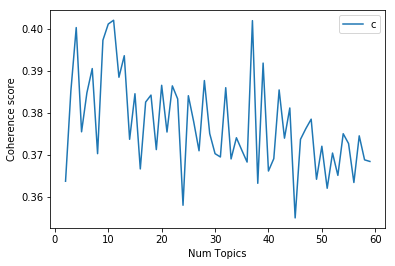

In [18]:
# Show graph
limit=limite
start=inicio
step=pasos;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
puntaje = 0
numero_modelo = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    if puntaje < round(cv, 4):
        puntaje = round(cv, 4)
        numero_modelo = m-2

Num Topics = 2  has Coherence Value of 0.3638
Num Topics = 3  has Coherence Value of 0.3852
Num Topics = 4  has Coherence Value of 0.4003
Num Topics = 5  has Coherence Value of 0.3755
Num Topics = 6  has Coherence Value of 0.3848
Num Topics = 7  has Coherence Value of 0.3905
Num Topics = 8  has Coherence Value of 0.3703
Num Topics = 9  has Coherence Value of 0.3973
Num Topics = 10  has Coherence Value of 0.4011
Num Topics = 11  has Coherence Value of 0.402
Num Topics = 12  has Coherence Value of 0.3885
Num Topics = 13  has Coherence Value of 0.3936
Num Topics = 14  has Coherence Value of 0.3737
Num Topics = 15  has Coherence Value of 0.3846
Num Topics = 16  has Coherence Value of 0.3667
Num Topics = 17  has Coherence Value of 0.3826
Num Topics = 18  has Coherence Value of 0.3842
Num Topics = 19  has Coherence Value of 0.3713
Num Topics = 20  has Coherence Value of 0.3866
Num Topics = 21  has Coherence Value of 0.3755
Num Topics = 22  has Coherence Value of 0.3864
Num Topics = 23  has C

In [20]:
# Select the model and print the topics
optimal_model = model_list[numero_modelo]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.032*"woman" + 0.030*"people" + 0.018*"white" + 0.016*"man" + '
  '0.015*"black" + 0.012*"sex" + 0.012*"judge" + 0.012*"case" + 0.011*"give" + '
  '0.007*"victim" + 0.007*"feel" + 0.007*"point" + 0.007*"long" + 0.007*"make" '
  '+ 0.007*"thread" + 0.006*"movement" + 0.006*"part" + 0.006*"state" + '
  '0.006*"crime" + 0.006*"deal" + 0.005*"term" + 0.005*"girl" + '
  '0.005*"experience" + 0.005*"evidence" + 0.005*"idea" + 0.005*"common" + '
  '0.005*"call" + 0.005*"lot" + 0.005*"legal" + 0.004*"early" + 0.004*"law" + '
  '0.004*"gender" + 0.004*"epstein" + 0.004*"sexual" + 0.004*"charge" + '
  '0.004*"violence" + 0.004*"powerful" + 0.004*"high" + 0.004*"process" + '
  '0.004*"problem"'),
 (1,
  '0.018*"president" + 0.017*"trump" + 0.017*"american" + 0.014*"congress" + '
  '0.013*"political" + 0.012*"law" + 0.010*"public" + 0.010*"house" + '
  '0.010*"rule" + 0.009*"democrat" + 0.009*"party" + 0.009*"vote" + '
  '0.009*"conservative" + 0.008*"make" + 0.007*"republican" + 0.007*"a

In [21]:
THIS_FOLDER = os.getcwd()
carpeta_modelo = "topico_final"
camino = os.path.join(THIS_FOLDER, carpeta_modelo)
archivo_modelo =  os.path.join(camino, "modelo_final")+".model"
print(archivo_modelo)
optimal_model.save(archivo_modelo)

E:\Documentos\usm-memoria\codigo\topicos\topico_final\modelo_final.model


In [27]:
all_topicos = []
for topico in optimal_model.print_topics(num_words=40):
    topico_aux = {}
    n_topico = topico[0]
    s_topico = topico[1]
    p_topico = s_topico.split("+")
    dict_palabra = {}
    for palabra in p_topico:
        lista_tupla = palabra.split("*")
        dict_palabra[lista_tupla[1].replace(' ', '').replace('\"', '')] = float(lista_tupla[0])
    topico_aux["topico"] = n_topico
    topico_aux["palabras"] = dict_palabra
    all_topicos.append(topico_aux)

        

In [28]:
topicos = mydb["nuevos_topicos"]
topicos.insert_many(all_topicos)

In [24]:
hilos = bd_hilos.find({})
for hilo in hilos:
    limpio = hilo["texto"]
    n_hilo = hilo["hilo"]
    vec = id2word.doc2bow(limpio.split())
    doc_topics = optimal_model[vec]
    doc_topics_sorted = sorted(doc_topics, key = lambda x: x[1], reverse = True)
    n_topic_hilo = doc_topics_sorted[0][0]
    bd_hilos.update_one({"hilo" : n_hilo}, {'$set':{"topico" : n_topic_hilo}})
    print(n_hilo)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27